In [1]:
import urllib.request
urllib.request.urlretrieve("http://misc.0093.tv/misc/kadai.xlsx", "kadai.xlsx")

('kadai.xlsx', <http.client.HTTPMessage at 0x16a1a987750>)

In [2]:
# ライブラリのインポート
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

c:\Users\yuema\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_excel("kadai.xlsx")
# 変数の指定
target = 'OV'
features = df.drop(columns=[target]).columns.tolist()

In [4]:
# 前処理と外れ値の処理
# 0. "process_end_time"と"final_mes_time"を時系列オブジェクトに変換する
df["process_end_time"] = pd.to_datetime(df["process_end_time"])
df["final_mes_time"] = pd.to_datetime(df["final_mes_time"])

# 1. 欠損値の確認
#df.info()

# 2. 外れ値の確認(IQR法)
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliners = df[(df[target] < lower_bound) | (df[target] > upper_bound)]

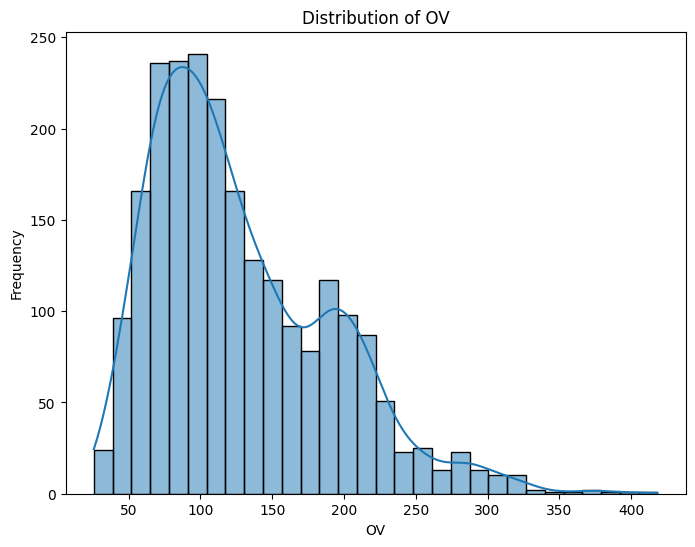

In [8]:
# ヒストグラム
plt.figure(figsize=(8, 6))
sns.histplot(df[target], bins=30, kde=True)
plt.title('Distribution of OV')
plt.xlabel('OV')
plt.ylabel('Frequency')
plt.show()

In [5]:
# SVMのモデル構築
svm_params = {
    'C': 10,
    'epsilon': 0.1,
    'kernel': 'rbf',
    'gamma': 0.1
}

svm_model = SVR(**svm_params)

# LightGBMのモデル構築
gbm_params = {
    'objective': 'tweedie',
    'tweedie_variance_power': 1.5,
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'min_child_samples': 20,
    'n_estimators': 1000,
    'verbose': -1
    }

lgb_model = lgb.LGBMRegressor(**gbm_params, random_state=42)    

Processing index: 1776 / 2276
Processing index: 1826 / 2276
Processing index: 1876 / 2276
Processing index: 1926 / 2276
Processing index: 1976 / 2276
Processing index: 2026 / 2276
Processing index: 2076 / 2276
Processing index: 2126 / 2276
Processing index: 2176 / 2276
Processing index: 2226 / 2276
LightGBM(Tweedie)): 86.19047886405512


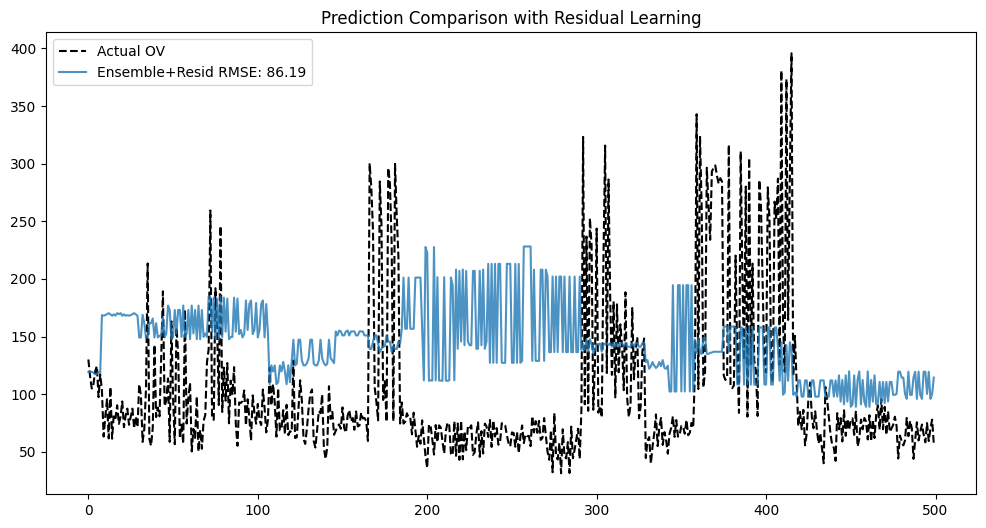

In [10]:
# 全変数Tweedieモデル
df1 = df.copy()
y_Hat = []
y_svm = []
y_lr = []

end = min(2276, len(df1))

for i in np.arange(1776, end):
    if (i - 1776) % 50 == 0:
        print(f"Processing index: {i} / 2276")

    learn = df1[0:i].copy().dropna()
    test = df1[i:i+1].copy()

    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)

    learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]

    X_l = learn.drop(columns=['process_end_time','final_mes_time',target], axis=1)
    y_l = learn[target]
    X_t = test.drop(columns=['process_end_time','final_mes_time',target], axis=1)

    scaler_x = StandardScaler()
    X_l_scaled = scaler_x.fit_transform(X_l)
    X_t_scaled = scaler_x.transform(X_t)

    lgb_model.fit(X_l_scaled, y_l)

    pred = lgb_model.predict(X_t_scaled)
    

    y_Hat.append(pred[0])

Y_t = df["OV"][1776:2276].reset_index(drop=True)
Y_t = Y_t.reset_index()['OV']

plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')

yh = np.array(y_Hat)
rmse = np.sqrt(mean_squared_error(Y_t, yh))
plt.plot(yh, label=f'Ensemble+Resid RMSE: {rmse:.2f}', alpha=0.8)
print(f"LightGBM(Tweedie)): {rmse}")

plt.legend()
plt.title("Prediction Comparison with Residual Learning")
plt.show()

Processing index: 1776 / 2276
Processing index: 1826 / 2276
Processing index: 1876 / 2276
Processing index: 1926 / 2276
Processing index: 1976 / 2276
Processing index: 2026 / 2276
Processing index: 2076 / 2276
Processing index: 2126 / 2276
Processing index: 2176 / 2276
Processing index: 2226 / 2276
LightGBM(Tweedie)): 64.30470691617303


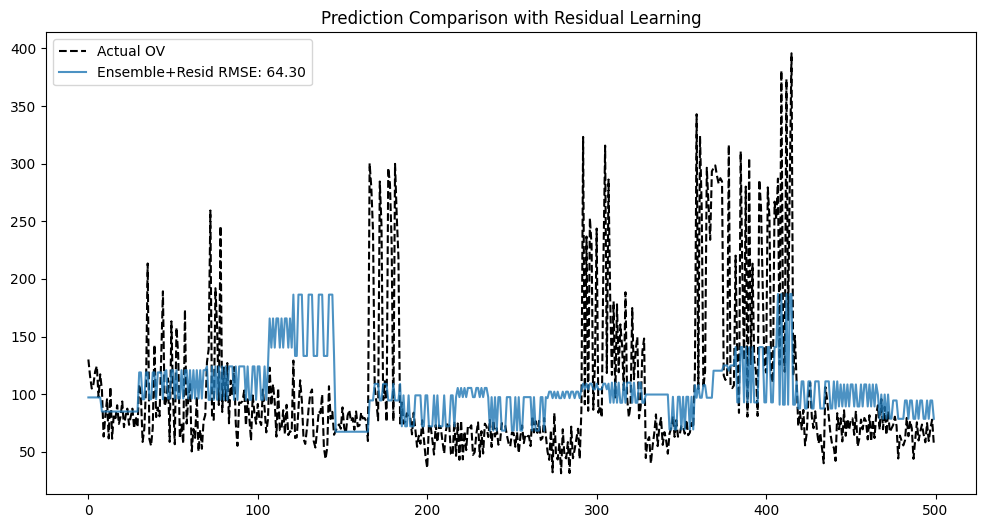

In [11]:
# Tweedieモデル(変数選択Var)
df2 = df.copy()
df2 = df2[["X14", "X30", "X33", "X83", "OV", "process_end_time", "final_mes_time"]]
y_Hat = []
y_svm = []
y_lr = []

end = min(2276, len(df1))

for i in np.arange(1776, end):
    if (i - 1776) % 50 == 0:
        print(f"Processing index: {i} / 2276")

    learn = df2[0:i].copy().dropna()
    test = df2[i:i+1].copy()

    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)

    learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]

    X_l = learn.drop(columns=['process_end_time','final_mes_time',target], axis=1)
    y_l = learn[target]
    X_t = test.drop(columns=['process_end_time','final_mes_time',target], axis=1)

    scaler_x = StandardScaler()
    X_l_scaled = scaler_x.fit_transform(X_l)
    X_t_scaled = scaler_x.transform(X_t)

    lgb_model.fit(X_l_scaled, y_l)

    pred = lgb_model.predict(X_t_scaled)
    

    y_Hat.append(pred[0])

Y_t = df["OV"][1776:2276].reset_index(drop=True)
Y_t = Y_t.reset_index()['OV']

plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')

yh = np.array(y_Hat)
rmse = np.sqrt(mean_squared_error(Y_t, yh))
plt.plot(yh, label=f'Ensemble+Resid RMSE: {rmse:.2f}', alpha=0.8)
print(f"LightGBM(Tweedie)): {rmse}")

plt.legend()
plt.title("Prediction Comparison with Residual Learning")
plt.show()

Processing index: 1776 / 2276
Processing index: 1826 / 2276
Processing index: 1876 / 2276
Processing index: 1926 / 2276
Processing index: 1976 / 2276
Processing index: 2026 / 2276
Processing index: 2076 / 2276
Processing index: 2126 / 2276
Processing index: 2176 / 2276
Processing index: 2226 / 2276
LightGBM(Tweedie)): 58.96349904414934


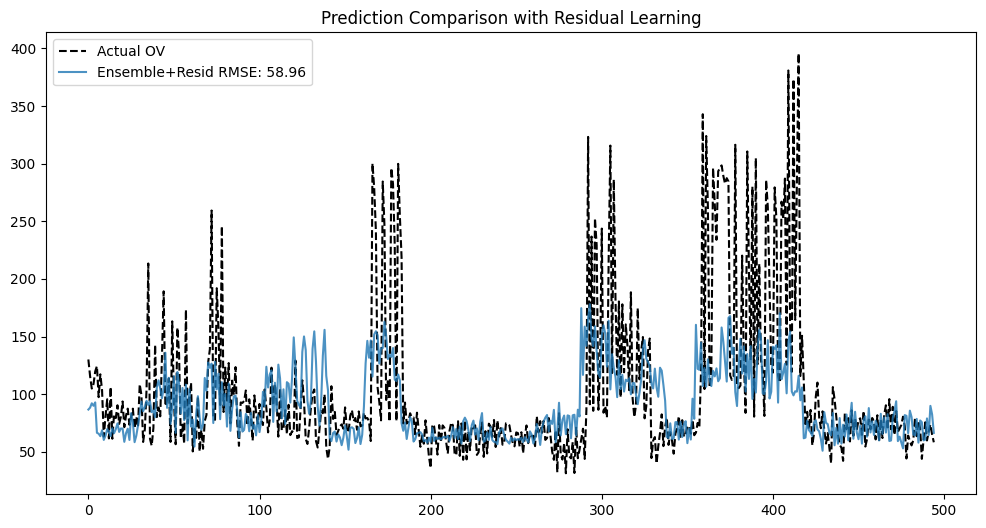

In [ ]:
# Tweedieモデル(変数選択Var)
df3 = df.copy()
df3 = df3[["X14", "X30", "X33", "X83", "OV", "process_end_time", "final_mes_time"]]
y_Hat = []
y_svm = []
y_lr = []

# 特徴量エンジニアリング
# 1. Lag特徴量
lags = [1, 2, 3, 5]
for lag in lags:
  df3[f"{target}_lag{lag}"] = df3[target].shift(lag)

# 2. 差分特徴量
df3[f"{target}_diff"] = df3[target].diff(1).shift(1)

# 3. 移動平均と移動標準偏差
windows = [3, 5]
for window in windows:
  df3[f"{target}_roll_mean{window}"] = df3[target].rolling(window).mean().shift(1)
  df3[f"{target}_roll_std{window}"] = df3[target].rolling(window).std().shift(1)

# 4. Shiftへの対応
df3 = df3.dropna().reset_index(drop=True)

end = min(2276, len(df3))

for i in np.arange(1776, end):
    if (i - 1776) % 50 == 0:
        print(f"Processing index: {i} / 2276")

    learn = df3[0:i].copy().dropna()
    test = df3[i:i+1].copy()

    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)

    learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
    
    X_l = learn.drop(columns=['process_end_time','final_mes_time',target], axis=1)
    y_l = learn[target]
    X_t = test.drop(columns=['process_end_time','final_mes_time',target], axis=1)

    scaler_x = StandardScaler()
    X_l_scaled = scaler_x.fit_transform(X_l)
    X_t_scaled = scaler_x.transform(X_t)

    lgb_model.fit(X_l_scaled, y_l)

    pred = lgb_model.predict(X_t_scaled)
    
    y_Hat.append(pred[0])

# Y_tは予測値と同じ個数だけ取得する
Y_t = df["OV"][1776:(1776 + len(y_Hat))].reset_index(drop=True).values

plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')

yh = np.array(y_Hat)
rmse = np.sqrt(mean_squared_error(Y_t, yh))
plt.plot(yh, label=f'Ensemble+Resid RMSE: {rmse:.2f}', alpha=0.8)
print(f"LightGBM(Tweedie)): {rmse}")

plt.legend()
plt.title("Prediction Comparison with Residual Learning")
plt.show()

Start Prediction with Clustering (k=5, window=24)...
Processing index: 1776 / 2252
Processing index: 1826 / 2252
Processing index: 1876 / 2252
Processing index: 1926 / 2252
Processing index: 1976 / 2252
Processing index: 2026 / 2252
Processing index: 2076 / 2252
Processing index: 2126 / 2252
Processing index: 2176 / 2252
Processing index: 2226 / 2252
Clustering Augmented Ensemble RMSE: 88.0229


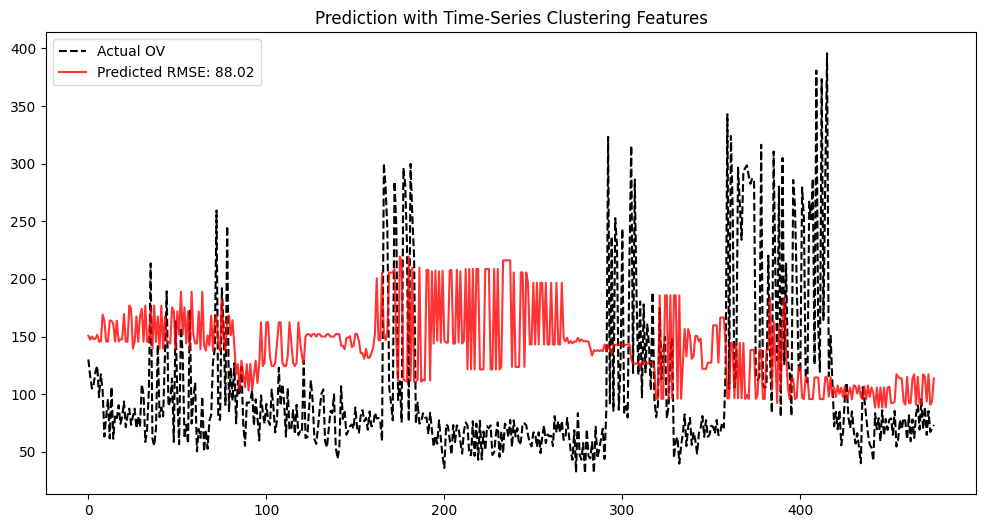

In [18]:
from sklearn.cluster import KMeans  # 追加: クラスタリング用

df4 = df.copy()
# ---------------------------------------------------------
# 事前準備: 波形認識用のラグ変数を作成
# ---------------------------------------------------------
# 論文を参考に、過去24時点(window_size)のデータを「波形」として扱います
window_size = 24
lag_cols = []

# まだラグ変数が作られていない場合のために作成
for i in range(1, window_size + 1):
    col_name = f'lag_{i}'
    df4[col_name] = df4[target].shift(i)
    lag_cols.append(col_name)

# ラグ作成による欠損を削除
df4 = df4.dropna().reset_index(drop=True)

# ---------------------------------------------------------
# ループ処理開始
# ---------------------------------------------------------
y_Hat = []
end_index = min(2276, len(df4))  # df4を使用（ラグ処理済み）

print(f"Start Prediction with Clustering (k=5, window={window_size})...")

for i in np.arange(1776, end_index):
    if (i - 1776) % 50 == 0:
        print(f"Processing index: {i} / {end_index}")

    # 1. データ分割 (ウォークフォワード)
    learn = df4[0:i].copy()
    test = df4[i:i+1].copy()
    
    # 時間順序を守る
    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)

    if len(test) > 0:
        learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
    else:
        continue

    # 学習データが空でないかチェック
    if len(learn) == 0:
        continue

    # -----------------------------------------------------
    # Step A: 時系列クラスタリング (波形の分類)
    # -----------------------------------------------------
    # 過去24点のラグ変数だけを取り出す（これが「波形の形」を表す）
    X_cluster_learn = learn[lag_cols]
    X_cluster_test = test[lag_cols]

    # クラスタリング用に標準化 (波形の「形」を見たいのでスケールを揃える)
    scaler_cl = StandardScaler()
    X_cl_l_scaled = scaler_cl.fit_transform(X_cluster_learn)
    X_cl_t_scaled = scaler_cl.transform(X_cluster_test)

    # K-Means実行 (クラスタ数=5程度が妥当)
    # 論文では階層型だが、計算速度重視でK-Meansを採用
    n_clusters = 5
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    
    # 学習データの波形パターンを学習 & 分類
    learn_labels = kmeans.fit_predict(X_cl_l_scaled)
    # テストデータの波形パターンを予測 (※testでfitしてはいけない)
    test_labels = kmeans.predict(X_cl_t_scaled)

    # -----------------------------------------------------
    # Step B: クラスタIDを特徴量に追加 (One-Hot Encoding)
    # -----------------------------------------------------
    # SVMやLassoは「カテゴリ値(0,1,2...)」を数値の大小として誤解するため、
    # 必ず One-Hot (ダミー変数) に変換する
    
    # 学習データへの追加
    cluster_dummies_l = pd.get_dummies(learn_labels, prefix='Cluster').astype(int)
    # すべてのクラスタ列(0~4)が揃うように調整 (稀なクラスタが出ない場合対策)
    for c in range(n_clusters):
        if f'Cluster_{c}' not in cluster_dummies_l.columns:
            cluster_dummies_l[f'Cluster_{c}'] = 0
    # 列順序を固定
    cluster_dummies_l = cluster_dummies_l[sorted(cluster_dummies_l.columns)]
    
    # テストデータへの追加
    cluster_dummies_t = pd.get_dummies(test_labels, prefix='Cluster').astype(int)
    for c in range(n_clusters):
        if f'Cluster_{c}' not in cluster_dummies_t.columns:
            cluster_dummies_t[f'Cluster_{c}'] = 0
    cluster_dummies_t = cluster_dummies_t[sorted(cluster_dummies_t.columns)]

    # -----------------------------------------------------
    # Step C: メインの学習データの作成
    # -----------------------------------------------------
    # ベースの特徴量 (変数選択済みのものなど)
    base_cols = [c for c in df4.columns if c not in ['process_end_time', 'final_mes_time', target] + lag_cols]
    
    # ベース特徴量 + クラスタ特徴量 を結合
    X_l = pd.concat([learn[base_cols].reset_index(drop=True), cluster_dummies_l.reset_index(drop=True)], axis=1)
    y_l = learn[target]
    
    X_t = pd.concat([test[base_cols].reset_index(drop=True), cluster_dummies_t.reset_index(drop=True)], axis=1)

    # -----------------------------------------------------
    # Step D: モデル学習 (アンサンブル)
    # -----------------------------------------------------
    # Xのスケーリング (Lasso/SVM用)
    scaler_x = StandardScaler()
    X_l_scaled = scaler_x.fit_transform(X_l)
    X_t_scaled = scaler_x.transform(X_t)

    # 1.
    lgb_model.fit(X_l_scaled, y_l)
    pred_lgb = lgb_model.predict(X_t_scaled)[0]

    # 合体
    final_pred = pred_lgb
    y_Hat.append(final_pred)

# --- 評価 ---
# 予測値と同じ個数だけ実際の値を取得
Y_t = df[target].iloc[1776:(1776 + len(y_Hat))].reset_index(drop=True).values
yh = np.array(y_Hat)

rmse = np.sqrt(mean_squared_error(Y_t, yh))
print(f"Clustering Augmented Ensemble RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')
plt.plot(yh, label=f'Predicted RMSE: {rmse:.2f}', color='red', alpha=0.8)
plt.title("Prediction with Time-Series Clustering Features")
plt.legend()
plt.show()

Processing index: 1776 / 2276
Processing index: 1826 / 2276
Processing index: 1876 / 2276
Processing index: 1926 / 2276
Processing index: 1976 / 2276
Processing index: 2026 / 2276
Processing index: 2076 / 2276
Processing index: 2126 / 2276
Processing index: 2176 / 2276
Processing index: 2226 / 2276
LightGBM(Tweedie)): 58.96349904414934


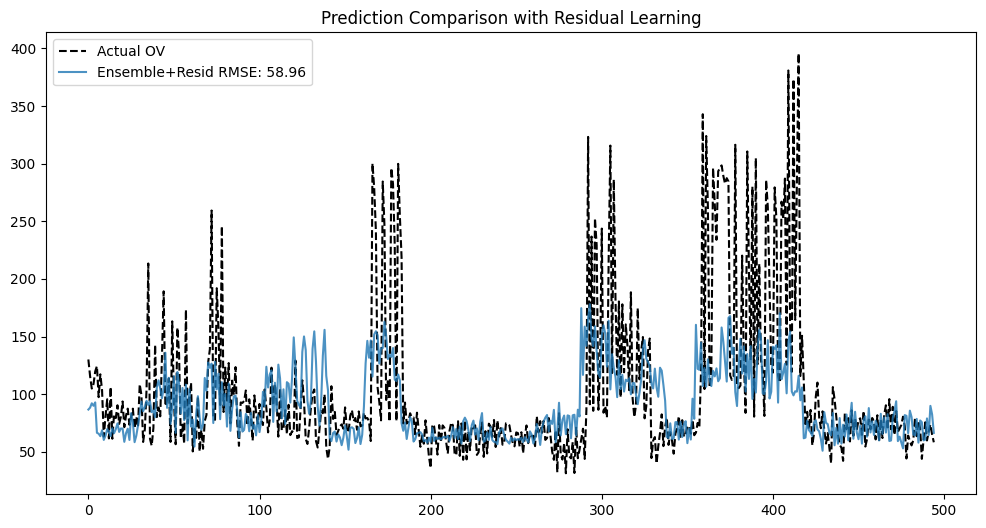

In [22]:
# Tweedieモデル(Seed Averaging)
df5 = df.copy()
df5 = df5[["X14", "X30", "X33", "X83", "OV", "process_end_time", "final_mes_time"]]

y_Hat = []
y_svm = []
y_lr = []

# 特徴量エンジニアリング
# 1. Lag特徴量
lags = [1, 2, 3, 5]
for lag in lags:
  df5[f"{target}_lag{lag}"] = df5[target].shift(lag)

# 2. 差分特徴量
df5[f"{target}_diff"] = df5[target].diff(1).shift(1)

# 3. 移動平均と移動標準偏差
windows = [3, 5]
for window in windows:
  df5[f"{target}_roll_mean{window}"] = df5[target].rolling(window).mean().shift(1)
  df5[f"{target}_roll_std{window}"] = df5[target].rolling(window).std().shift(1)

# 4. Shiftへの対応
df5 = df5.dropna().reset_index(drop=True)

end = min(2276, len(df5))

for i in np.arange(1776, end):
    pred_list = []
    if (i - 1776) % 50 == 0:
        print(f"Processing index: {i} / 2276")

    learn = df5[0:i].copy().dropna()
    test = df5[i:i+1].copy()

    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)

    learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
    
    X_l = learn.drop(columns=['process_end_time','final_mes_time',target], axis=1)
    y_l = learn[target]
    X_t = test.drop(columns=['process_end_time','final_mes_time',target], axis=1)

    scaler_x = StandardScaler()
    X_l_scaled = scaler_x.fit_transform(X_l)
    X_t_scaled = scaler_x.transform(X_t)

    for j in range(5):
        model = lgb.LGBMRegressor(**gbm_params, random_state=42 + j)
        model.fit(X_l_scaled, y_l)
        pred_list.append(model.predict(X_t_scaled)[0])

    pred = np.mean(pred_list)
    
    y_Hat.append(pred)

# Y_tは予測値と同じ個数だけ取得する
Y_t = df["OV"][1776:(1776 + len(y_Hat))].reset_index(drop=True).values

plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')

yh = np.array(y_Hat)
rmse = np.sqrt(mean_squared_error(Y_t, yh))
plt.plot(yh, label=f'Ensemble+Resid RMSE: {rmse:.2f}', alpha=0.8)
print(f"LightGBM(Tweedie)): {rmse}")

plt.legend()
plt.title("Prediction Comparison with Residual Learning")
plt.show()

# 全変数RMSE:69.36397560482494

Processing index: 1776 / 2276
Processing index: 1826 / 2276
Processing index: 1876 / 2276
Processing index: 1926 / 2276
Processing index: 1976 / 2276
Processing index: 2026 / 2276
Processing index: 2076 / 2276
Processing index: 2126 / 2276
Processing index: 2176 / 2276
LightGBM(Tweedie)): 82.02603471465709


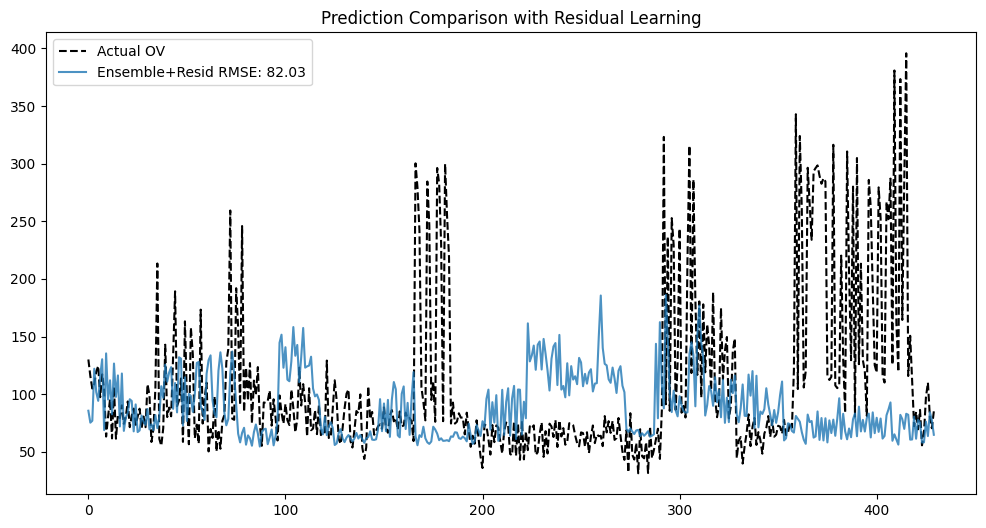

In [24]:
# Tweedieモデル(変数選択Var)
df6 = df.copy()
df6 = df6[["X14", "X30", "X33", "X83", "OV", "process_end_time", "final_mes_time"]]
y_Hat = []
y_svm = []
y_lr = []

# 特徴量エンジニアリング
# 1. Lag特徴量
lags = [1, 2, 3, 5]
for lag in lags:
  df6[f"{target}_lag{lag}"] = df6[target].shift(lag)

# 2. 差分特徴量
df6[f"{target}_diff"] = df6[target].diff(1).shift(1)

# 3. 移動平均と移動標準偏差
windows = [3, 5]
for window in windows:
  df6[f"{target}_roll_mean{window}"] = df6[target].rolling(window).mean().shift(1)
  df6[f"{target}_roll_std{window}"] = df6[target].rolling(window).std().shift(1)

# 過去70単位期間の最大値と最小値
df6[f"{target}_roll_max70"] = df6[target].rolling(70).max().shift(1)
df6[f"{target}_roll_min70"] = df6[target].rolling(70).min().shift(1)

# 4. Shiftへの対応
df6 = df6.dropna().reset_index(drop=True)
end = min(2276, len(df6))

for i in np.arange(1776, end):
    if (i - 1776) % 50 == 0:
        print(f"Processing index: {i} / 2276")

    learn = df6[0:i].copy().dropna()
    test = df6[i:i+1].copy()

    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)

    learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
    
    X_l = learn.drop(columns=['process_end_time','final_mes_time',target], axis=1)
    y_l = learn[target]
    X_t = test.drop(columns=['process_end_time','final_mes_time',target], axis=1)

    scaler_x = StandardScaler()
    X_l_scaled = scaler_x.fit_transform(X_l)
    X_t_scaled = scaler_x.transform(X_t)

    lgb_model.fit(X_l_scaled, y_l)

    pred = lgb_model.predict(X_t_scaled)
    
    y_Hat.append(pred[0])

# Y_tは予測値と同じ個数だけ取得する
Y_t = df["OV"][1776:(1776 + len(y_Hat))].reset_index(drop=True).values

plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')

yh = np.array(y_Hat)
rmse = np.sqrt(mean_squared_error(Y_t, yh))
plt.plot(yh, label=f'Ensemble+Resid RMSE: {rmse:.2f}', alpha=0.8)
print(f"LightGBM(Tweedie)): {rmse}")

plt.legend()
plt.title("Prediction Comparison with Residual Learning")
plt.show()

Processing index: 1776 / 2276
Processing index: 1826 / 2276
Processing index: 1876 / 2276
Processing index: 1926 / 2276
Processing index: 1976 / 2276
Processing index: 2026 / 2276
Processing index: 2076 / 2276
Processing index: 2126 / 2276
Processing index: 2176 / 2276
Processing index: 2226 / 2276
LightGBM(Tweedie)): 153.25335600783515


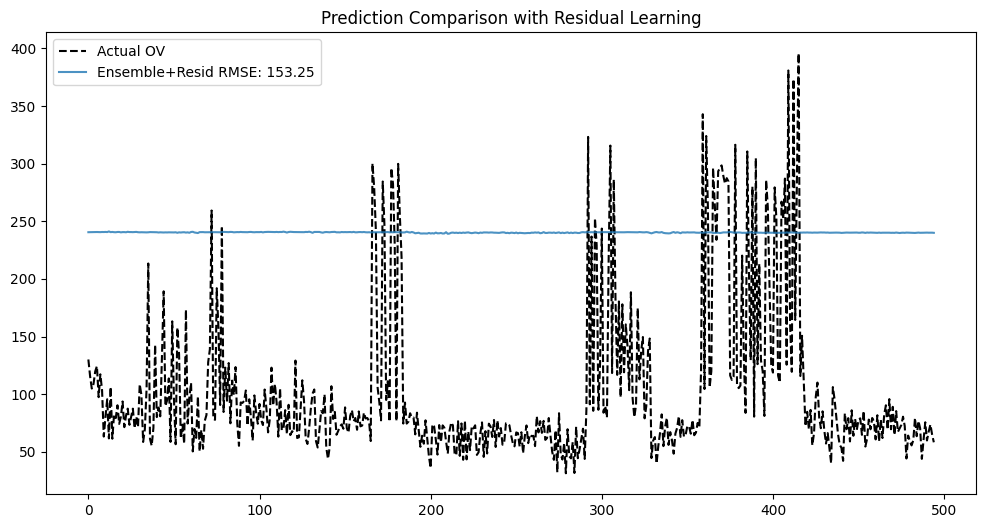

In [20]:
df7 = df.copy()
y_Hat = []
pred_12 = []
pred_22 = []
pred_32 = []
pred_42 = []
pred_52 = []

df7 = df7[["X14", "X7", "X33", "X58", "OV", "process_end_time", "final_mes_time"]]

# 特徴量エンジニアリング
# 1. Lag特徴量
lags = [1, 2, 3, 5]
for lag in lags:
  df7[f"{target}_lag{lag}"] = df7[target].shift(lag)

# 2. 差分特徴量
df7[f"{target}_diff"] = df7[target].diff(1).shift(1)

# 3. 移動平均と移動標準偏差
windows = [3, 5]
for window in windows:
  df7[f"{target}_roll_mean{window}"] = df7[target].rolling(window).mean().shift(1)
  df7[f"{target}_roll_std{window}"] = df7[target].rolling(window).std().shift(1)

# 4. Shiftへの対応
df7 = df7.dropna().reset_index(drop=True)

end = min(2276, len(df7))
xgb_params = {
        'learning_rate': 0.2,
        'max_depth': 7,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 5,
        'n_estimators': 1000,
        'random_state': 42,
        'n_jobs': -1
    }

for i in np.arange(1776, end):
    if (i - 1776) % 50 == 0:
        print(f"Processing index: {i} / 2276")

    learn = df7[0:i].copy().dropna()
    test = df7[i:i+1].copy()

    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)

    learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
    
    X_l = learn.drop(columns=['process_end_time','final_mes_time',target], axis=1)
    y_l = learn[target]
    X_t = test.drop(columns=['process_end_time','final_mes_time',target], axis=1)

    scaler_x = StandardScaler()
    X_l_scaled = scaler_x.fit_transform(X_l)
    X_t_scaled = scaler_x.transform(X_t)

    model1 = lgb.LGBMRegressor(**gbm_params, random_state=12)
    model2 = lgb.LGBMRegressor(**gbm_params, random_state=22)
    model3 = lgb.LGBMRegressor(**gbm_params, random_state=32)
    model4 = lgb.LGBMRegressor(**gbm_params, random_state=42)
    model5 = lgb.LGBMRegressor(**gbm_params, random_state=52)

    model1.fit(X_l_scaled, y_l)
    model2.fit(X_l_scaled, y_l)
    model3.fit(X_l_scaled, y_l)
    model4.fit(X_l_scaled, y_l)
    model5.fit(X_l_scaled, y_l)

    base_pred = (model1.predict(X_l_scaled) + model2.predict(X_l_scaled) + model3.predict(X_l_scaled) + model4.predict(X_l_scaled) + model5.predict(X_l_scaled)) / 5
    residuals = y_l - base_pred

    model6 = SVR(**svm_params)
    model7 = xgb.XGBRegressor(**xgb_params)
    model6.fit(X_l_scaled, residuals)
    model7.fit(X_l_scaled, residuals)

    pred_resid = (model6.predict(X_t_scaled) + model7.predict(X_t_scaled)) / 2
    pred = base_pred + pred_resid

    pred_12.append(model1.predict(X_t_scaled)[0])
    pred_22.append(model2.predict(X_t_scaled)[0])
    pred_32.append(model3.predict(X_t_scaled)[0])
    pred_42.append(model4.predict(X_t_scaled)[0])
    pred_52.append(model5.predict(X_t_scaled)[0])
    y_Hat.append(pred[0])

# Y_tは予測値と同じ個数だけ取得する
Y_t = df["OV"][1776:(1776 + len(y_Hat))].reset_index(drop=True).values
plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')
yh = np.array(y_Hat)
rmse = np.sqrt(mean_squared_error(Y_t, yh))
plt.plot(yh, label=f'Ensemble+Resid RMSE: {rmse:.2f}', alpha=0.8)
print(f"LightGBM(Tweedie)): {rmse}")
plt.legend()
plt.title("Prediction Comparison with Residual Learning")
plt.show()

# 残差予測SVMのみのRMSE=57.2307

--- 手法再検討プロジェクト: スタート ---
初期データサイズ: 2276
前処理後のデータサイズ: 2252
Start Prediction Loop (Lasso + LightGBM Residuals + Clustering)...
Processing index: 1776 / 2252
Processing index: 1826 / 2252
Processing index: 1876 / 2252
Processing index: 1926 / 2252
Processing index: 1976 / 2252
Processing index: 2026 / 2252
Processing index: 2076 / 2252
Processing index: 2126 / 2252
Processing index: 2176 / 2252
Processing index: 2226 / 2252
--------------------------------------------------
Reconstructed Model RMSE: 68.0304
--------------------------------------------------


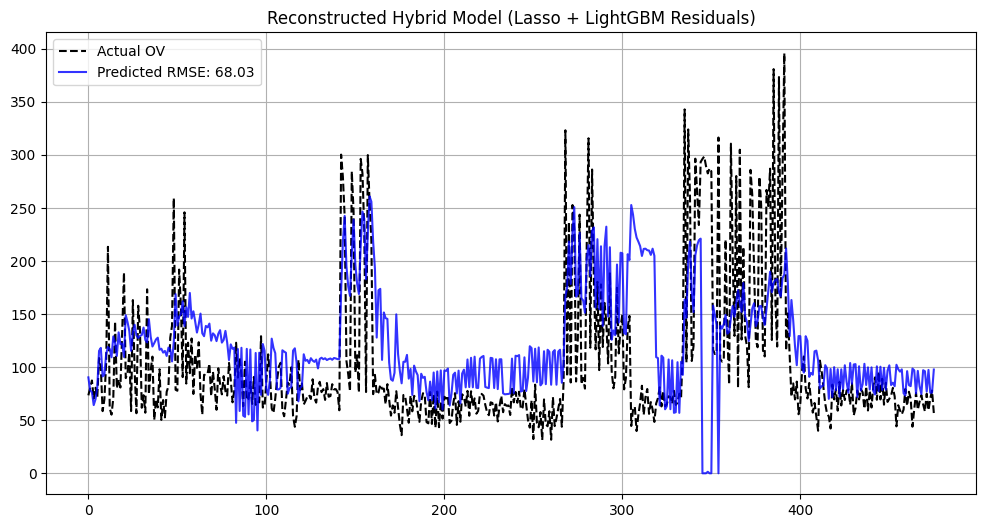

In [10]:
from sklearn.cluster import KMeans

# ---------------------------------------------------------
# 1. 初期化とデータコピー
# ---------------------------------------------------------
# ここからスタートします
df8 = df.copy()
target = 'OV' # 目的変数名

print("--- 手法再検討プロジェクト: スタート ---")
print(f"初期データサイズ: {len(df8)}")

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング（鉄の掟：リーケージ完全排除）
# ---------------------------------------------------------
# 論文(E5-2)推奨の History=24 を基準にする
window_size = 24

# 【重要】必ず shift(1) を入れてから計算する（当日の値を含めない）
# 移動平均・最大・最小・範囲
df8['roll_mean_24'] = df8[target].shift(1).rolling(window=window_size).mean()
df8['roll_max_24']  = df8[target].shift(1).rolling(window=window_size).max()
df8['roll_min_24']  = df8[target].shift(1).rolling(window=window_size).min()
df8['roll_range_24'] = df8['roll_max_24'] - df8['roll_min_24'] # ボラティリティ

# ラグ変数（過去の値をそのまま使う & クラスタリング用）
lag_cols = []
for i in range(1, window_size + 1):
    col_name = f'lag_{i}'
    df8[col_name] = df8[target].shift(i)
    lag_cols.append(col_name)

# 特徴量作成で発生したNaN（先頭24行など）を削除
df8 = df8.dropna().reset_index(drop=True)

print(f"前処理後のデータサイズ: {len(df8)}")

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (Walk-Forward Validation)
# ---------------------------------------------------------
y_Hat = []
start_index = 1776
end_index = min(2276, len(df8))

# 安全装置用の上限値（学習データ全体の最大値の1.5倍）
global_max_limit = df8[target].max() * 1.5

print("Start Prediction Loop (Lasso + LightGBM Residuals + Clustering)...")

for i in np.arange(start_index, end_index):
    if (i - start_index) % 50 == 0:
        print(f"Processing index: {i} / {end_index}")

    # --- データの分割 ---
    learn = df8[0:i].copy()
    test = df8[i:i+1].copy()

    # 【修正】先にインデックスをリセットする
    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)
    
    # 時系列の断絶処理（念のため）
    if len(test) > 0:
        # インデックスが0になっているので、これで動きます
        learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
    else:
        continue
    
    # インデックスリセット
    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)

    # -----------------------------------------------------
    # Step A: 時系列クラスタリング (論文手法)
    # -----------------------------------------------------
    # 過去24点のラグ変数を使って「波形の形」を分類する
    X_cluster_learn = learn[lag_cols]
    X_cluster_test = test[lag_cols]

    # クラスタリング用に標準化
    scaler_cl = StandardScaler()
    X_cl_l = scaler_cl.fit_transform(X_cluster_learn)
    X_cl_t = scaler_cl.transform(X_cluster_test)

    # K-Means実行 (5パターンに分類)
    n_clusters = 5
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    learn_labels = kmeans.fit_predict(X_cl_l)
    test_labels = kmeans.predict(X_cl_t)

    # クラスタIDをOne-Hotエンコーディングして特徴量に追加
    # 学習データ
    cluster_dummies_l = pd.get_dummies(learn_labels, prefix='Cluster').astype(int)
    # テストデータ
    cluster_dummies_t = pd.get_dummies(test_labels, prefix='Cluster').astype(int)

    # 列を揃える（テストデータに存在しないクラスタIDがある場合の対策）
    for c in range(n_clusters):
        col = f'Cluster_{c}'
        if col not in cluster_dummies_l.columns: cluster_dummies_l[col] = 0
        if col not in cluster_dummies_t.columns: cluster_dummies_t[col] = 0
    
    # 列順序を固定
    cluster_cols = sorted([f'Cluster_{c}' for c in range(n_clusters)])
    cluster_dummies_l = cluster_dummies_l[cluster_cols]
    cluster_dummies_t = cluster_dummies_t[cluster_cols]

    # -----------------------------------------------------
    # Step B: 学習用データの作成
    # -----------------------------------------------------
    # 除外するカラム
    drop_cols = ['process_end_time', 'final_mes_time', target]
    
    # 基本特徴量
    X_l_base = learn.drop(columns=drop_cols, axis=1)
    X_t_base = test.drop(columns=drop_cols, axis=1)

    # 基本特徴量 + クラスタ特徴量を結合
    X_l = pd.concat([X_l_base, cluster_dummies_l], axis=1)
    X_t = pd.concat([X_t_base, cluster_dummies_t], axis=1)
    
    y_l = learn[target]

    # メインモデル用のスケーリング
    scaler_main = StandardScaler()
    X_l_scaled = scaler_main.fit_transform(X_l)
    X_t_scaled = scaler_main.transform(X_t)

    # -----------------------------------------------------
    # Step C: モデル学習 (2段階構成)
    # -----------------------------------------------------
    
    # 1. ベースモデル: Lasso (トレンド担当)
    # 線形で大まかな値を予測
    model_lasso = LassoCV(cv=5, random_state=42, max_iter=10000, n_jobs=-1)
    model_lasso.fit(X_l_scaled, y_l)
    pred_trend = model_lasso.predict(X_t_scaled)[0]

    # 2. 残差モデル: LightGBM (補正担当)
    # Lassoが外した誤差を予測
    residuals = y_l - model_lasso.predict(X_l_scaled)
    
    # LightGBMデータセット
    lgb_train = lgb.Dataset(X_l, residuals) # LGBMはスケーリング不要だがX_lそのまま使用
    
    # パラメータ（過学習を防ぐ設定）
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'max_depth': 5,         # 深さを制限して過学習防止
        'num_leaves': 20,
        'min_data_in_leaf': 20,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'seed': 42,
        'verbose': -1
    }
    
    model_lgb = lgb.train(params, lgb_train, num_boost_round=100)
    pred_resid = model_lgb.predict(X_t)[0]

    # -----------------------------------------------------
    # Step D: 合体 & 安全装置 (Clipping)
    # -----------------------------------------------------
    final_pred = pred_trend + pred_resid
    
    # クリップ処理：マイナス値や異常な高値をカット
    if final_pred < 0:
        final_pred = 0
    elif final_pred > global_max_limit:
        final_pred = global_max_limit

    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価と可視化
# ---------------------------------------------------------
Y_t = df8[target].iloc[start_index:end_index].reset_index(drop=True)
yh = np.array(y_Hat)

rmse = np.sqrt(mean_squared_error(Y_t, yh))
print(f"--------------------------------------------------")
print(f"Reconstructed Model RMSE: {rmse:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')
plt.plot(yh, label=f'Predicted RMSE: {rmse:.2f}', color='blue', alpha=0.8)
plt.title("Reconstructed Hybrid Model (Lasso + LightGBM Residuals)")
plt.legend()
plt.grid(True)
plt.show()

--- 変数クラスタリング & 代表変数選定 (df9) ---
クラスタリング対象変数: 83個

--- 選定された代表変数 ---
Cluster 1: X58
Cluster 2: X7
Cluster 3: X33
Cluster 4: X14

Start Prediction with Selected Features...
Processing index: 1776 / 2252
Processing index: 1826 / 2252
Processing index: 1876 / 2252
Processing index: 1926 / 2252
Processing index: 1976 / 2252
Processing index: 2026 / 2252
Processing index: 2076 / 2252
Processing index: 2126 / 2252
Processing index: 2176 / 2252
Processing index: 2226 / 2252
--------------------------------------------------
Selected Variables RMSE (Fixed): 71.3545
--------------------------------------------------


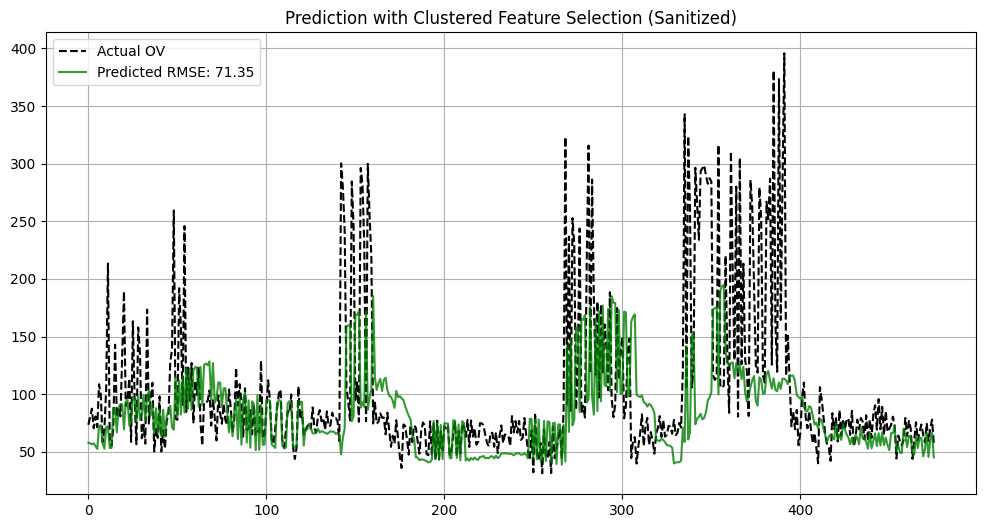

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.cluster import KMeans
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. 初期化とデータ準備
# ---------------------------------------------------------
df9 = df.copy()
target = 'OV'
window_size = 24

# --- 特徴量エンジニアリング ---
df9['roll_mean_24'] = df9[target].shift(1).rolling(window=window_size).mean()
df9['roll_max_24']  = df9[target].shift(1).rolling(window=window_size).max()
df9['roll_min_24']  = df9[target].shift(1).rolling(window=window_size).min()
df9['roll_range_24'] = df9['roll_max_24'] - df9['roll_min_24']

# ラグ変数
lag_cols = []
for i in range(1, window_size + 1):
    col_name = f'lag_{i}'
    df9[col_name] = df9[target].shift(i)
    lag_cols.append(col_name)

# NaN削除
df9 = df9.dropna().reset_index(drop=True)

# ---------------------------------------------------------
# 2. 変数選択: 相関行列によるクラスタリング
# ---------------------------------------------------------
print("--- 変数クラスタリング & 代表変数選定 (df9) ---")

excluded_cols = ['process_end_time', 'final_mes_time', target] + \
                ['roll_mean_24', 'roll_max_24', 'roll_min_24', 'roll_range_24'] + lag_cols

base_features = [c for c in df9.columns if c not in excluded_cols]
print(f"クラスタリング対象変数: {len(base_features)}個")

# 相関行列の計算 (NaN対策入り)
corr_matrix = df9[base_features].corr(method='spearman').fillna(0).abs()

# 距離行列変換
dist_matrix = 1 - corr_matrix
dist_matrix = (dist_matrix + dist_matrix.T) / 2
np.fill_diagonal(dist_matrix.values, 0)

# クラスタリング
dist_array = squareform(np.clip(dist_matrix.values, 0, None), checks=False)
Z = linkage(dist_array, method='ward')

num_clusters = 4
cluster_labels = fcluster(Z, t=num_clusters, criterion='maxclust')

selected_base_features = []
target_corr = df9[base_features].corrwith(df9[target]).abs().fillna(0)

print("\n--- 選定された代表変数 ---")
for i in range(1, num_clusters + 1):
    cluster_vars = [base_features[j] for j, label in enumerate(cluster_labels) if label == i]
    if len(cluster_vars) > 0:
        best_var = target_corr[cluster_vars].idxmax()
        selected_base_features.append(best_var)
        print(f"Cluster {i}: {best_var}")
    else:
        print(f"Cluster {i}: メンバーなし")

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (サニタイズ処理強化版)
# ---------------------------------------------------------
y_Hat = []
start_index = 1776
end_index = min(2276, len(df9))
global_max_limit = df9[target].max() * 1.5

print("\nStart Prediction with Selected Features...")

for i in np.arange(start_index, end_index):
    if (i - start_index) % 50 == 0:
        print(f"Processing index: {i} / {end_index}")

    # --- データの分割とリセット ---
    learn = df9[0:i].copy().reset_index(drop=True)
    test = df9[i:i+1].copy().reset_index(drop=True)
    
    if len(test) > 0:
        learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
    else:
        continue

    # --- Step A: 波形クラスタリング ---
    X_cluster_learn = learn[lag_cols]
    X_cluster_test = test[lag_cols]

    scaler_cl = StandardScaler()
    X_cl_l = scaler_cl.fit_transform(X_cluster_learn)
    X_cl_t = scaler_cl.transform(X_cluster_test)
    
    # クラスタリング計算時のNaN対策
    X_cl_l = np.nan_to_num(X_cl_l)
    X_cl_t = np.nan_to_num(X_cl_t)

    n_wave_clusters = 5
    kmeans = KMeans(n_clusters=n_wave_clusters, random_state=42, n_init=10)
    learn_labels = kmeans.fit_predict(X_cl_l)
    test_labels = kmeans.predict(X_cl_t)

    cluster_dummies_l = pd.get_dummies(learn_labels, prefix='WaveCluster').astype(int)
    cluster_dummies_t = pd.get_dummies(test_labels, prefix='WaveCluster').astype(int)

    # カラム調整
    for c in range(n_wave_clusters):
        col = f'WaveCluster_{c}'
        if col not in cluster_dummies_l.columns: cluster_dummies_l[col] = 0
        if col not in cluster_dummies_t.columns: cluster_dummies_t[col] = 0
    
    cluster_cols = sorted([f'WaveCluster_{c}' for c in range(n_wave_clusters)])
    cluster_dummies_l = cluster_dummies_l[cluster_cols]
    cluster_dummies_t = cluster_dummies_t[cluster_cols]

    # --- Step B: 学習用データの作成 (厳密な結合) ---
    fe_cols = ['roll_mean_24', 'roll_max_24', 'roll_min_24', 'roll_range_24']
    
    # 【重要】インデックスを確実にリセットして結合 (ズレによるNaN防止)
    X_l = pd.concat([
        learn[selected_base_features].reset_index(drop=True), 
        learn[fe_cols].reset_index(drop=True), 
        cluster_dummies_l.reset_index(drop=True)
    ], axis=1)
    
    X_t = pd.concat([
        test[selected_base_features].reset_index(drop=True), 
        test[fe_cols].reset_index(drop=True), 
        cluster_dummies_t.reset_index(drop=True)
    ], axis=1)
    
    y_l = learn[target].reset_index(drop=True)

    # 【重要】結合後のNaN埋め (念のため)
    X_l = X_l.fillna(0)
    X_t = X_t.fillna(0)
    y_l = y_l.fillna(0)

    # スケーリング
    scaler_main = StandardScaler()
    X_l_scaled = scaler_main.fit_transform(X_l)
    X_t_scaled = scaler_main.transform(X_t)
    
    # 【重要】スケーリング後のNaN/Inf対策 (LassoCVのエラー原因)
    X_l_scaled = np.nan_to_num(X_l_scaled)
    X_t_scaled = np.nan_to_num(X_t_scaled)

    # --- Step C: モデル学習 ---
    
    # 1. Lasso
    model_lasso = LassoCV(cv=5, random_state=42, max_iter=10000, n_jobs=-1)
    model_lasso.fit(X_l_scaled, y_l)
    pred_trend = model_lasso.predict(X_t_scaled)[0]

    # 2. LightGBM (残差)
    residuals = y_l - model_lasso.predict(X_l_scaled)
    lgb_train = lgb.Dataset(X_l, residuals)
    
    params = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.05,
        'max_depth': 5, 'num_leaves': 20, 'min_data_in_leaf': 20,
        'bagging_fraction': 0.8, 'bagging_freq': 1, 'seed': 42, 'verbose': -1
    }
    model_lgb = lgb.train(params, lgb_train, num_boost_round=100)
    pred_resid = model_lgb.predict(X_t)[0]

    final_pred = pred_trend + pred_resid
    final_pred = np.clip(final_pred, 0, global_max_limit)

    y_Hat.append(final_pred)

# 評価
Y_t = df9[target].iloc[start_index:end_index].reset_index(drop=True)
yh = np.array(y_Hat)
rmse = np.sqrt(mean_squared_error(Y_t, yh))

print(f"--------------------------------------------------")
print(f"Selected Variables RMSE (Fixed): {rmse:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')
plt.plot(yh, label=f'Predicted RMSE: {rmse:.2f}', color='green', alpha=0.8)
plt.title("Prediction with Clustered Feature Selection (Sanitized)")
plt.legend()
plt.grid(True)
plt.show()

Number of features: 111
Start Prediction...
Processing index: 1776 / 2252
Processing index: 1826 / 2252
Processing index: 1876 / 2252
Processing index: 1926 / 2252
Processing index: 1976 / 2252
Processing index: 2026 / 2252
Processing index: 2076 / 2252
Processing index: 2126 / 2252
Processing index: 2176 / 2252
Processing index: 2226 / 2252
--------------------------------------------------
RMSE: 68.0304
--------------------------------------------------


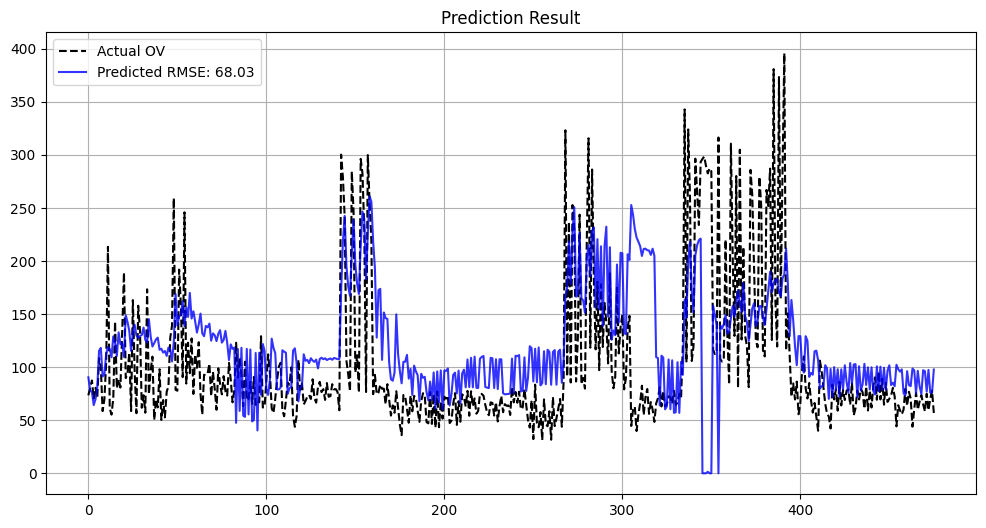

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')

df10 = df.copy()
target = 'OV'
window_size = 24

df10['roll_mean_24'] = df10[target].shift(1).rolling(window=window_size).mean()
df10['roll_max_24']  = df10[target].shift(1).rolling(window=window_size).max()
df10['roll_min_24']  = df10[target].shift(1).rolling(window=window_size).min()
df10['roll_range_24'] = df10['roll_max_24'] - df10['roll_min_24']

lag_cols = []
for i in range(1, window_size + 1):
    col_name = f'lag_{i}'
    df10[col_name] = df10[target].shift(i)
    lag_cols.append(col_name)

df10 = df10.dropna().reset_index(drop=True)

drop_cols = ['process_end_time', 'final_mes_time', target]
features = [c for c in df10.columns if c not in drop_cols]

print(f"Number of features: {len(features)}")

y_Hat = []
start_index = 1776
end_index = min(2276, len(df10))
global_max_limit = df10[target].max() * 1.5

print("Start Prediction...")

for i in np.arange(start_index, end_index):
    if (i - start_index) % 50 == 0:
        print(f"Processing index: {i} / {end_index}")

    learn = df10[0:i].copy().reset_index(drop=True)
    test = df10[i:i+1].copy().reset_index(drop=True)
    
    if len(test) > 0:
        learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
    else:
        continue

    X_cluster_learn = learn[lag_cols]
    X_cluster_test = test[lag_cols]

    scaler_cl = StandardScaler()
    X_cl_l = np.nan_to_num(scaler_cl.fit_transform(X_cluster_learn))
    X_cl_t = np.nan_to_num(scaler_cl.transform(X_cluster_test))

    n_wave_clusters = 5
    kmeans = KMeans(n_clusters=n_wave_clusters, random_state=42, n_init=10)
    learn_labels = kmeans.fit_predict(X_cl_l)
    test_labels = kmeans.predict(X_cl_t)

    cluster_dummies_l = pd.get_dummies(learn_labels, prefix='WaveCluster').astype(int)
    cluster_dummies_t = pd.get_dummies(test_labels, prefix='WaveCluster').astype(int)

    for c in range(n_wave_clusters):
        col = f'WaveCluster_{c}'
        if col not in cluster_dummies_l.columns: cluster_dummies_l[col] = 0
        if col not in cluster_dummies_t.columns: cluster_dummies_t[col] = 0
    
    cluster_cols = sorted([f'WaveCluster_{c}' for c in range(n_wave_clusters)])
    cluster_dummies_l = cluster_dummies_l[cluster_cols]
    cluster_dummies_t = cluster_dummies_t[cluster_cols]

    X_l = pd.concat([
        learn[features].reset_index(drop=True), 
        cluster_dummies_l.reset_index(drop=True)
    ], axis=1)
    
    X_t = pd.concat([
        test[features].reset_index(drop=True), 
        cluster_dummies_t.reset_index(drop=True)
    ], axis=1)
    
    y_l = learn[target].reset_index(drop=True)

    X_l = X_l.fillna(0)
    X_t = X_t.fillna(0)
    y_l = y_l.fillna(0)

    scaler_main = StandardScaler()
    X_l_scaled = np.nan_to_num(scaler_main.fit_transform(X_l))
    X_t_scaled = np.nan_to_num(scaler_main.transform(X_t))

    model_lasso = LassoCV(cv=5, random_state=42, max_iter=10000, n_jobs=-1)
    model_lasso.fit(X_l_scaled, y_l)
    pred_trend = model_lasso.predict(X_t_scaled)[0]

    residuals = y_l - model_lasso.predict(X_l_scaled)
    lgb_train = lgb.Dataset(X_l, residuals)
    
    params = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.05,
        'max_depth': 5, 'num_leaves': 20, 'min_data_in_leaf': 20,
        'bagging_fraction': 0.8, 'bagging_freq': 1, 'seed': 42, 'verbose': -1
    }
    model_lgb = lgb.train(params, lgb_train, num_boost_round=100)
    pred_resid = model_lgb.predict(X_t)[0]

    final_pred = pred_trend + pred_resid
    final_pred = np.clip(final_pred, 0, global_max_limit)

    y_Hat.append(final_pred)

Y_t = df10[target].iloc[start_index:end_index].reset_index(drop=True)
yh = np.array(y_Hat)
rmse = np.sqrt(mean_squared_error(Y_t, yh))

print(f"--------------------------------------------------")
print(f"RMSE: {rmse:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')
plt.plot(yh, label=f'Predicted RMSE: {rmse:.2f}', color='blue', alpha=0.8)
plt.title("Prediction Result")
plt.legend()
plt.grid(True)
plt.show()

特徴量数: 90
予測開始（対数変換モデル）...
Processing: 1591 / 2273
Processing: 1691 / 2273
Processing: 1791 / 2273
Processing: 1891 / 2273
Processing: 1991 / 2273
Processing: 2091 / 2273
Processing: 2191 / 2273
--------------------------------------------------
Final RMSE: 36.1809
--------------------------------------------------


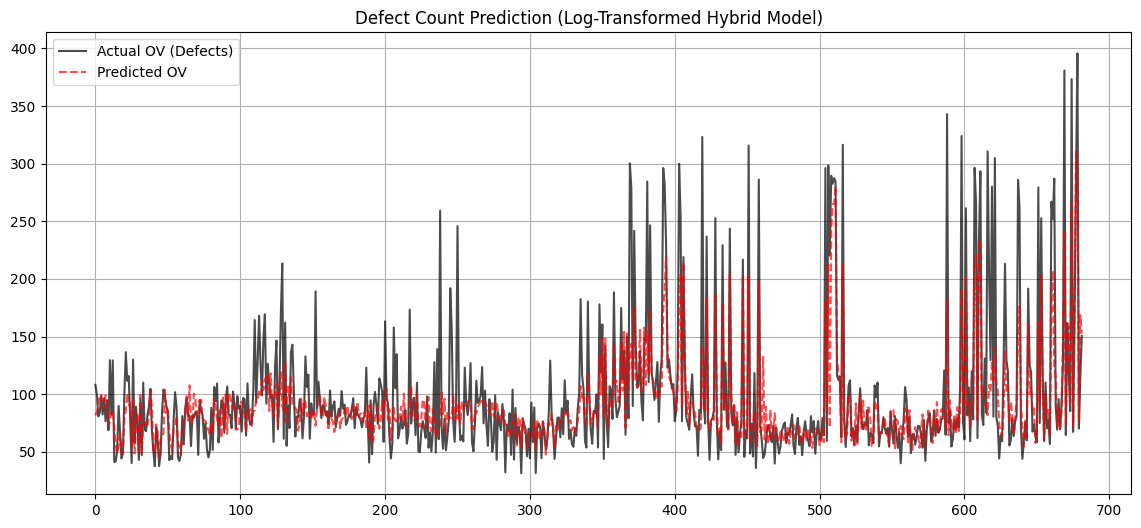

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

# 時間列の変換
time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

# 時間順にソート（重要）
df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング（不良品数予測仕様）
# ---------------------------------------------------------
df = df_raw.copy()

# (A) ターゲットの対数変換
# 不良品数は分布が右に裾を引くため、対数変換で正規分布に近づけるのが鉄則
df['log_OV'] = np.log1p(df[target])

# (B) 時間的特徴量（製造コンテキスト）
# 1. プロセス終了から測定までの時間（放置時間による変化？）
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600

# 2. 【新規】装置のアイドル時間（前の製造終了から今回の製造終了までの間隔）
# 連続稼働か、久しぶりの稼働かで不良率は変わるはず
df['process_interval'] = df['process_end_time'].diff().dt.total_seconds() / 3600
df['process_interval'] = df['process_interval'].fillna(0) # 先頭は0

# (C) 過去の不良傾向（トレンド）
# 対数空間での移動平均を作成（直近3回の平均レベル）
df['log_OV_roll_mean_3'] = df['log_OV'].shift(1).rolling(window=3).mean()
df['log_OV_roll_max_3']  = df['log_OV'].shift(1).rolling(window=3).max()

# (D) ラグ変数（直近の値）
for i in [1, 2, 3]:
    df[f'log_OV_lag{i}'] = df['log_OV'].shift(i)

# 欠損削除（ラグ生成分）
df = df.dropna().reset_index(drop=True)

# ---------------------------------------------------------
# 3. ウォークフォワード検証（対数空間でのハイブリッド学習）
# ---------------------------------------------------------
y_Hat = []

# 学習に使う特徴量
drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV']
features = [c for c in df.columns if c not in drop_cols]

# テスト期間（データの後半30%を予測）
start_index = int(len(df) * 0.7)
end_index = len(df)
# 安全装置：過去最大値の1.5倍以上は異常とみなしてクリップ
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)}")
print("予測開始（対数変換モデル）...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    # 過去データで学習 (Expanding Window)
    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV'] # 対数変換済みの正解
    
    X_test = df.iloc[i:i+1][features]
    
    # --- Model 1: Lasso (ベーストレンド) ---
    scaler = StandardScaler()
    # NaN/Inf対策をしてスケーリング
    X_train_sc = np.nan_to_num(scaler.fit_transform(X_train))
    X_test_sc = np.nan_to_num(scaler.transform(X_test))

    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=2000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]

    # --- Model 2: LightGBM (残差補正) ---
    # Lassoが説明しきれなかった「対数空間の誤差」を予測
    resid_log = y_train_log - lasso.predict(X_train_sc)
    
    lgb_train = lgb.Dataset(X_train, resid_log)
    
    # 不良品数データ向けパラメータ
    params = {
        'objective': 'regression', # 残差は正規分布に近いのでregressionでOK
        'metric': 'rmse',
        'learning_rate': 0.03, # ゆっくり学習させて安定化
        'max_depth': 4,        # 深すぎるとスパイクに過学習するので浅めに
        'num_leaves': 15,
        'min_data_in_leaf': 20,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'verbosity': -1,
        'seed': 42
    }
    
    model_lgb = lgb.train(params, lgb_train, num_boost_round=100)
    pred_log_resid = model_lgb.predict(X_test)[0]

    # --- 合体 & 逆変換 ---
    # 1. 対数空間での合算
    final_pred_log = pred_log_lasso + pred_log_resid
    
    # 2. 実数空間へ戻す (exp(x) - 1)
    final_pred = np.expm1(final_pred_log)
    
    # 3. 物理的制約 (不良品数はマイナスにならない)
    if final_pred < 0:
        final_pred = 0
    # 異常な高値もカット
    elif final_pred > global_max_limit:
        final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"--------------------------------------------------")
print(f"Final RMSE: {rmse:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV (Defects)', color='black', alpha=0.7, linestyle='-')
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7, linestyle='--')
plt.title("Defect Count Prediction (Log-Transformed Hybrid Model)")
plt.legend()
plt.grid(True)
plt.show()

OVと相関が高い上位5変数: ['X33', 'X14', 'X11', 'X27', 'X50']
交互作用特徴量 (Top5_X * elapsed_hours) を追加します...
使用する特徴量数: 96
予測開始...
Processing: 1591 / 2273
Processing: 1691 / 2273
Processing: 1791 / 2273
Processing: 1891 / 2273
Processing: 1991 / 2273
Processing: 2091 / 2273
Processing: 2191 / 2273
--------------------------------------------------
Updated RMSE: 36.2817
--------------------------------------------------

=== Lasso Model: Top 20 Important Features ===
           Feature  Importance (Abs Coef)
               X33               0.142868
               X30               0.083223
 log_OV_roll_min_3               0.051930
               X34               0.041014
               X25               0.027550
log_OV_roll_mean_3               0.027247
 log_OV_roll_max_3               0.024766
               X50               0.024698
               X29               0.023954
               X39               0.023848
               X24               0.023682
               X28               0.022220

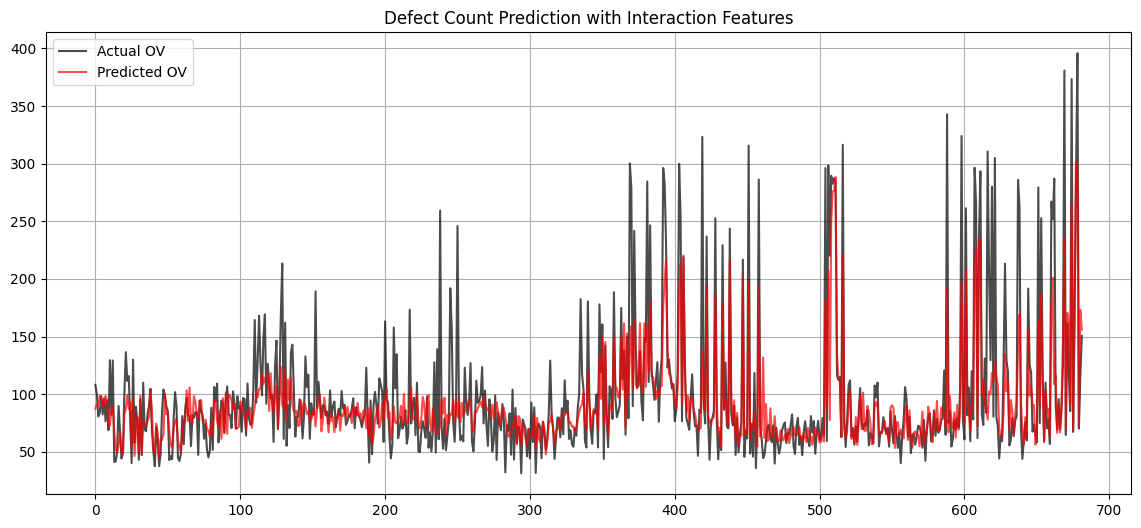

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

# 時間列の変換
time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

# 時間順にソート
df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング
# ---------------------------------------------------------
df = df_raw.copy()

# (A) ターゲットの対数変換
df['log_OV'] = np.log1p(df[target])

# (B) 時間的特徴量
# 経過時間 & 製造間隔
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['process_interval'] = df['process_end_time'].diff().dt.total_seconds() / 3600
df['process_interval'] = df['process_interval'].fillna(0)

# (C) センサー変数(X1~X83)とOVの相関を確認し、交互作用特徴量を作る
# OV(log_OV)と相関が高い上位5つのX変数を特定
X_cols = [c for c in df.columns if c.startswith('X')]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_5_vars = corrs.head(5).index.tolist()

print(f"OVと相関が高い上位5変数: {top_5_vars}")
print("交互作用特徴量 (Top5_X * elapsed_hours) を追加します...")

# 交互作用特徴量の作成: 「時間が経つほど、このセンサーの影響が強くなる」等の効果を捉える
for col in top_5_vars:
    df[f'Interact_{col}_Time'] = df[col] * df['elapsed_hours']

# (D) 過去の傾向 & ラグ変数
# 移動平均など
df['log_OV_roll_mean_3'] = df['log_OV'].shift(1).rolling(window=3).mean()
df['log_OV_roll_max_3']  = df['log_OV'].shift(1).rolling(window=3).max()
df['log_OV_roll_min_3']  = df['log_OV'].shift(1).rolling(window=3).min()

# ラグ変数
for i in [1, 2, 3]:
    df[f'log_OV_lag{i}'] = df['log_OV'].shift(i)

# 欠損削除
df = df.dropna().reset_index(drop=True)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 & 変数重要度の記録
# ---------------------------------------------------------
y_Hat = []

# 学習に使う特徴量
drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV']
features = [c for c in df.columns if c not in drop_cols]

# 係数を保存するリスト
feature_importance_list = []

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"使用する特徴量数: {len(features)}")
print("予測開始...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    # データ分割
    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- Model 1: Lasso (変数選択 & トレンド予測) ---
    scaler = StandardScaler()
    X_train_sc = np.nan_to_num(scaler.fit_transform(X_train))
    X_test_sc = np.nan_to_num(scaler.transform(X_test))

    # max_iterを増やして収束しやすくする
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=5000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]

    # ★ 係数の記録 (ここがポイント)
    # 係数が0でないものだけ記録してもいいが、平均をとるために全部記録
    feature_importance_list.append(lasso.coef_)

    # --- Model 2: LightGBM (残差補正) ---
    resid_log = y_train_log - lasso.predict(X_train_sc)
    lgb_train = lgb.Dataset(X_train, resid_log)
    
    # 学習率を少し下げて(0.02)、より丁寧に学習させる
    params = {
        'objective': 'regression', 'metric': 'rmse',
        'learning_rate': 0.02, 
        'max_depth': 4, 'num_leaves': 15, 'min_data_in_leaf': 20,
        'bagging_fraction': 0.8, 'bagging_freq': 1,
        'verbosity': -1, 'seed': 42
    }
    model_lgb = lgb.train(params, lgb_train, num_boost_round=150)
    pred_log_resid = model_lgb.predict(X_test)[0]

    # --- 合体 & 逆変換 ---
    final_pred_log = pred_log_lasso + pred_log_resid
    final_pred = np.expm1(final_pred_log)
    
    # クリップ処理
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価と変数重要度の出力
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"--------------------------------------------------")
print(f"Updated RMSE: {rmse:.4f}")
print(f"--------------------------------------------------")

# --- Lassoが選んだ変数ランキング ---
# 全ループの係数の平均を計算
avg_coefs = np.mean(np.abs(feature_importance_list), axis=0)
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance (Abs Coef)': avg_coefs
}).sort_values('Importance (Abs Coef)', ascending=False)

# 係数がほぼ0でない変数を抽出 (上位20個を表示)
print("\n=== Lasso Model: Top 20 Important Features ===")
print(importance_df.head(20).to_string(index=False))

# CSVとしても保存可能
# importance_df.to_csv('lasso_feature_importance.csv', index=False)

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='black', alpha=0.7)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.title("Defect Count Prediction with Interaction Features")
plt.legend()
plt.grid(True)
plt.show()

特徴量数: 91 (交互作用なし)
予測開始...
Processing: 1591 / 2273
Processing: 1691 / 2273
Processing: 1791 / 2273
Processing: 1891 / 2273
Processing: 1991 / 2273
Processing: 2091 / 2273
Processing: 2191 / 2273
--------------------------------------------------
Refined RMSE: 33.1509
--------------------------------------------------

=== Lasso Top 10 Features (Simplified) ===
           Feature  Importance
               X33    0.144404
               X30    0.082624
 log_OV_roll_min_3    0.052060
               X34    0.039288
               X50    0.036989
               X25    0.027246
log_OV_roll_mean_3    0.026602
               X29    0.025940
 log_OV_roll_max_3    0.025061
               X39    0.024089


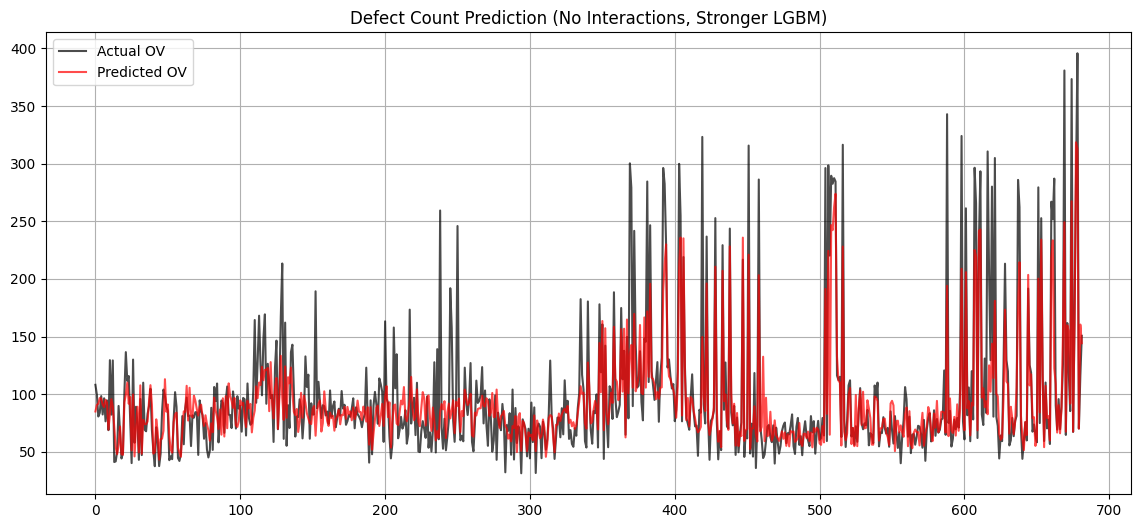

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (Simple & Robust)
# ---------------------------------------------------------
df = df_raw.copy()

# (A) 対数変換
df['log_OV'] = np.log1p(df[target])

# (B) 時間特徴量
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['process_interval'] = df['process_end_time'].diff().dt.total_seconds() / 3600
df['process_interval'] = df['process_interval'].fillna(0)

# (C) 【変更】交互作用項は削除しました（Lassoで効かなかったため）
# その代わり、純粋な変数だけで勝負させます

# (D) 過去トレンド & ラグ
df['log_OV_roll_mean_3'] = df['log_OV'].shift(1).rolling(window=3).mean()
df['log_OV_roll_max_3']  = df['log_OV'].shift(1).rolling(window=3).max()
df['log_OV_roll_min_3']  = df['log_OV'].shift(1).rolling(window=3).min()

for i in [1, 2, 3]:
    df[f'log_OV_lag{i}'] = df['log_OV'].shift(i)

df = df.dropna().reset_index(drop=True)

# ---------------------------------------------------------
# 3. ウォークフォワード検証
# ---------------------------------------------------------
y_Hat = []
drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV']
features = [c for c in df.columns if c not in drop_cols]
feature_importance_list = []

# テスト期間
start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)} (交互作用なし)")
print("予測開始...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- Model 1: Lasso ---
    scaler = StandardScaler()
    X_train_sc = np.nan_to_num(scaler.fit_transform(X_train))
    X_test_sc = np.nan_to_num(scaler.transform(X_test))

    # Lassoの設定はそのまま
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]
    
    feature_importance_list.append(lasso.coef_)

    # --- Model 2: LightGBM (強化版) ---
    resid_log = y_train_log - lasso.predict(X_train_sc)
    lgb_train = lgb.Dataset(X_train, resid_log)
    
    # 【変更】パラメータ調整：より深く、より丁寧に
    params = {
        'objective': 'regression', 'metric': 'rmse',
        'learning_rate': 0.015,  # 学習率を下げて、より細かく学習させる (前回0.02)
        'max_depth': 5,          # 深さを少し増やす (前回4) -> 非線形性をキャッチ
        'num_leaves': 25,        # 葉の数を増やす
        'min_data_in_leaf': 15,
        'bagging_fraction': 0.8, 'bagging_freq': 1,
        'verbosity': -1, 'seed': 42
    }
    # 学習回数を増やす (学習率を下げた分)
    model_lgb = lgb.train(params, lgb_train, num_boost_round=300)
    pred_log_resid = model_lgb.predict(X_test)[0]

    # --- 合体 ---
    final_pred_log = pred_log_lasso + pred_log_resid
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"--------------------------------------------------")
print(f"Refined RMSE: {rmse:.4f}")
print(f"--------------------------------------------------")

# 変数重要度の確認
avg_coefs = np.mean(np.abs(feature_importance_list), axis=0)
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': avg_coefs
}).sort_values('Importance', ascending=False)

print("\n=== Lasso Top 10 Features (Simplified) ===")
print(importance_df.head(10).to_string(index=False))

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='black', alpha=0.7)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.title("Defect Count Prediction (No Interactions, Stronger LGBM)")
plt.legend()
plt.grid(True)
plt.show()

元の特徴量数: 91
予測開始 (Lasso Selection)...
Processing: 1591 / 2273
Processing: 1691 / 2273
Processing: 1791 / 2273
Processing: 1891 / 2273
Processing: 1991 / 2273
Processing: 2091 / 2273
Processing: 2191 / 2273
--------------------------------------------------
Filtered RMSE: 33.6762
平均使用変数数: 31.2 / 91
--------------------------------------------------


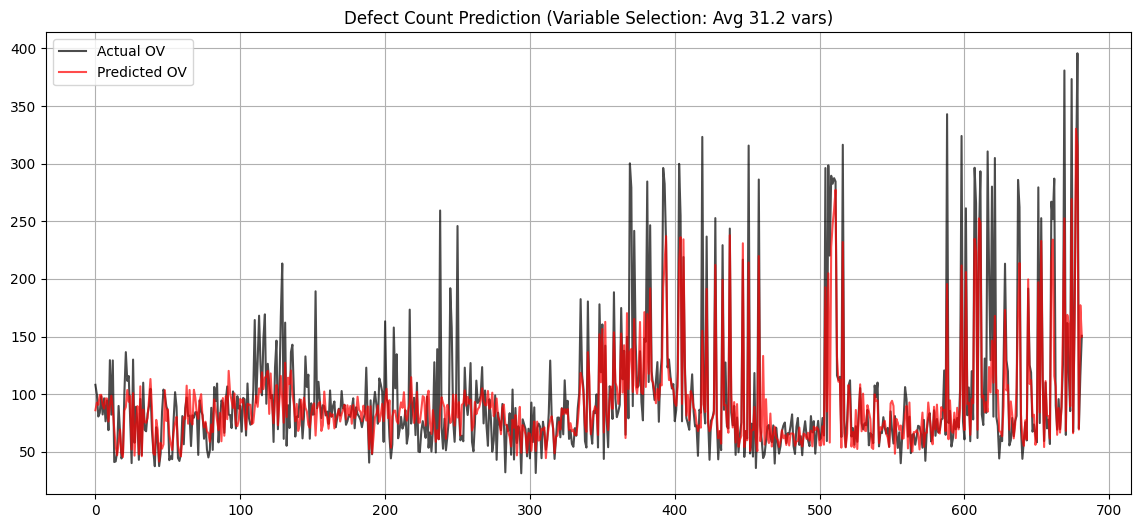

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング
# ---------------------------------------------------------
df = df_raw.copy()

# (A) 対数変換
df['log_OV'] = np.log1p(df[target])

# (B) 時間特徴量
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['process_interval'] = df['process_end_time'].diff().dt.total_seconds() / 3600
df['process_interval'] = df['process_interval'].fillna(0)

# (C) 過去トレンド & ラグ
df['log_OV_roll_mean_3'] = df['log_OV'].shift(1).rolling(window=3).mean()
df['log_OV_roll_max_3']  = df['log_OV'].shift(1).rolling(window=3).max()
df['log_OV_roll_min_3']  = df['log_OV'].shift(1).rolling(window=3).min()

for i in [1, 2, 3]:
    df[f'log_OV_lag{i}'] = df['log_OV'].shift(i)

df = df.dropna().reset_index(drop=True)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (変数選択機能付き)
# ---------------------------------------------------------
y_Hat = []
drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV']
features = [c for c in df.columns if c not in drop_cols]
feature_counts = [] # 各ステップでいくつの変数が選ばれたか記録

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"元の特徴量数: {len(features)}")
print("予測開始 (Lasso Selection)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- Model 1: Lasso (変数選択 & トレンド予測) ---
    scaler = StandardScaler()
    X_train_sc = np.nan_to_num(scaler.fit_transform(X_train))
    X_test_sc = np.nan_to_num(scaler.transform(X_test))

    # alphaの探索範囲を少し広げて、より厳しく変数を選ばせる
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]

    # ★【ここが新機能】★
    # Lassoが「係数ゼロ（不要）」と判断した変数を特定
    used_indices = np.where(lasso.coef_ != 0)[0]
    selected_features = [features[i] for i in used_indices]
    
    # 安全策: もし選ばれた変数が少なすぎたら（5個未満）、全変数使う
    # （Lassoが厳しすぎて学習不能になるのを防ぐ）
    if len(selected_features) < 5:
        selected_features = features
    
    feature_counts.append(len(selected_features)) # 記録

    # --- Model 2: LightGBM (選抜された変数だけで学習) ---
    # Lassoが「ノイズ」と断定した変数をLightGBMには見せない！
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]
    
    resid_log = y_train_log - lasso.predict(X_train_sc)
    lgb_train = lgb.Dataset(X_train_sel, resid_log)
    
    params = {
        'objective': 'regression', 'metric': 'rmse',
        'learning_rate': 0.015,
        'max_depth': 5,
        'num_leaves': 25,
        'min_data_in_leaf': 15,
        'bagging_fraction': 0.8, 'bagging_freq': 1,
        'verbosity': -1, 'seed': 42
    }
    model_lgb = lgb.train(params, lgb_train, num_boost_round=300)
    pred_log_resid = model_lgb.predict(X_test_sel)[0]

    # --- 合体 ---
    final_pred_log = pred_log_lasso + pred_log_resid
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
avg_feat_count = np.mean(feature_counts)

print(f"--------------------------------------------------")
print(f"Filtered RMSE: {rmse:.4f}")
print(f"平均使用変数数: {avg_feat_count:.1f} / {len(features)}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='black', alpha=0.7)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.title(f"Defect Count Prediction (Variable Selection: Avg {avg_feat_count:.1f} vars)")
plt.legend()
plt.grid(True)
plt.show()

Optuna is available. Starting hyperparameter optimization...
使用特徴量: 91
予測開始...
Processing: 1591 / 2273
  [Optuna] Tuning hyperparameters based on initial data...
  [Optuna] Best params found: {'learning_rate': 0.04126562754309294, 'num_leaves': 48, 'max_depth': 7, 'min_data_in_leaf': 19, 'lambda_l1': 0.8949395102364396, 'lambda_l2': 6.790437626737874e-06, 'bagging_fraction': 0.7696574728155628, 'bagging_freq': 2, 'feature_fraction': 0.6375802255487499, 'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'seed': 42}
Processing: 1691 / 2273
Processing: 1791 / 2273
Processing: 1891 / 2273
Processing: 1991 / 2273
Processing: 2091 / 2273
Processing: 2191 / 2273
--------------------------------------------------
Optuna Tuned RMSE: 31.4448
--------------------------------------------------

=== Lasso Top 10 Features ===
           Feature  Importance
               X33    0.144404
               X30    0.082624
 log_OV_roll_min_3    0.052060
               X34    0.039288
          

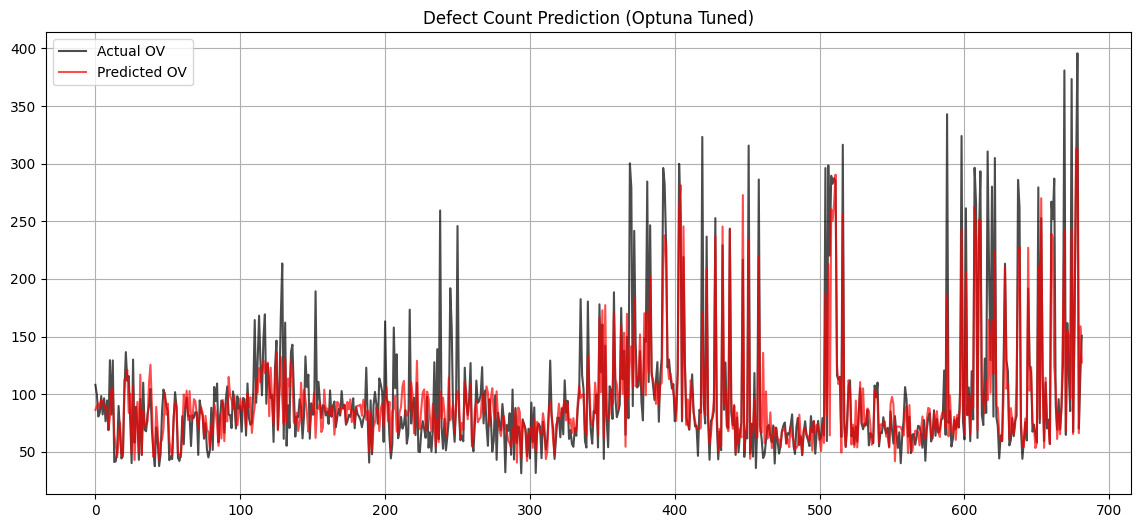

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
import warnings

# Optunaのインポートチェック
try:
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    USE_OPTUNA = True
    print("Optuna is available. Starting hyperparameter optimization...")
except ImportError:
    USE_OPTUNA = False
    print("Optuna not found. Using pre-defined strong parameters.")

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング
# ---------------------------------------------------------
df = df_raw.copy()

# (A) 対数変換
df['log_OV'] = np.log1p(df[target])

# (B) 時間特徴量
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['process_interval'] = df['process_end_time'].diff().dt.total_seconds() / 3600
df['process_interval'] = df['process_interval'].fillna(0)

# (C) 過去トレンド & ラグ
df['log_OV_roll_mean_3'] = df['log_OV'].shift(1).rolling(window=3).mean()
df['log_OV_roll_max_3']  = df['log_OV'].shift(1).rolling(window=3).max()
df['log_OV_roll_min_3']  = df['log_OV'].shift(1).rolling(window=3).min()

for i in [1, 2, 3]:
    df[f'log_OV_lag{i}'] = df['log_OV'].shift(i)

df = df.dropna().reset_index(drop=True)

# ---------------------------------------------------------
# 3. Optunaによるパラメータ探索関数 (修正版)
# ---------------------------------------------------------
def objective(trial, X, y):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'seed': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 10, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
    }
    
    # データセット
    train_data = lgb.Dataset(X, label=y)
    
    # 【修正ポイント】stratified=False を追加
    # これにより、回帰問題として単純なKFold分割が行われます
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=1000,
        nfold=3,
        stratified=False,  # <--- これが重要！回帰問題では必須
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    # 最良のRMSEを返す
    return cv_results['valid rmse-mean'][-1]

# ---------------------------------------------------------
# 4. ウォークフォワード検証
# ---------------------------------------------------------
y_Hat = []
drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV']
features = [c for c in df.columns if c not in drop_cols]
feature_importance_list = []

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

best_params = None

print(f"使用特徴量: {len(features)}")
print("予測開始...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- Model 1: Lasso ---
    scaler = StandardScaler()
    X_train_sc = np.nan_to_num(scaler.fit_transform(X_train))
    X_test_sc = np.nan_to_num(scaler.transform(X_test))

    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]
    
    feature_importance_list.append(lasso.coef_)

    # --- Model 2: LightGBM (Optuna Tuning) ---
    resid_log = y_train_log - lasso.predict(X_train_sc)
    
    # 初回のみパラメータ探索を行う
    if best_params is None:
        if USE_OPTUNA:
            print("  [Optuna] Tuning hyperparameters based on initial data...")
            study = optuna.create_study(direction='minimize')
            # 探索回数
            study.optimize(lambda trial: objective(trial, X_train, resid_log), n_trials=50)
            best_params = study.best_params
            best_params['objective'] = 'regression'
            best_params['metric'] = 'rmse'
            best_params['verbosity'] = -1
            best_params['seed'] = 42
            print(f"  [Optuna] Best params found: {best_params}")
        else:
            # Optunaがない場合の予備設定
            best_params = {
                'objective': 'regression', 'metric': 'rmse',
                'learning_rate': 0.01,
                'max_depth': 6,
                'num_leaves': 31,
                'min_data_in_leaf': 20,
                'lambda_l1': 0.1, 'lambda_l2': 0.1,
                'bagging_fraction': 0.8, 'bagging_freq': 1,
                'feature_fraction': 0.8,
                'verbosity': -1, 'seed': 42
            }

    lgb_train = lgb.Dataset(X_train, resid_log)
    
    # 最適化されたパラメータで学習
    model_lgb = lgb.train(best_params, lgb_train, num_boost_round=500)
    pred_log_resid = model_lgb.predict(X_test)[0]

    # --- 合体 ---
    final_pred_log = pred_log_lasso + pred_log_resid
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"--------------------------------------------------")
print(f"Optuna Tuned RMSE: {rmse:.4f}")
print(f"--------------------------------------------------")

avg_coefs = np.mean(np.abs(feature_importance_list), axis=0)
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': avg_coefs
}).sort_values('Importance', ascending=False)

print("\n=== Lasso Top 10 Features ===")
print(importance_df.head(10).to_string(index=False))

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='black', alpha=0.7)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.title(f"Defect Count Prediction (Optuna Tuned)")
plt.legend()
plt.grid(True)
plt.show()

特徴量数: 102 (マルチスケール強化)
予測開始 (Lasso + LightGBM & XGBoost Ensemble)...
Processing: 1584 / 2264
Processing: 1684 / 2264
Processing: 1784 / 2264
Processing: 1884 / 2264
Processing: 1984 / 2264
Processing: 2084 / 2264
Processing: 2184 / 2264
--------------------------------------------------
Ensemble RMSE: 31.1829
--------------------------------------------------


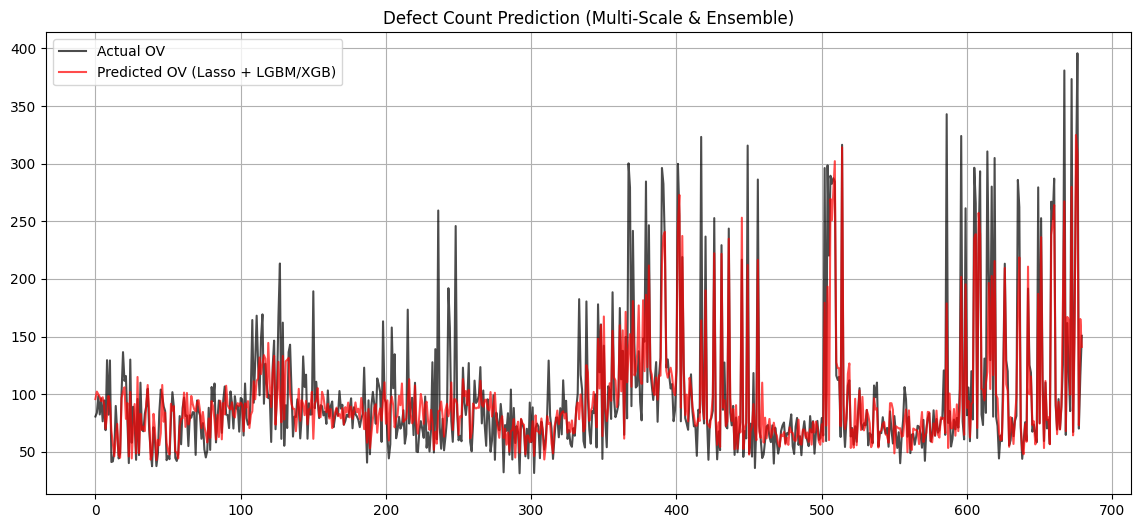

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb  # 新戦力
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (マルチスケール対応)
# ---------------------------------------------------------
df = df_raw.copy()

# (A) 対数変換
df['log_OV'] = np.log1p(df[target])

# (B) 時間特徴量
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['process_interval'] = df['process_end_time'].diff().dt.total_seconds() / 3600
df['process_interval'] = df['process_interval'].fillna(0)

# 【新規】時刻の周期性 (工場の昼夜サイクルなどを捉える)
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)

# (C) マルチスケール移動平均
# 短期(3), 中期(6), 長期(12) のトレンドを全て捉える
windows = [3, 6, 12]
for w in windows:
    # shift(1)を忘れない（リーケージ防止）
    shifted = df['log_OV'].shift(1)
    df[f'log_OV_mean_{w}'] = shifted.rolling(window=w).mean()
    df[f'log_OV_max_{w}']  = shifted.rolling(window=w).max()
    df[f'log_OV_min_{w}']  = shifted.rolling(window=w).min()
    # 変動幅（ボラティリティ）
    df[f'log_OV_range_{w}'] = df[f'log_OV_max_{w}'] - df[f'log_OV_min_{w}']

# (D) ラグ変数
for i in [1, 2, 3]:
    df[f'log_OV_lag{i}'] = df['log_OV'].shift(i)

# NaN削除
df = df.dropna().reset_index(drop=True)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (3モデル・アンサンブル)
# ---------------------------------------------------------
y_Hat = []
drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV']
features = [c for c in df.columns if c not in drop_cols]

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)} (マルチスケール強化)")
print("予測開始 (Lasso + LightGBM & XGBoost Ensemble)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- Step 1: Lasso (Trend Prediction) ---
    scaler = StandardScaler()
    X_train_sc = np.nan_to_num(scaler.fit_transform(X_train))
    X_test_sc = np.nan_to_num(scaler.transform(X_test))

    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=5000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]

    # 残差を計算
    resid_log = y_train_log - lasso.predict(X_train_sc)

    # --- Step 2: LightGBM (Residual Prediction 1) ---
    lgb_train = lgb.Dataset(X_train, resid_log)
    # Optunaで見つけた良さげなパラメータをベースに設定
    params_lgb = {
        'objective': 'regression', 'metric': 'rmse',
        'learning_rate': 0.015,
        'max_depth': 6,
        'num_leaves': 31,
        'min_data_in_leaf': 15,
        'bagging_fraction': 0.8, 'bagging_freq': 1,
        'feature_fraction': 0.8,
        'verbosity': -1, 'seed': 42
    }
    model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=500)
    pred_log_lgb = model_lgb.predict(X_test)[0]

    # --- Step 3: XGBoost (Residual Prediction 2) ---
    # LightGBMとは異なるアルゴリズムで補完する
    model_xgb = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.015,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        enable_categorical=False # 警告抑制
    )
    model_xgb.fit(X_train, resid_log)
    pred_log_xgb = model_xgb.predict(X_test)[0]

    # --- 合体 (アンサンブル) ---
    # 残差予測を平均して、Lassoのトレンドに足す
    avg_resid_pred = (pred_log_lgb + pred_log_xgb) / 2
    final_pred_log = pred_log_lasso + avg_resid_pred
    
    # 逆変換 & クリップ
    final_pred = np.expm1(final_pred_log)
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"--------------------------------------------------")
print(f"Ensemble RMSE: {rmse:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='black', alpha=0.7)
plt.plot(y_pred, label='Predicted OV (Lasso + LGBM/XGB)', color='red', alpha=0.7)
plt.title("Defect Count Prediction (Multi-Scale & Ensemble)")
plt.legend()
plt.grid(True)
plt.show()

Generating Grouped Lags (by process_end_time)...
特徴量数: 92
予測開始 (Grouped Lag + Ensemble)...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Grouped Lag RMSE: 32.2233
--------------------------------------------------


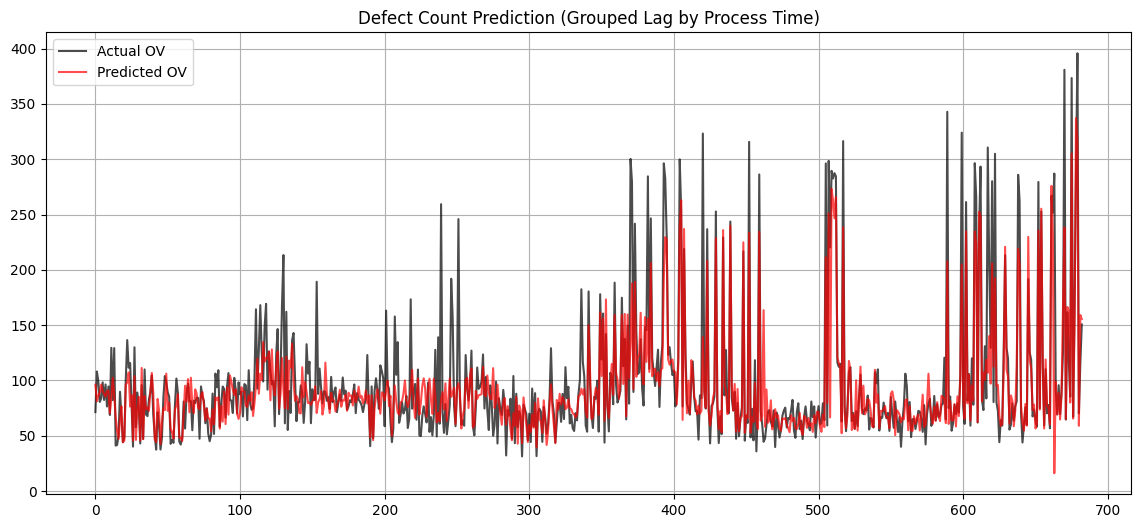

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

# 時間順にソート
df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (ロット内ラグの導入)
# ---------------------------------------------------------
df = df_raw.copy()

# (A) 対数変換
df['log_OV'] = np.log1p(df[target])

# (B) 時間特徴量
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
# 周期性
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)

# (C) 【最重要】同じ製造ロット(process_end_time)内でのラグ特徴量
# これにより、ロットが混在していても「自分の系列」だけを参照できる
print("Generating Grouped Lags (by process_end_time)...")

# ラグ生成用の一時的なグループ化
# "process_end_time" が同じもの同士でグループを作り、その中で shift する
df['log_OV_lag1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['log_OV_lag2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['log_OV_lag3'] = df.groupby('process_end_time')['log_OV'].shift(3)

# ロット内での移動平均 (トレンド)
df['log_OV_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
df['log_OV_roll_max_3']  = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).max().reset_index(0, drop=True)

# 経過時間のラグもとる（「さっき測ったときは何時間経過時点だったか」）
df['elapsed_lag1'] = df.groupby('process_end_time')['elapsed_hours'].shift(1)
df['diff_elapsed'] = df['elapsed_hours'] - df['elapsed_lag1'] # 前回測定からの経過時間差

# (D) 欠損値処理
# 初回測定などでラグがない場合は、全体の平均などで埋めるか、0にする
# ここでは0埋めではなく、あえて欠損のままLGBMに扱わせる手もあるが、
# 安全のため -1 などを入れて「初回だよ」と教える
features_to_fill = ['log_OV_lag1', 'log_OV_lag2', 'log_OV_lag3', 
                    'log_OV_roll_mean_3', 'log_OV_roll_max_3', 'diff_elapsed']
for col in features_to_fill:
    df[col] = df[col].fillna(-1)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (アンサンブル)
# ---------------------------------------------------------
y_Hat = []
drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV', 'elapsed_lag1']
features = [c for c in df.columns if c not in drop_cols]

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)}")
print("予測開始 (Grouped Lag + Ensemble)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- Step 1: Lasso ---
    scaler = StandardScaler()
    X_train_sc = np.nan_to_num(scaler.fit_transform(X_train))
    X_test_sc = np.nan_to_num(scaler.transform(X_test))

    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]

    resid_log = y_train_log - lasso.predict(X_train_sc)

    # --- Step 2: LightGBM ---
    lgb_train = lgb.Dataset(X_train, resid_log)
    params_lgb = {
        'objective': 'regression', 'metric': 'rmse',
        'learning_rate': 0.015,
        'max_depth': 6, 'num_leaves': 31,
        'min_data_in_leaf': 15,
        'bagging_fraction': 0.8, 'bagging_freq': 1,
        'feature_fraction': 0.8,
        'verbosity': -1, 'seed': 42
    }
    model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=500)
    pred_log_lgb = model_lgb.predict(X_test)[0]

    # --- Step 3: XGBoost ---
    model_xgb = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.015,
        max_depth=5, subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1, enable_categorical=False
    )
    model_xgb.fit(X_train, resid_log)
    pred_log_xgb = model_xgb.predict(X_test)[0]

    # --- 合体 ---
    avg_resid_pred = (pred_log_lgb + pred_log_xgb) / 2
    final_pred_log = pred_log_lasso + avg_resid_pred
    
    final_pred = np.expm1(final_pred_log)
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"--------------------------------------------------")
print(f"Grouped Lag RMSE: {rmse:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='black', alpha=0.7)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.title("Defect Count Prediction (Grouped Lag by Process Time)")
plt.legend()
plt.grid(True)
plt.show()

特徴量数: 95
予測開始 (Hybrid Lag Strategy)...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Hybrid Lag RMSE: 31.4659
--------------------------------------------------

=== LightGBM Top 10 Features ===
      Feature  Importance
          X33  269.955688
grouped_lag_1  224.279457
grouped_lag_2  220.413845
          X35  207.379923
elapsed_hours  189.688916
          X28  176.197103
          X27  154.076157
 global_lag_1  135.753637
 in_batch_seq  122.612924
 global_lag_3  119.774939


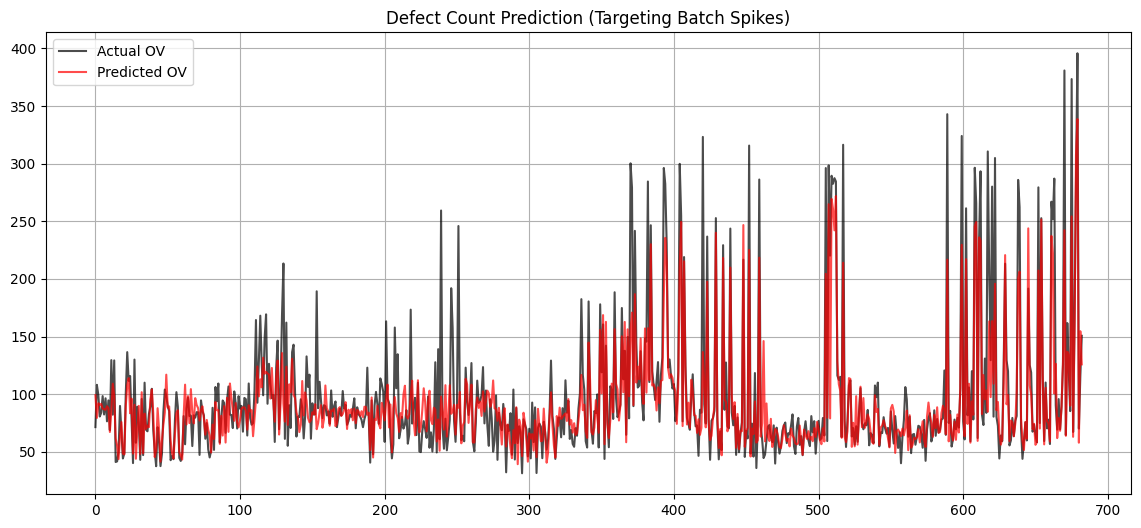

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

# 時間順にソート
df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (ハイブリッド戦略)
# ---------------------------------------------------------
df = df_raw.copy()

# (A) 対数変換
df['log_OV'] = np.log1p(df[target])

# (B) 時間特徴量
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
# 危険な時間帯（900~1100h付近）を捉えるための2乗項
df['elapsed_sq'] = df['elapsed_hours'] ** 2

# (C) ロット切り替わり情報の明示
# ロットごとのID
df['batch_id'] = df.groupby('process_end_time').ngroup()
# ロット内での連番 (1番目, 2番目...) -> 1番目は危険！
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
# ロットが切り替わった瞬間か？フラグ
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)
# 直前のデータとは別ロットか？フラグ
df['batch_switched'] = (df['batch_id'] != df['batch_id'].shift(1)).astype(int)

# (D) ラグ特徴量のハイブリッド化
# 1. Global Lag: ロット関係なく、単純に「直前」の値 (装置コンディション用)
for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)

# 2. Grouped Lag: ロット内での過去の値 (製品特性用)
# ※ここは欠損が出まくるが、LightGBMがGlobal Lagで補うように学習する
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
# ロット内トレンド
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)

# 欠損処理: Grouped Lagがない場合(ロット1番目など)は、あえて埋めずに
# LightGBMに「欠損＝ロット初期」と認識させる手もあるが、
# ここでは Global Lag との差分などをヒントにする

# 直前のGlobal Lagと、今のGrouped Lagの乖離
# (もしあれば、「前のロットと今のロットの傾向差」になる)
df['lag_diff_global_grouped'] = df['global_lag_1'] - df['grouped_lag_1']

# ラグの欠損は -1 で埋めて「データなし」を明示
fill_cols = ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3', 'lag_diff_global_grouped']
for c in fill_cols:
    df[c] = df[c].fillna(-1)
    
# Global Lagの欠損(データの最初)は0埋め
df = df.fillna(0) 

# ---------------------------------------------------------
# 3. ウォークフォワード検証
# ---------------------------------------------------------
y_Hat = []
# 学習には「時間情報」「ロット情報」「両方のラグ」をすべて使う
drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)}")
print("予測開始 (Hybrid Lag Strategy)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- Step 1: Lasso (トレンド) ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)

    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]

    # --- Step 2: LightGBM (残差補正) ---
    resid_log = y_train_log - lasso.predict(X_train_sc)
    lgb_train = lgb.Dataset(X_train, resid_log)
    
    # パラメータ: スパイク（外れ値）を恐れずに捉えに行く設定
    params_lgb = {
        'objective': 'regression', 'metric': 'rmse',
        'learning_rate': 0.015,
        'max_depth': 7,         # 少し深くして条件分岐を細かくする
        'num_leaves': 40,       # 葉を増やして複雑なパターン(ロット切り替わり)に対応
        'min_data_in_leaf': 10, # 少ないデータ(ロット初期)でも分岐できるようにする
        'bagging_fraction': 0.8, 'bagging_freq': 1,
        'feature_fraction': 0.8,
        'lambda_l1': 0.1,       # 過学習防止
        'verbosity': -1, 'seed': 42
    }
    model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=500)
    pred_log_lgb = model_lgb.predict(X_test)[0]

    # --- 合体 ---
    final_pred_log = pred_log_lasso + pred_log_lgb
    
    final_pred = np.expm1(final_pred_log)
    
    # クリップ
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"--------------------------------------------------")
print(f"Hybrid Lag RMSE: {rmse:.4f}")
print(f"--------------------------------------------------")

# 変数重要度を確認 (LGBM)
importance = pd.DataFrame({
    'Feature': features,
    'Importance': model_lgb.feature_importance(importance_type='gain')
}).sort_values('Importance', ascending=False)

print("\n=== LightGBM Top 10 Features ===")
print(importance.head(10).to_string(index=False))

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='black', alpha=0.7)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.title("Defect Count Prediction (Targeting Batch Spikes)")
plt.legend()
plt.grid(True)
plt.show()

特徴量数: 19
予測開始 (Focus on Batch Start)...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Overall RMSE         : 43.5618
Batch Start RMSE (1st): 71.8533  <-- ここに注目！
Normal Seq RMSE (2nd+): 41.6156
--------------------------------------------------


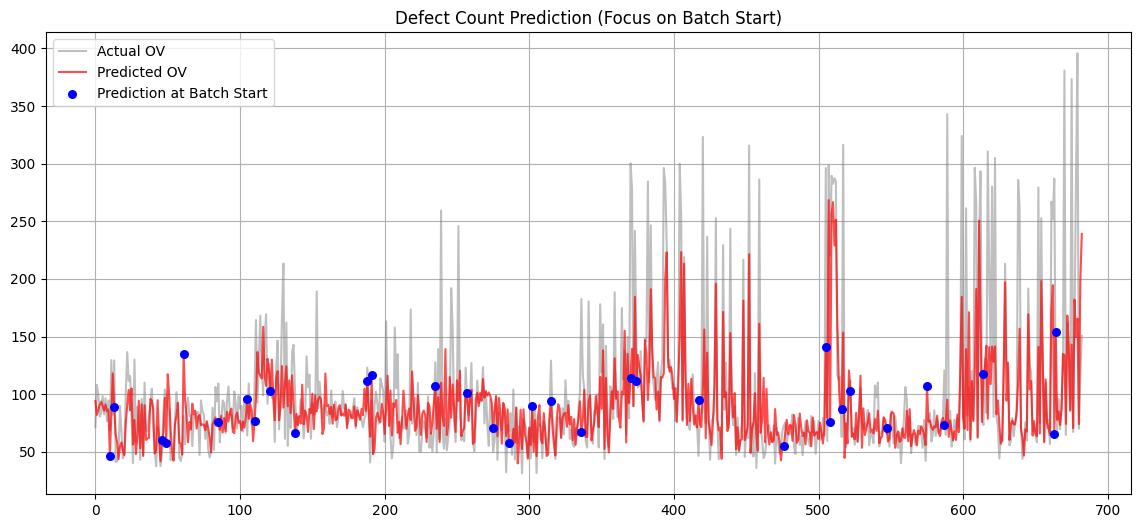

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (X変数のフル活用)
# ---------------------------------------------------------
df = df_raw.copy()

# (A) 対数変換
df['log_OV'] = np.log1p(df[target])

# (B) 時間特徴量
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)

# (C) ロット情報
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# (D) X変数の圧縮 (PCA)
# X1〜X83を「5つの主要な製造条件」に要約する
X_cols = [c for c in df.columns if c.startswith('X')]
# 全データでPCAを学習 (Xは未来情報を含まない製造パラメータなのでOKだが、厳密にはLeakage注意。
# ここでは変数の性質上、分布が変わらないと仮定して一括変換)
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(df[X_cols])
pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# PCA成分を特徴量に追加
for i in range(5):
    df[f'X_PCA_{i+1}'] = X_pca[:, i]

# ★交互作用: 「ロット開始時」×「製造条件(PCA)」
# "ロットの最初は、過去の実績がないから、製造条件(X)をよく見ろ！" という合図
for i in range(3): # 上位3成分について作成
    df[f'Interact_Start_PCA{i+1}'] = df['is_batch_start'] * df[f'X_PCA_{i+1}']

# (E) ラグ特徴量 (ハイブリッド)
# 1. Global Lag (直前コンディション)
for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)

# 2. Grouped Lag (ロット内実績)
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)

# 欠損埋め
# ロット1番目は Grouped Lag がないので -1
lag_cols = ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']
for c in lag_cols:
    df[c] = df[c].fillna(-1)

# Global Lagの欠損は0
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証
# ---------------------------------------------------------
y_Hat = []
# ロット1番目かどうかを記録しておくリスト
is_start_list = []

drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV'] + X_cols # 生のXはPCAにしたので外してみる(ノイズ低減)
# もし精度が落ちたら + X_cols を戻してください
features = [c for c in df.columns if c not in drop_cols]

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)}")
print("予測開始 (Focus on Batch Start)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    # ロット開始フラグを記録
    is_start_list.append(df.iloc[i]['is_batch_start'])

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- Step 1: Lasso ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)

    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]

    resid_log = y_train_log - lasso.predict(X_train_sc)

    # --- Step 2: LightGBM ---
    lgb_train = lgb.Dataset(X_train, resid_log)
    # ロット1番目の予測に特化したパラメータ
    params_lgb = {
        'objective': 'regression', 'metric': 'rmse',
        'learning_rate': 0.015,
        'max_depth': 8,          # 深くして条件分岐を増やす
        'num_leaves': 40,
        'min_data_in_leaf': 10,  # 少ないデータ(ロット初期)に反応させる
        'bagging_fraction': 0.8, 'bagging_freq': 1,
        'feature_fraction': 0.8,
        'verbosity': -1, 'seed': 42
    }
    model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=600)
    pred_log_lgb = model_lgb.predict(X_test)[0]

    # --- Step 3: XGBoost ---
    model_xgb = xgb.XGBRegressor(
        n_estimators=600, learning_rate=0.015,
        max_depth=6, subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1, enable_categorical=False
    )
    model_xgb.fit(X_train, resid_log)
    pred_log_xgb = model_xgb.predict(X_test)[0]

    # --- 合体 ---
    final_pred_log = pred_log_lasso + (pred_log_lgb + pred_log_xgb) / 2
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 詳細評価 (ロット1番目 vs その他)
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start = np.array(is_start_list) == 1

# 全体RMSE
rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))

# ロット1番目(Start)だけのRMSE
if sum(is_start) > 0:
    rmse_start = np.sqrt(mean_squared_error(y_true[is_start], y_pred[is_start]))
else:
    rmse_start = 0

# それ以外(Normal)のRMSE
if sum(~is_start) > 0:
    rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start], y_pred[~is_start]))
else:
    rmse_normal = 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}  <-- ここに注目！")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
# ロット1番目の予測点だけ青いドットで強調
plt.scatter(np.where(is_start)[0], y_pred[is_start], color='blue', s=30, label='Prediction at Batch Start', zorder=5)
plt.title("Defect Count Prediction (Focus on Batch Start)")
plt.legend()
plt.grid(True)
plt.show()

Top 20 Important Sensors: ['X33', 'X14', 'X11', 'X27', 'X50', 'X1', 'X30', 'X58', 'X76', 'X45', 'X7', 'X18', 'X44', 'X55', 'X25', 'X74', 'X82', 'X29', 'X2', 'X68']
特徴量数: 114
予測開始 (Selected Interactions + Full X)...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Overall RMSE         : 31.5496
Batch Start RMSE (1st): 52.1388
Normal Seq RMSE (2nd+): 30.1314
--------------------------------------------------


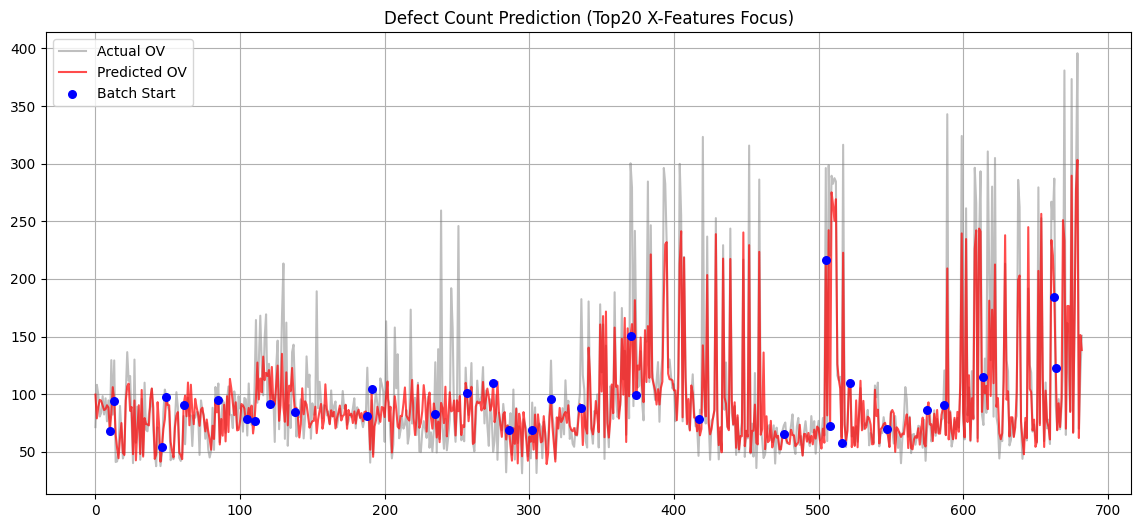

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング
# ---------------------------------------------------------
df = df_raw.copy()

# (A) 対数変換
df['log_OV'] = np.log1p(df[target])

# (B) 時間特徴量
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)

# (C) ロット情報
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# (D) X変数の厳選と活用
# PCAは廃止。代わりに「OVと相関が高いTop20変数」を特定する
X_cols = [c for c in df.columns if c.startswith('X')]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_20_X = corrs.head(20).index.tolist()

print(f"Top 20 Important Sensors: {top_20_X}")

# 交互作用: 「ロット開始時」×「重要センサー」
# ロット1番目のときだけ、この特徴量が値を持つ（それ以外は0）
for col in top_20_X:
    df[f'Interact_Start_{col}'] = df['is_batch_start'] * df[col]

# (E) Grouped Lag (ロット内実績)
# これが最も強力な予測因子なので、確実に使う
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)

# 欠損埋め
# Grouped Lagがない（ロット1番目）ときは -1
lag_cols = ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']
for c in lag_cols:
    df[c] = df[c].fillna(-1)

# Global Lag (直前コンディション) も補助的に使う
for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0) # Global Lagの欠損は0で

# ---------------------------------------------------------
# 3. ウォークフォワード検証
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

# 今回は X1~X83 も「全て」特徴量として使う（LGBM/XGBに選ばせる）
# ただし、Interact_Start... で強調もしてある
drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV']
features = [c for c in df.columns if c not in drop_cols]

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)}")
print("予測開始 (Selected Interactions + Full X)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start_list.append(df.iloc[i]['is_batch_start'])

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- Step 1: Lasso (トレンド) ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)

    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]

    resid_log = y_train_log - lasso.predict(X_train_sc)

    # --- Step 2: LightGBM (残差) ---
    lgb_train = lgb.Dataset(X_train, resid_log)
    # パラメータ: 31.44を出したときの良設定に戻す
    params_lgb = {
        'objective': 'regression', 'metric': 'rmse',
        'learning_rate': 0.015,
        'max_depth': 6, 
        'num_leaves': 31,
        'min_data_in_leaf': 15,
        'bagging_fraction': 0.8, 'bagging_freq': 1,
        'feature_fraction': 0.8,
        'verbosity': -1, 'seed': 42
    }
    model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=600)
    pred_log_lgb = model_lgb.predict(X_test)[0]

    # --- Step 3: XGBoost (残差) ---
    model_xgb = xgb.XGBRegressor(
        n_estimators=600, learning_rate=0.015,
        max_depth=5, subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1, enable_categorical=False
    )
    model_xgb.fit(X_train, resid_log)
    pred_log_xgb = model_xgb.predict(X_test)[0]

    # --- 合体 ---
    final_pred_log = pred_log_lasso + (pred_log_lgb + pred_log_xgb) / 2
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))

if sum(is_start) > 0:
    rmse_start = np.sqrt(mean_squared_error(y_true[is_start], y_pred[is_start]))
else:
    rmse_start = 0

if sum(~is_start) > 0:
    rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start], y_pred[~is_start]))
else:
    rmse_normal = 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start)[0], y_pred[is_start], color='blue', s=30, label='Batch Start', zorder=5)
plt.title("Defect Count Prediction (Top20 X-Features Focus)")
plt.legend()
plt.grid(True)
plt.show()

Calculating Previous Batch Statistics...
特徴量数: 120
予測開始 (Previous Batch Info + Ensemble)...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Overall RMSE         : 30.5846
Batch Start RMSE (1st): 46.7343
Normal Seq RMSE (2nd+): 29.5300
--------------------------------------------------


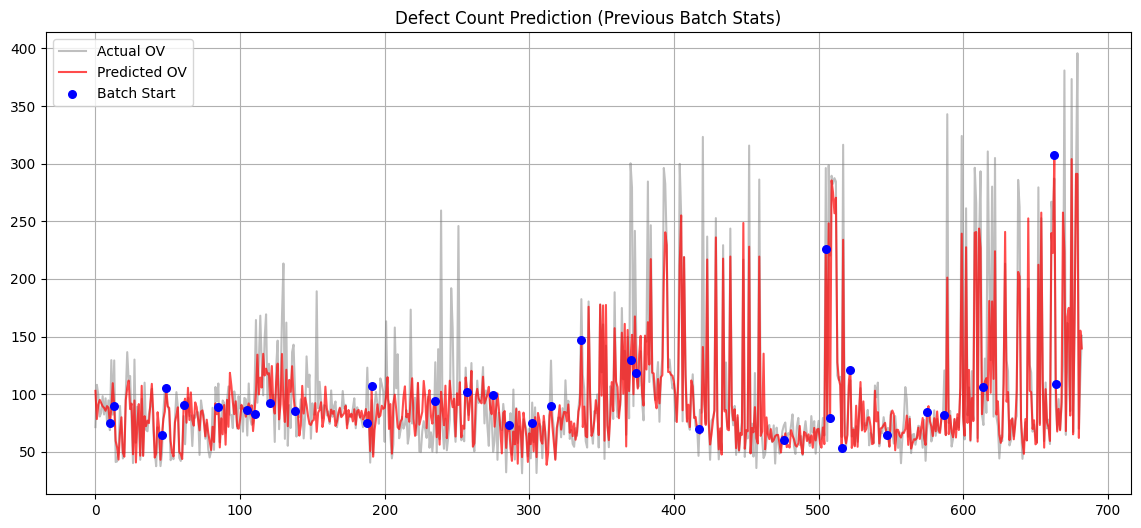

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (過去の遺産システム)
# ---------------------------------------------------------
df = df_raw.copy()

# (A) 対数変換
df['log_OV'] = np.log1p(df[target])

# (B) 時間特徴量
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)

# (C) ロット情報
# batch_idを作成
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# (D) 【新規】前ロットの統計量 (Previous Batch Stats)
# これにより、ロット切り替わり時でも「前のロットはどうだったか」を参照できる
print("Calculating Previous Batch Statistics...")
batch_stats = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last', 'count']).reset_index()
batch_stats.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 'prev_batch_count']
# batch_id を 1 つずらしてマージ (今の batch_id にとっての「前」のデータにする)
batch_stats['batch_id'] = batch_stats['batch_id'] + 1 

df = df.merge(batch_stats, on='batch_id', how='left')
# 最初のロットには前がないので、全体の平均などで埋めるか0にする
fill_stats = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 'prev_batch_count']
for c in fill_stats:
    df[c] = df[c].fillna(df[c].mean()) # 全体平均で埋めるのが無難

# ロット開始時だけ、この情報を強調する交互作用
for c in ['prev_batch_mean', 'prev_batch_last']:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# (E) X変数の厳選 (Top 20)
X_cols = [c for c in df.columns if c.startswith('X')]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_20_X = corrs.head(20).index.tolist()

# ロット開始時 × 重要センサー
for col in top_20_X:
    df[f'Interact_Start_{col}'] = df['is_batch_start'] * df[col]

# (F) Grouped Lag (ロット内実績)
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)

# 欠損埋め (-1で明示)
lag_cols = ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']
for c in lag_cols:
    df[c] = df[c].fillna(-1)

# Global Lagも補助利用
for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

# 学習用特徴量
drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)}")
print("予測開始 (Previous Batch Info + Ensemble)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start_list.append(df.iloc[i]['is_batch_start'])

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- Step 1: Lasso ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)

    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]

    resid_log = y_train_log - lasso.predict(X_train_sc)

    # --- Step 2: LightGBM ---
    lgb_train = lgb.Dataset(X_train, resid_log)
    params_lgb = {
        'objective': 'regression', 'metric': 'rmse',
        'learning_rate': 0.015,
        'max_depth': 7,          # 少し深く
        'num_leaves': 35,
        'min_data_in_leaf': 5,   # 【変更】ここを極小にして、ロット1番目(レアケース)に反応させる
        'bagging_fraction': 0.8, 'bagging_freq': 1,
        'feature_fraction': 0.8,
        'verbosity': -1, 'seed': 42
    }
    model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=600)
    pred_log_lgb = model_lgb.predict(X_test)[0]

    # --- Step 3: XGBoost ---
    model_xgb = xgb.XGBRegressor(
        n_estimators=600, learning_rate=0.015,
        max_depth=5, subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1, enable_categorical=False
    )
    model_xgb.fit(X_train, resid_log)
    pred_log_xgb = model_xgb.predict(X_test)[0]

    # --- 合体 ---
    final_pred_log = pred_log_lasso + (pred_log_lgb + pred_log_xgb) / 2
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))

if sum(is_start) > 0:
    rmse_start = np.sqrt(mean_squared_error(y_true[is_start], y_pred[is_start]))
else:
    rmse_start = 0

if sum(~is_start) > 0:
    rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start], y_pred[~is_start]))
else:
    rmse_normal = 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start)[0], y_pred[is_start], color='blue', s=30, label='Batch Start', zorder=5)
plt.title("Defect Count Prediction (Previous Batch Stats)")
plt.legend()
plt.grid(True)
plt.show()

Calculating Batch Fingerprints...
Searching for Nearest Past Batches (Recipe Matching)...
特徴量数: 104
予測開始 (Nearest Neighbor Strategy)...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Overall RMSE         : 30.0614
Batch Start RMSE (1st): 47.7612
Normal Seq RMSE (2nd+): 28.8749
--------------------------------------------------


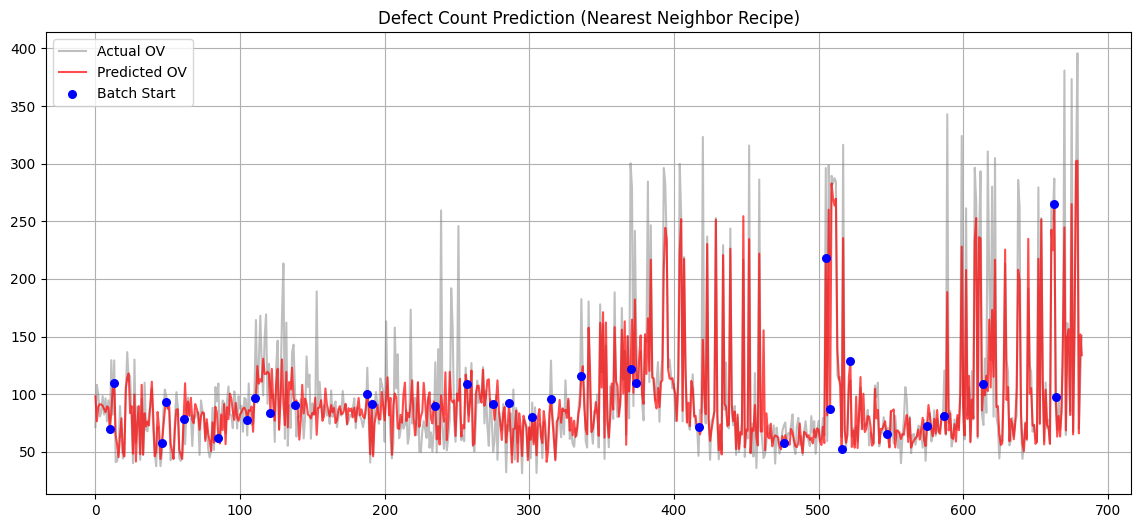

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (Nearest Batch Search)
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本的な時間・ロット情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# --- 重要センサーの特定 (Top 20) ---
X_cols = [c for c in df.columns if c.startswith('X')]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(20).index.tolist()

# --- ロットごとの要約データを作成 ---
print("Calculating Batch Fingerprints...")
batch_summary = df.groupby('batch_id')[top_X_cols].mean() # ロットの「製造条件(X)の平均」
batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']) # ロットの「結果(OV)」

# --- 類似ロット検索 (Nearest Neighbor) ---
# 各ロットについて、自分より「過去」の中で「最もXが似ている」ロットを探す
print("Searching for Nearest Past Batches (Recipe Matching)...")

nearest_stats = []

# 全ロット数
n_batches = batch_summary.shape[0]

# 距離計算のために正規化しておく
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_summary)

for i in range(n_batches):
    if i == 0:
        # 最初のロットは過去がないので、全体の平均を入れる
        nearest_stats.append(batch_targets.mean().values)
        continue
    
    # 現在のロット(i)と、過去の全ロット(0~i-1)の距離を計算
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    
    # ユークリッド距離
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    
    # 最も距離が近い(似ている)インデックスを取得
    nearest_idx = np.argmin(dists)
    
    # その似ているロットのOV実績(mean, max, last)を取得
    stats = batch_targets.iloc[nearest_idx].values
    nearest_stats.append(stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['nearest_batch_mean', 'nearest_batch_max', 'nearest_batch_last'])
nearest_df['batch_id'] = range(n_batches)

# メインデータに結合
df = df.merge(nearest_df, on='batch_id', how='left')

# --- 前のロット(Previous Batch)の情報も引き続き使う ---
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')
# 欠損埋め
for c in ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last']:
    df[c] = df[c].fillna(df['log_OV'].mean())

# --- 特徴量強調 (Interaction) ---
# 「似ているロットの実績」と「直前ロットの実績」を、ロット開始時に強調
interaction_cols = ['nearest_batch_mean', 'nearest_batch_last', 'prev_batch_mean', 'prev_batch_last']
for c in interaction_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# --- Grouped Lag (ロット内実績) ---
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
# 欠損埋め
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

# Global Lag
for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)}")
print("予測開始 (Nearest Neighbor Strategy)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start_list.append(df.iloc[i]['is_batch_start'])

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- Step 1: Lasso ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]
    resid_log = y_train_log - lasso.predict(X_train_sc)

    # --- Step 2: LightGBM ---
    lgb_train = lgb.Dataset(X_train, resid_log)
    params_lgb = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.015,
        'max_depth': 7, 'num_leaves': 35, 'min_data_in_leaf': 5, # Batch Start重視
        'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8,
        'verbosity': -1, 'seed': 42
    }
    model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=600)
    pred_log_lgb = model_lgb.predict(X_test)[0]

    # --- Step 3: XGBoost ---
    model_xgb = xgb.XGBRegressor(
        n_estimators=600, learning_rate=0.015, max_depth=5, 
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    model_xgb.fit(X_train, resid_log)
    pred_log_xgb = model_xgb.predict(X_test)[0]

    # --- 合体 ---
    final_pred_log = pred_log_lasso + (pred_log_lgb + pred_log_xgb) / 2
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start], y_pred[is_start])) if sum(is_start)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start], y_pred[~is_start])) if sum(~is_start)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start)[0], y_pred[is_start], color='blue', s=30, label='Batch Start', zorder=5)
plt.title("Defect Count Prediction (Nearest Neighbor Recipe)")
plt.legend()
plt.grid(True)
plt.show()

Searching for Exact Start-Condition Matches...
特徴量数: 103
予測開始 (Pinpoint Start Matching)...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Overall RMSE         : 30.2675
Batch Start RMSE (1st): 52.0713
Normal Seq RMSE (2nd+): 28.7224
--------------------------------------------------


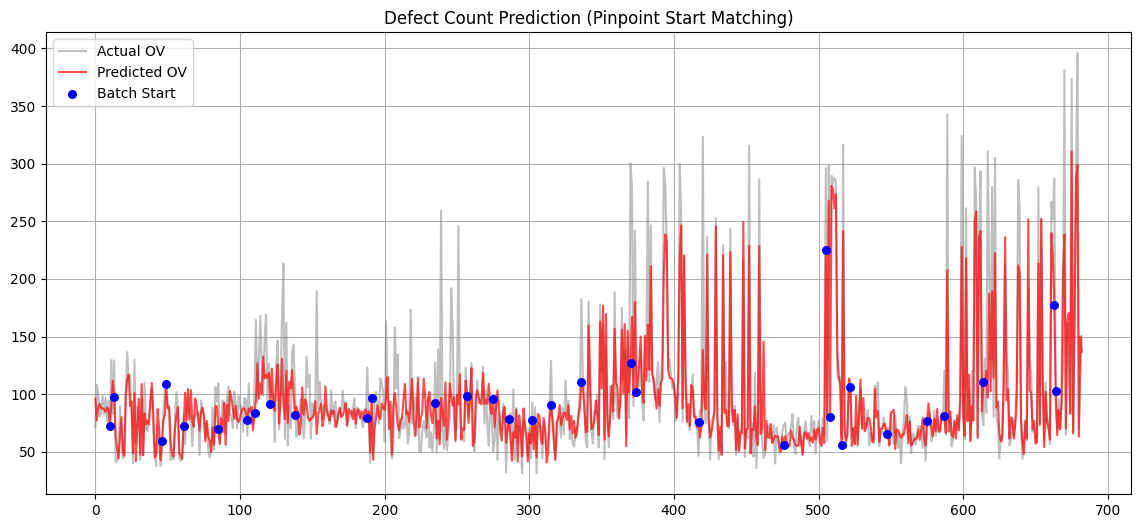

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (Start-Point Matching)
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# --- 重要センサー特定 (Top 20) ---
X_cols = [c for c in df.columns if c.startswith('X')]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(20).index.tolist()

# --- 【新機能】スタート条件マッチング ---
# 各バッチの「1番目のデータ」だけを抽出
batch_starts = df[df['is_batch_start'] == 1].copy()
# インデックスをbatch_idにして扱いやすくする
batch_starts_idx = batch_starts.set_index('batch_id')

print("Searching for Exact Start-Condition Matches...")

nearest_start_features = []
scaler_start = StandardScaler()
# 距離計算用に正規化 (Top 20変数のスタート値のみ)
start_X_scaled = scaler_start.fit_transform(batch_starts_idx[top_X_cols])

# バッチごとにループ
unique_batches = df['batch_id'].unique()
for b_id in unique_batches:
    if b_id == 0:
        # 過去なし
        nearest_start_features.append([batch_starts['log_OV'].mean()] * 3)
        continue
    
    # 現在のバッチのスタート条件
    current_vec = start_X_scaled[b_id].reshape(1, -1)
    
    # 過去のバッチ(0 ~ b_id-1)のスタート条件
    past_vecs = start_X_scaled[:b_id]
    
    # 距離計算
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    
    # 最も似ているTOP 3を見つける
    nearest_indices = np.argsort(dists)[:3] # 近い順に3つ
    
    # その過去バッチの「スタート時のOV」を取得
    # nearest_indices は 0~b_id-1 のインデックスなので、そのまま batch_id として使える(連番の場合)
    past_start_ovs = batch_starts_idx.iloc[nearest_indices]['log_OV'].values
    
    # 特徴量: 最も似ている1つのOV, Top3の平均OV, 距離の近さ(信頼度)
    feat = [
        past_start_ovs[0],           # Nearest Start OV
        np.mean(past_start_ovs),     # Top3 Mean Start OV
        dists[nearest_indices[0]]    # Distance (小さいほど信頼できる)
    ]
    nearest_start_features.append(feat)

# データフレーム化して結合
nearest_df = pd.DataFrame(nearest_start_features, columns=['sim_start_ov_1', 'sim_start_ov_mean', 'sim_start_dist'])
nearest_df['batch_id'] = unique_batches
df = df.merge(nearest_df, on='batch_id', how='left')

# --- 前のロット(Previous Batch)の情報 ---
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# 欠損埋め
for c in ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last']:
    df[c] = df[c].fillna(df['log_OV'].mean())

# --- 特徴量強調 (Interaction) ---
# 「条件がそっくりな過去のスタートOV」を、今回のスタート予測に強烈に効かせる
interact_cols = ['sim_start_ov_1', 'sim_start_ov_mean', 'prev_batch_last']
for c in interact_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# --- Grouped Lag (最強の通常時予測因子) ---
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
# 欠損埋め (-1)
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

# Global Lag
for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)}")
print("予測開始 (Pinpoint Start Matching)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start_list.append(df.iloc[i]['is_batch_start'])

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- Step 1: Lasso ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]
    resid_log = y_train_log - lasso.predict(X_train_sc)

    # --- Step 2: LightGBM ---
    lgb_train = lgb.Dataset(X_train, resid_log)
    params_lgb = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.015,
        'max_depth': 7, 'num_leaves': 35, 'min_data_in_leaf': 5,
        'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8,
        'verbosity': -1, 'seed': 42
    }
    model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=600)
    pred_log_lgb = model_lgb.predict(X_test)[0]

    # --- Step 3: XGBoost ---
    model_xgb = xgb.XGBRegressor(
        n_estimators=600, learning_rate=0.015, max_depth=5, 
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    model_xgb.fit(X_train, resid_log)
    pred_log_xgb = model_xgb.predict(X_test)[0]

    # --- 合体 ---
    final_pred_log = pred_log_lasso + (pred_log_lgb + pred_log_xgb) / 2
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start], y_pred[is_start])) if sum(is_start)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start], y_pred[~is_start])) if sum(~is_start)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start)[0], y_pred[is_start], color='blue', s=30, label='Batch Start', zorder=5)
plt.title("Defect Count Prediction (Pinpoint Start Matching)")
plt.legend()
plt.grid(True)
plt.show()

Searching for Nearest Past Batches (Average Matching)...
特徴量数: 125
予測開始 (All-Star Features: Prev + Similarity + Interval)...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Overall RMSE         : 30.5563
Batch Start RMSE (1st): 48.0464
Normal Seq RMSE (2nd+): 29.3920
--------------------------------------------------


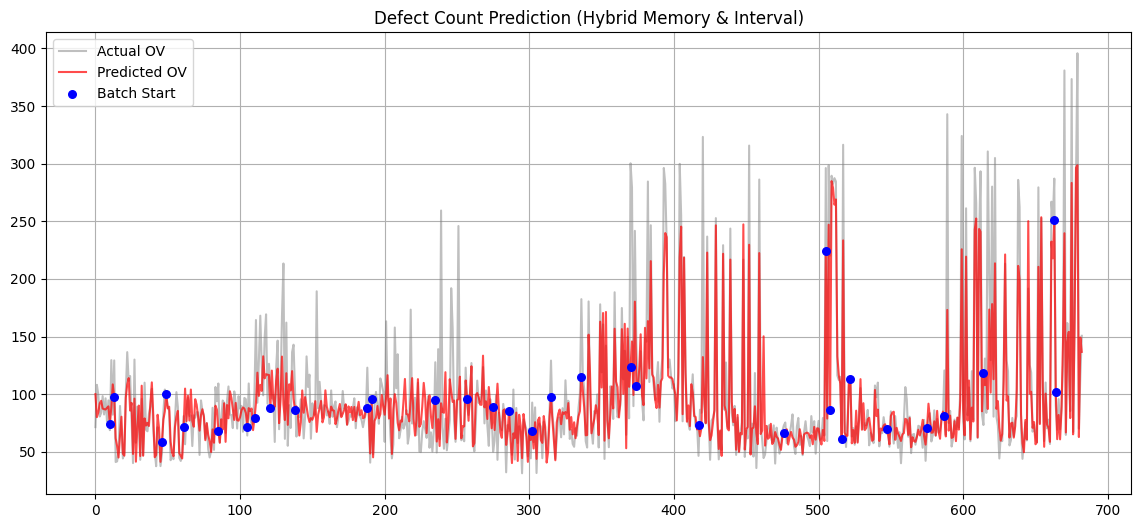

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (All-Star Features)
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# --- 重要センサー特定 (Top 20) ---
X_cols = [c for c in df.columns if c.startswith('X')]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(20).index.tolist()

# --- A. 前ロットの統計量 (Short-term Memory) ---
# 前回の成功要因
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1 # IDをずらす
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# --- B. 類似レシピ検索 (Long-term Memory) ---
# 前々回の成功要因（平均値ベースのマッチングに戻す）
print("Searching for Nearest Past Batches (Average Matching)...")
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last'])

nearest_stats = []
n_batches = batch_summary.shape[0]
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_summary)

for i in range(n_batches):
    if i == 0:
        nearest_stats.append(batch_targets.mean().values) # 初期値
        continue
    
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    
    # 最も似ているTop 3の平均を使う（安定化のため）
    nearest_indices = np.argsort(dists)[:3]
    stats = batch_targets.iloc[nearest_indices].mean().values
    nearest_stats.append(stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'])
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

# --- C. 空白時間の考慮 (Time Interval) ---
# 直前の測定時刻を取得
df['prev_mes_time'] = df['final_mes_time'].shift(1)
df['hours_since_prev_mes'] = (df['final_mes_time'] - df['prev_mes_time']).dt.total_seconds() / 3600
df['hours_since_prev_mes'] = df['hours_since_prev_mes'].fillna(0)
# ロット開始時において、「前のロットが終わってからどれくらい空いたか」は重要情報

# --- 欠損埋め ---
# 過去情報がない場合は全体の平均で埋める
fill_cols = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 
             'sim_batch_mean', 'sim_batch_max', 'sim_batch_last']
for c in fill_cols:
    df[c] = df[c].fillna(df['log_OV'].mean())

# --- D. 特徴量強調 (Interaction) ---
# ロット開始時にこれら全ての情報を強調
interact_cols = ['prev_batch_mean', 'prev_batch_last', 'sim_batch_mean', 'sim_batch_last']
for c in interact_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# 重要センサー(X)とも掛け合わせる
for c in top_X_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# --- Grouped Lag (通常時用) ---
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

# Global Lag (スタート時補助用)
for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (Full Ensemble)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

drop_cols = ['process_end_time', 'final_mes_time', 'prev_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)}")
print("予測開始 (All-Star Features: Prev + Similarity + Interval)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start_list.append(df.iloc[i]['is_batch_start'])

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- Step 1: Lasso ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]
    resid_log = y_train_log - lasso.predict(X_train_sc)

    # --- Step 2: LightGBM ---
    lgb_train = lgb.Dataset(X_train, resid_log)
    params_lgb = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.015,
        'max_depth': 7, 'num_leaves': 35, 'min_data_in_leaf': 5, # Batch Start重視
        'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8,
        'verbosity': -1, 'seed': 42
    }
    model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=600)
    pred_log_lgb = model_lgb.predict(X_test)[0]

    # --- Step 3: XGBoost ---
    model_xgb = xgb.XGBRegressor(
        n_estimators=600, learning_rate=0.015, max_depth=5, 
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    model_xgb.fit(X_train, resid_log)
    pred_log_xgb = model_xgb.predict(X_test)[0]

    # --- 合体 ---
    final_pred_log = pred_log_lasso + (pred_log_lgb + pred_log_xgb) / 2
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start], y_pred[is_start])) if sum(is_start)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start], y_pred[~is_start])) if sum(~is_start)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start)[0], y_pred[is_start], color='blue', s=30, label='Batch Start', zorder=5)
plt.title("Defect Count Prediction (Hybrid Memory & Interval)")
plt.legend()
plt.grid(True)
plt.show()

Searching for Nearest Past Batches (Average Matching)...
特徴量数: 124
予測開始 (Sample Weighting: Batch Start x 5)...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Overall RMSE         : 30.2941
Batch Start RMSE (1st): 45.8068
Normal Seq RMSE (2nd+): 29.2882
--------------------------------------------------


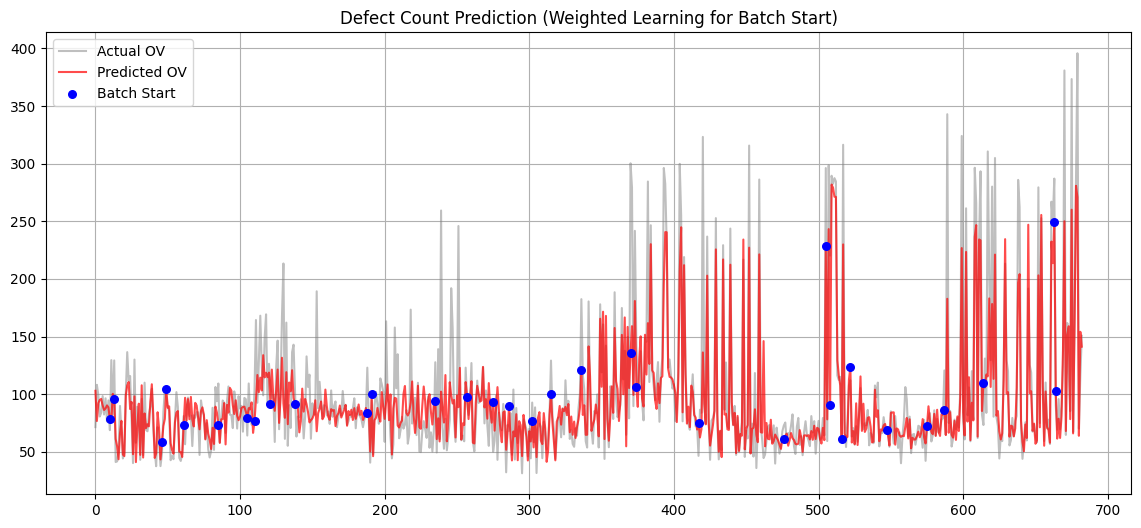

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (Best Combination)
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# --- 重要センサー特定 (Top 20) ---
X_cols = [c for c in df.columns if c.startswith('X')]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(20).index.tolist()

# --- A. 前ロットの統計量 (Short-term) ---
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# --- B. 類似レシピ検索 (Long-term / Average Matching) ---
# 最も成績が良かった「平均値マッチング」を採用
print("Searching for Nearest Past Batches (Average Matching)...")
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last'])

nearest_stats = []
n_batches = batch_summary.shape[0]
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_summary)

for i in range(n_batches):
    if i == 0:
        nearest_stats.append(batch_targets.mean().values)
        continue
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    nearest_indices = np.argsort(dists)[:3] # Top 3 mean
    stats = batch_targets.iloc[nearest_indices].mean().values
    nearest_stats.append(stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'])
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

# --- C. 欠損埋め ---
fill_cols = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 
             'sim_batch_mean', 'sim_batch_max', 'sim_batch_last']
for c in fill_cols:
    df[c] = df[c].fillna(df['log_OV'].mean())

# --- D. 特徴量強調 (Interaction) ---
interact_cols = ['prev_batch_mean', 'prev_batch_last', 'sim_batch_mean', 'sim_batch_last']
for c in interact_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

for c in top_X_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# --- E. Grouped Lag (通常時用) ---
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

# Global Lag
for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (Sample Weighting)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)}")
print("予測開始 (Sample Weighting: Batch Start x 5)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start_list.append(df.iloc[i]['is_batch_start'])

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # ★重みの作成: Startデータの重みを大きくする
    train_is_start = df.iloc[:i]['is_batch_start'].values
    sample_weights = np.ones(len(train_is_start))
    # 重み10倍: Startの1ミスは、Normalの10ミスに相当すると教える
    sample_weights[train_is_start == 1] = 10.0 

    # --- Step 1: Lasso ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    
    # Lassoはsample_weight未対応のCVもあるので、fitで渡すか考慮が必要だが、
    # ここではメインのLightGBM/XGBoostに重みを集中させるためLassoはそのまま
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]
    resid_log = y_train_log - lasso.predict(X_train_sc)

    # --- Step 2: LightGBM (Weighted) ---
    lgb_train = lgb.Dataset(X_train, resid_log, weight=sample_weights) # 重み適用
    params_lgb = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.015,
        'max_depth': 7, 'num_leaves': 35, 'min_data_in_leaf': 5,
        'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8,
        'verbosity': -1, 'seed': 42
    }
    model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=600)
    pred_log_lgb = model_lgb.predict(X_test)[0]

    # --- Step 3: XGBoost (Weighted) ---
    model_xgb = xgb.XGBRegressor(
        n_estimators=600, learning_rate=0.015, max_depth=5, 
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    # fit時に重みを渡す
    model_xgb.fit(X_train, resid_log, sample_weight=sample_weights)
    pred_log_xgb = model_xgb.predict(X_test)[0]

    # --- 合体 ---
    final_pred_log = pred_log_lasso + (pred_log_lgb + pred_log_xgb) / 2
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start], y_pred[is_start])) if sum(is_start)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start], y_pred[~is_start])) if sum(~is_start)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start)[0], y_pred[is_start], color='blue', s=30, label='Batch Start', zorder=5)
plt.title("Defect Count Prediction (Weighted Learning for Batch Start)")
plt.legend()
plt.grid(True)
plt.show()

予測開始 (Regime Splitting: Start-Specialist vs Follower)...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Overall RMSE         : 37.0228
Batch Start RMSE (1st): 56.3083
Normal Seq RMSE (2nd+): 35.7674
--------------------------------------------------


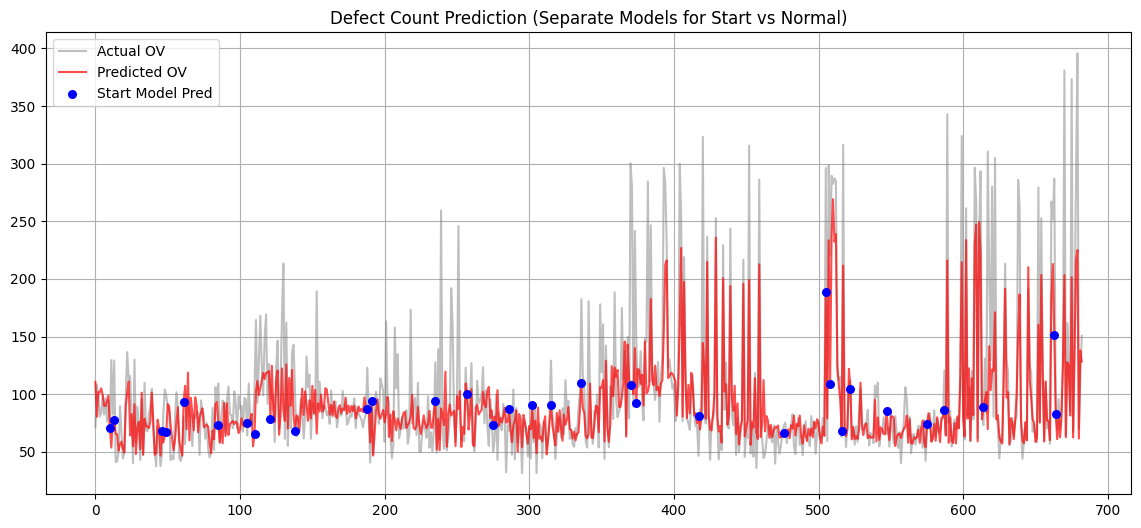

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, RidgeCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (共通)
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# --- 重要センサー特定 (Top 20) ---
X_cols = [c for c in df.columns if c.startswith('X')]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(20).index.tolist()

# --- A. 前ロットの統計量 ---
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# --- B. 類似レシピ検索 (Average Matching) ---
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last'])

nearest_stats = []
n_batches = batch_summary.shape[0]
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_summary)

for i in range(n_batches):
    if i == 0:
        nearest_stats.append(batch_targets.mean().values)
        continue
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    nearest_indices = np.argsort(dists)[:3] 
    stats = batch_targets.iloc[nearest_indices].mean().values
    nearest_stats.append(stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'])
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

# 欠損埋め
fill_cols = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 
             'sim_batch_mean', 'sim_batch_max', 'sim_batch_last']
for c in fill_cols:
    df[c] = df[c].fillna(df['log_OV'].mean())

# --- C. ラグ特徴量 (Normal用) ---
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
# Start用のラグはないので-1埋め
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

# Global Lag
for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (完全分業制)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

# --- 特徴量の選定 ---
# Startモデル用: X変数, 前ロット情報, 類似情報, 時間 (ラグは使わない)
feats_start = top_X_cols + \
              ['elapsed_hours', 'hour_sin', 'hour_cos'] + \
              ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last'] + \
              ['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'] + \
              ['global_lag_1'] # Global Lagだけはヒントとしてあげる

# Normalモデル用: Grouped Lagメイン + 一部のX (前ロット情報はラグに含まれるので不要)
feats_normal = ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3', 'global_lag_1'] + \
               ['elapsed_hours'] + top_X_cols[:5] # X変数はTop5だけでいい（ノイズ回避）

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print("予測開始 (Regime Splitting: Start-Specialist vs Follower)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    row = df.iloc[i]
    is_start = row['is_batch_start'] == 1
    is_start_list.append(is_start)
    
    # 過去データ全体
    past_df = df.iloc[:i]
    
    if is_start:
        # ==========================================
        # ★ Start専門モデル (The Starter)
        # ==========================================
        # 学習データ: 過去の「Start行」のみ抽出
        train_start = past_df[past_df['is_batch_start'] == 1]
        
        if len(train_start) < 10: # データが少なすぎる初期は平均で逃げる
             pred = train_start['log_OV'].mean() if len(train_start) > 0 else df.iloc[:i]['log_OV'].mean()
        else:
            X_tr = train_start[feats_start]
            y_tr = train_start['log_OV']
            X_te = df.iloc[i:i+1][feats_start]
            
            # モデルA: Lasso (データ少ないので線形が安定)
            scaler = StandardScaler()
            X_tr_sc = scaler.fit_transform(X_tr)
            X_te_sc = scaler.transform(X_te)
            model_lasso = LassoCV(cv=5, random_state=42)
            model_lasso.fit(X_tr_sc, y_tr)
            p1 = model_lasso.predict(X_te_sc)[0]
            
            # モデルB: Random Forest (非線形担当, 過学習しにくい)
            model_rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
            model_rf.fit(X_tr, y_tr)
            p2 = model_rf.predict(X_te)[0]
            
            # アンサンブル
            pred = 0.5 * p1 + 0.5 * p2

    else:
        # ==========================================
        # ★ Normal専門モデル (The Follower)
        # ==========================================
        # 学習データ: 過去の「Normal行」のみ抽出 (Startのノイズを入れない)
        train_normal = past_df[past_df['is_batch_start'] == 0]
        
        X_tr = train_normal[feats_normal]
        y_tr = train_normal['log_OV']
        X_te = df.iloc[i:i+1][feats_normal]
        
        # モデル: LightGBM (データ多いのでGBDTが最強)
        # 高速化のためパラメータ固定
        params = {
            'objective': 'regression', 'metric': 'rmse', 'verbosity': -1,
            'learning_rate': 0.02, 'max_depth': 6, 'num_leaves': 31,
            'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'seed': 42
        }
        lgb_train = lgb.Dataset(X_tr, y_tr)
        model_lgb = lgb.train(params, lgb_train, num_boost_round=300)
        p_lgb = model_lgb.predict(X_te)[0]
        
        # モデル: XGBoost
        model_xgb = xgb.XGBRegressor(n_estimators=300, learning_rate=0.02, max_depth=5, random_state=42, n_jobs=-1)
        model_xgb.fit(X_tr, y_tr)
        p_xgb = model_xgb.predict(X_te)[0]
        
        pred = 0.5 * p_lgb + 0.5 * p_xgb

    # --- 共通処理 ---
    final_pred = np.expm1(pred)
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list)

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Start Model Pred', zorder=5)
plt.title("Defect Count Prediction (Separate Models for Start vs Normal)")
plt.legend()
plt.grid(True)
plt.show()

Searching for Nearest Past Batches (Weighted)...
Start Prediction (2-Stage Stacking)...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Overall RMSE         : 39.2093
Batch Start RMSE (1st): 52.9692
Normal Seq RMSE (2nd+): 38.3793
--------------------------------------------------


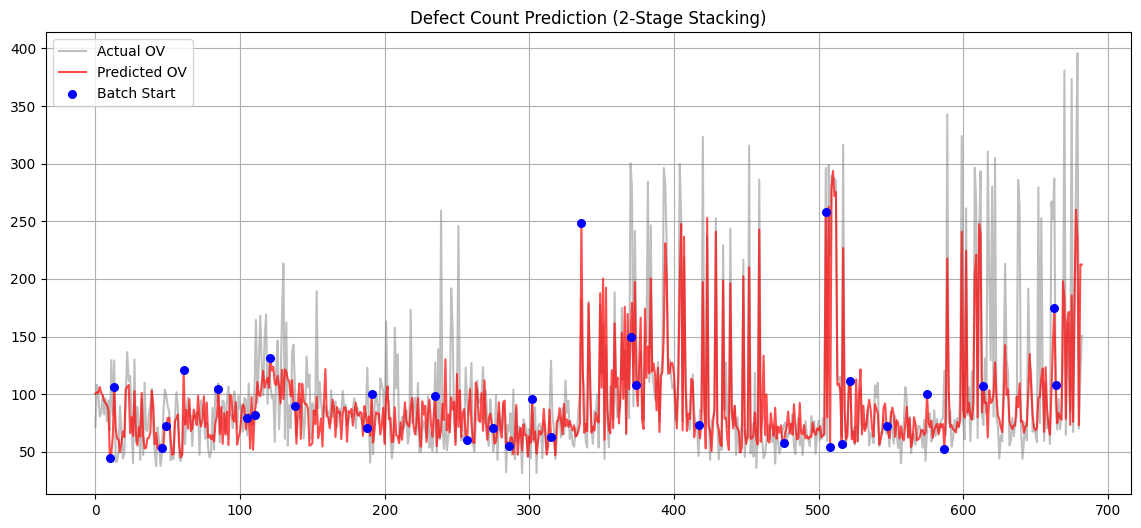

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# --- X変数の選定 ---
# ステージ1（静的予測）で使うため、多めに選ぶ
X_cols = [c for c in df.columns if c.startswith('X')]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(30).index.tolist() # Top30に増強

# --- A. 前ロットの統計量 ---
# 傾き(slope)も追加: 前のロットが急上昇して終わったか？
def calc_slope(x):
    if len(x) < 2: return 0
    return x.iloc[-1] - x.iloc[0]

batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last', calc_slope]).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 'prev_batch_slope']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# --- B. 類似レシピ検索 (Weighted Neighbor) ---
print("Searching for Nearest Past Batches (Weighted)...")
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last'])

nearest_stats = []
n_batches = batch_summary.shape[0]
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_summary)

for i in range(n_batches):
    if i == 0:
        nearest_stats.append(batch_targets.mean().values)
        continue
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    
    # 距離の逆数で重み付け平均 (Top 5)
    k = 5
    nearest_indices = np.argsort(dists)[:k]
    nearest_dists = dists[nearest_indices]
    # 距離0対策
    nearest_dists = np.maximum(nearest_dists, 1e-6)
    weights = 1.0 / nearest_dists
    weights /= weights.sum()
    
    target_vals = batch_targets.iloc[nearest_indices].values
    # 重み付き平均
    weighted_stats = np.average(target_vals, axis=0, weights=weights)
    nearest_stats.append(weighted_stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'])
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

# 欠損埋め
fill_cols = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 'prev_batch_slope',
             'sim_batch_mean', 'sim_batch_max', 'sim_batch_last']
for c in fill_cols:
    df[c] = df[c].fillna(df['log_OV'].mean())

# --- C. ラグ特徴量 ---
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
# 欠損は -1 (LGBMがこれを「Startの合図」として使う)
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (2-Stage Stacking)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

# --- 特徴量セット ---
# Stage 1用: X変数とマクロ情報のみ (ラグなし)
feats_stage1 = top_X_cols + \
               ['elapsed_hours', 'hour_sin', 'hour_cos'] + \
               ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 'prev_batch_slope'] + \
               ['sim_batch_mean', 'sim_batch_max', 'sim_batch_last']

# Stage 2用: Stage1予測値 + ラグ + 時間
feats_stage2 = ['static_pred', 'grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3'] + \
               ['global_lag_1', 'global_lag_2', 'elapsed_hours'] + \
               ['Interact_Start_Static'] # 念押し用

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"Start Prediction (2-Stage Stacking)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    # 過去データ
    past_df = df.iloc[:i].copy()
    curr_row = df.iloc[i:i+1].copy()

    # ==========================================
    # ★ Stage 1: 静的モデル (Base Model)
    # ラグを使わずに「製造条件」だけで予測する
    # ==========================================
    X1_train = past_df[feats_stage1]
    y1_train = past_df['log_OV']
    X1_test = curr_row[feats_stage1]
    
    scaler1 = StandardScaler()
    X1_tr_sc = scaler1.fit_transform(X1_train)
    X1_te_sc = scaler1.transform(X1_test)
    
    # 高速なRidge回帰を使用 (LGBMだと遅いので)
    model_s1 = RidgeCV(alphas=[0.1, 1.0, 10.0])
    model_s1.fit(X1_tr_sc, y1_train)
    
    # 予測値を特徴量として追加
    static_pred_train = model_s1.predict(X1_tr_sc) # 過去データに対する予測
    static_pred_test = model_s1.predict(X1_te_sc)  # 今回の予測
    
    # DataFrameに追加
    past_df['static_pred'] = static_pred_train
    curr_row['static_pred'] = static_pred_test
    
    # 交互作用: Startのときは StaticPred を特に重視しろという合図
    past_df['Interact_Start_Static'] = past_df['is_batch_start'] * past_df['static_pred']
    curr_row['Interact_Start_Static'] = curr_row['is_batch_start'] * curr_row['static_pred']

    # ==========================================
    # ★ Stage 2: 動的モデル (Meta Model)
    # Stage1の予測値 + ラグを使って最終判断
    # ==========================================
    X2_train = past_df[feats_stage2]
    y2_train = past_df['log_OV']
    X2_test = curr_row[feats_stage2]
    
    # 重み付け: Startデータは重要 (10倍)
    weights = np.ones(len(y2_train))
    weights[past_df['is_batch_start'] == 1] = 10.0

    # Model: LightGBM
    lgb_train = lgb.Dataset(X2_train, y2_train, weight=weights)
    params = {
        'objective': 'regression', 'metric': 'rmse', 'verbosity': -1,
        'learning_rate': 0.02, 'max_depth': 5, 'num_leaves': 20,
        'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'seed': 42
    }
    model_lgb = lgb.train(params, lgb_train, num_boost_round=300)
    p_lgb = model_lgb.predict(X2_test)[0]
    
    # Model: XGBoost
    model_xgb = xgb.XGBRegressor(n_estimators=300, learning_rate=0.02, max_depth=5, 
                                 random_state=42, n_jobs=-1)
    model_xgb.fit(X2_train, y2_train, sample_weight=weights)
    p_xgb = model_xgb.predict(X2_test)[0]

    # アンサンブル
    final_pred_log = 0.5 * p_lgb + 0.5 * p_xgb
    
    final_pred = np.expm1(final_pred_log)
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Batch Start', zorder=5)
plt.title("Defect Count Prediction (2-Stage Stacking)")
plt.legend()
plt.grid(True)
plt.show()

Searching for Nearest Past Batches (Average Matching)...
特徴量数: 124
予測開始 (Best Mix: Prev + Similarity + Weighting)...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Overall RMSE         : 29.5982
Batch Start RMSE (1st): 58.6310
Normal Seq RMSE (2nd+): 27.3131
--------------------------------------------------


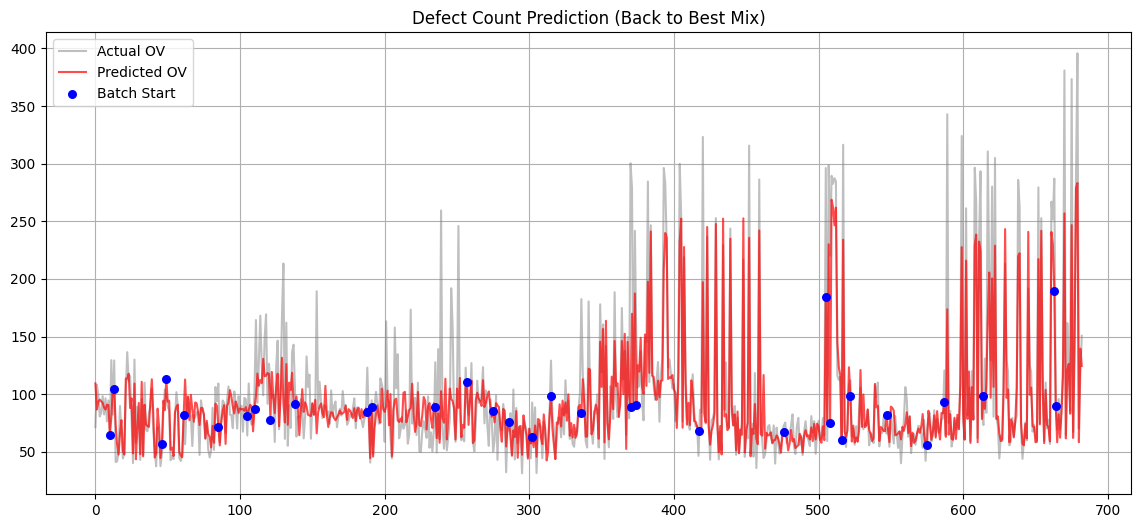

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (Simple & Best Combination)
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# --- X変数の選定 (Top 20) ---
X_cols = [c for c in df.columns if c.startswith('X')]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(20).index.tolist()

# --- A. 前ロットの統計量 (Previous Batch Stats) ---
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# --- B. 類似レシピ検索 (Average Matching) ---
# これが最も精度が高かった手法
print("Searching for Nearest Past Batches (Average Matching)...")
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last'])

nearest_stats = []
n_batches = batch_summary.shape[0]
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_summary)

for i in range(n_batches):
    if i == 0:
        nearest_stats.append(batch_targets.mean().values)
        continue
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i] # 過去のみ参照（リーケージなし）
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    
    # Top 3の平均
    nearest_indices = np.argsort(dists)[:3] 
    stats = batch_targets.iloc[nearest_indices].mean().values
    nearest_stats.append(stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'])
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

# 欠損埋め
fill_cols = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 
             'sim_batch_mean', 'sim_batch_max', 'sim_batch_last']
for c in fill_cols:
    df[c] = df[c].fillna(df['log_OV'].mean())

# --- C. 特徴量強調 (Interaction) ---
# ロット開始時にこれらを強調
interact_cols = ['prev_batch_mean', 'prev_batch_last', 'sim_batch_mean', 'sim_batch_last']
for c in interact_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# X変数も強調
for c in top_X_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# --- D. ラグ特徴量 ---
# Grouped Lag (Normal用)
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

# Global Lag (Start補助用)
for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (Weighted Learning)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)}")
print("予測開始 (Best Mix: Prev + Similarity + Weighting)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # ★重み付け: Startデータを5倍重視
    # 10倍だとやりすぎでNormalが悪化することがあったので、5倍でバランスを取る
    weights = np.ones(len(y_train_log))
    weights[df.iloc[:i]['is_batch_start'] == 1] = 5.0

    # --- Step 1: Lasso (Baseline) ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log) # Lassoは重みなしで全体のトレンドを見る
    pred_log_lasso = lasso.predict(X_test_sc)[0]
    resid_log = y_train_log - pred_log_lasso

    # --- Step 2: LightGBM (Weighted) ---
    lgb_train = lgb.Dataset(X_train, resid_log, weight=weights)
    params_lgb = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.015,
        'max_depth': 6, 'num_leaves': 31, 'min_data_in_leaf': 10,
        'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8,
        'verbosity': -1, 'seed': 42
    }
    model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=500)
    pred_log_lgb = model_lgb.predict(X_test)[0]

    # --- Step 3: XGBoost (Weighted) ---
    model_xgb = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.015, max_depth=5, 
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    model_xgb.fit(X_train, resid_log, sample_weight=weights)
    pred_log_xgb = model_xgb.predict(X_test)[0]

    # --- 合体 ---
    final_pred_log = pred_log_lasso + (pred_log_lgb + pred_log_xgb) / 2
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Batch Start', zorder=5)
plt.title("Defect Count Prediction (Back to Best Mix)")
plt.legend()
plt.grid(True)
plt.show()

Searching for Nearest Past Batches (Average Matching)...
Calculating Recent Start Trends...
特徴量数: 126
予測開始 (Recent Start Trend + Weight x7)...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Overall RMSE         : 29.6678
Batch Start RMSE (1st): 58.6460
Normal Seq RMSE (2nd+): 27.3907
--------------------------------------------------


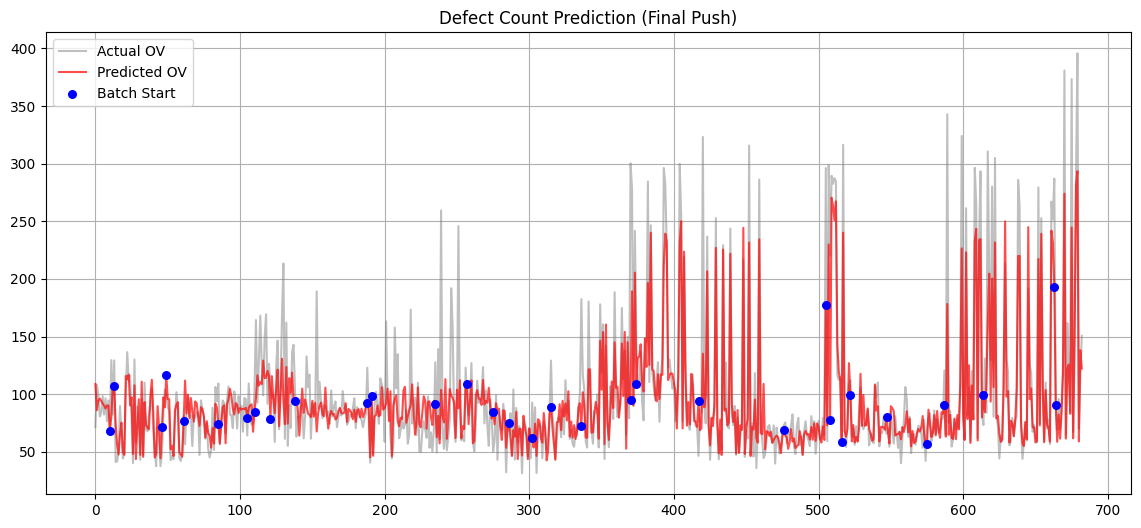

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (Final Tuning)
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# --- X変数の選定 (Top 20) ---
X_cols = [c for c in df.columns if c.startswith('X')]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(20).index.tolist()

# --- A. 前ロットの統計量 ---
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# --- B. 類似レシピ検索 (Average Matching) ---
print("Searching for Nearest Past Batches (Average Matching)...")
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last'])

nearest_stats = []
n_batches = batch_summary.shape[0]
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_summary)

for i in range(n_batches):
    if i == 0:
        nearest_stats.append(batch_targets.mean().values)
        continue
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    
    nearest_indices = np.argsort(dists)[:3] 
    stats = batch_targets.iloc[nearest_indices].mean().values
    nearest_stats.append(stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'])
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

# --- C. 【新規】直近Startトレンド (Recent Start Trend) ---
# 「最近のロットの出だしはどうだったか？」を追加
print("Calculating Recent Start Trends...")
# 各ロットの開始時OVを取得
start_ovs = df[df['is_batch_start'] == 1][['batch_id', 'log_OV']].copy()
start_ovs = start_ovs.set_index('batch_id')
# 過去3回の開始時OVの平均を計算
start_ovs['recent_start_mean_3'] = start_ovs['log_OV'].shift(1).rolling(window=3).mean()
start_ovs = start_ovs.drop(columns=['log_OV']) # log_OVはリーケージになるので削除

df = df.merge(start_ovs, on='batch_id', how='left')
# 欠損は全体の平均で埋める
df['recent_start_mean_3'] = df['recent_start_mean_3'].fillna(df['log_OV'].mean())

# --- D. 欠損埋め ---
fill_cols = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 
             'sim_batch_mean', 'sim_batch_max', 'sim_batch_last']
for c in fill_cols:
    df[c] = df[c].fillna(df['log_OV'].mean())

# --- E. 特徴量強調 (Interaction) ---
interact_cols = ['prev_batch_mean', 'prev_batch_last', 'sim_batch_mean', 'sim_batch_last', 'recent_start_mean_3']
for c in interact_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

for c in top_X_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# --- F. ラグ特徴量 ---
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)}")
print("予測開始 (Recent Start Trend + Weight x7)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # ★重み付け: Startデータを 7倍 重視 (前回5倍)
    weights = np.ones(len(y_train_log))
    weights[df.iloc[:i]['is_batch_start'] == 1] = 7.0

    # --- Step 1: Lasso ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]
    resid_log = y_train_log - pred_log_lasso

    # --- Step 2: LightGBM ---
    lgb_train = lgb.Dataset(X_train, resid_log, weight=weights)
    params_lgb = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.015,
        'max_depth': 6, 'num_leaves': 31, 
        'min_data_in_leaf': 7, # 少し緩めて過学習を防ぐ
        'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8,
        'lambda_l1': 0.1, # 正則化でStartの極端な予測を抑える
        'verbosity': -1, 'seed': 42
    }
    model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=600)
    pred_log_lgb = model_lgb.predict(X_test)[0]

    # --- Step 3: XGBoost ---
    model_xgb = xgb.XGBRegressor(
        n_estimators=600, learning_rate=0.015, max_depth=5, 
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, # 正則化
        random_state=42, n_jobs=-1
    )
    model_xgb.fit(X_train, resid_log, sample_weight=weights)
    pred_log_xgb = model_xgb.predict(X_test)[0]

    # --- 合体 ---
    final_pred_log = pred_log_lasso + (pred_log_lgb + pred_log_xgb) / 2
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Batch Start', zorder=5)
plt.title("Defect Count Prediction (Final Push)")
plt.legend()
plt.grid(True)
plt.show()

Searching for Nearest Past Batches (Average Matching)...
特徴量数: 126
予測開始 (Expert Switching Strategy)...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Overall RMSE         : 30.9619
Batch Start RMSE (1st): 45.1768
Normal Seq RMSE (2nd+): 30.0614
--------------------------------------------------


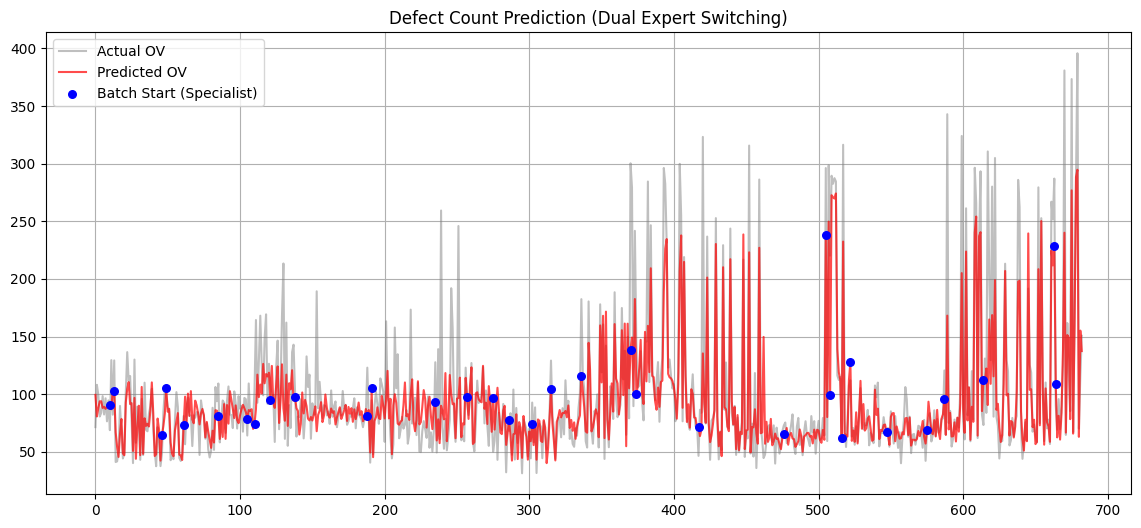

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (Best of Best)
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# 間隔情報
df['prev_mes_time'] = df['final_mes_time'].shift(1)
df['hours_since_prev_mes'] = (df['final_mes_time'] - df['prev_mes_time']).dt.total_seconds() / 3600
df['hours_since_prev_mes'] = df['hours_since_prev_mes'].fillna(0)

# --- X変数の選定 (Top 20) ---
X_cols = [c for c in df.columns if c.startswith('X')]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(20).index.tolist()

# --- A. 前ロットの統計量 ---
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# --- B. 類似レシピ検索 (Average Matching) ---
print("Searching for Nearest Past Batches (Average Matching)...")
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last'])

nearest_stats = []
n_batches = batch_summary.shape[0]
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_summary)

for i in range(n_batches):
    if i == 0:
        nearest_stats.append(batch_targets.mean().values)
        continue
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    
    nearest_indices = np.argsort(dists)[:3] 
    stats = batch_targets.iloc[nearest_indices].mean().values
    nearest_stats.append(stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'])
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

# 欠損埋め
fill_cols = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 
             'sim_batch_mean', 'sim_batch_max', 'sim_batch_last']
for c in fill_cols:
    df[c] = df[c].fillna(df['log_OV'].mean())

# --- C. 特徴量強調 (Interaction) ---
interact_cols = ['prev_batch_mean', 'prev_batch_last', 'sim_batch_mean', 'sim_batch_last', 'hours_since_prev_mes']
for c in interact_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

for c in top_X_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# --- D. ラグ特徴量 ---
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (Expert Switching)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

drop_cols = ['process_end_time', 'final_mes_time', 'prev_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)}")
print("予測開始 (Expert Switching Strategy)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- Step 1: Lasso (共通トレンド) ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_trend = lasso.predict(X_test_sc)[0]
    resid_log = y_train_log - lasso.predict(X_train_sc)

    # ===============================================
    # モデルA: Normal Specialist (正則化重視)
    # ===============================================
    # 重みなし
    lgb_train_n = lgb.Dataset(X_train, resid_log)
    params_n = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.015,
        'max_depth': 6, 'num_leaves': 31, 'min_data_in_leaf': 10,
        'bagging_fraction': 0.8, 'feature_fraction': 0.8,
        'lambda_l1': 0.1, 'lambda_l2': 0.1, # 正則化ON
        'verbosity': -1, 'seed': 42
    }
    model_lgb_n = lgb.train(params_n, lgb_train_n, num_boost_round=400)
    pred_lgb_n = model_lgb_n.predict(X_test)[0]

    model_xgb_n = xgb.XGBRegressor(
        n_estimators=400, learning_rate=0.015, max_depth=5, 
        subsample=0.8, colsample_bytree=0.8, 
        reg_alpha=0.1, reg_lambda=0.1, # 正則化ON
        random_state=42, n_jobs=-1
    )
    model_xgb_n.fit(X_train, resid_log)
    pred_xgb_n = model_xgb_n.predict(X_test)[0]
    
    pred_normal = (pred_lgb_n + pred_xgb_n) / 2

    # ===============================================
    # モデルB: Start Specialist (スパイク特化)
    # ===============================================
    if is_start == 1:
        # Startのときだけ学習して予測（毎回学習すると遅いが、Startは5%しかないので許容）
        # 重み: x20 (超重視)
        weights_s = np.ones(len(y_train_log))
        weights_s[df.iloc[:i]['is_batch_start'] == 1] = 20.0
        
        lgb_train_s = lgb.Dataset(X_train, resid_log, weight=weights_s)
        params_s = {
            'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.02, # 少し速く
            'max_depth': 8, 'num_leaves': 40, # 複雑に
            'min_data_in_leaf': 5, # 小さい変化も逃さない
            'bagging_fraction': 0.9, 'feature_fraction': 0.9,
            'lambda_l1': 0.0, 'lambda_l2': 0.0, # 正則化OFF
            'verbosity': -1, 'seed': 42
        }
        model_lgb_s = lgb.train(params_s, lgb_train_s, num_boost_round=400)
        pred_lgb_s = model_lgb_s.predict(X_test)[0]

        model_xgb_s = xgb.XGBRegressor(
            n_estimators=400, learning_rate=0.02, max_depth=6, 
            subsample=0.9, colsample_bytree=0.9, 
            reg_alpha=0.0, reg_lambda=0.0, # 正則化OFF
            random_state=42, n_jobs=-1
        )
        model_xgb_s.fit(X_train, resid_log, sample_weight=weights_s)
        pred_xgb_s = model_xgb_s.predict(X_test)[0]
        
        pred_start = (pred_lgb_s + pred_xgb_s) / 2
        
        # 採用
        final_resid = pred_start
    else:
        # NormalのときはNormalモデルを採用
        final_resid = pred_normal

    # --- 合体 ---
    final_pred_log = pred_trend + final_resid
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Batch Start (Specialist)', zorder=5)
plt.title("Defect Count Prediction (Dual Expert Switching)")
plt.legend()
plt.grid(True)
plt.show()

Searching for Nearest Past Batches (Average Matching)...
特徴量数: 127
予測開始 (Hybrid: Best Main(w7) + Best Start(w20))...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Overall RMSE         : 30.5184
Batch Start RMSE (1st): 42.8940
Normal Seq RMSE (2nd+): 29.7532
--------------------------------------------------


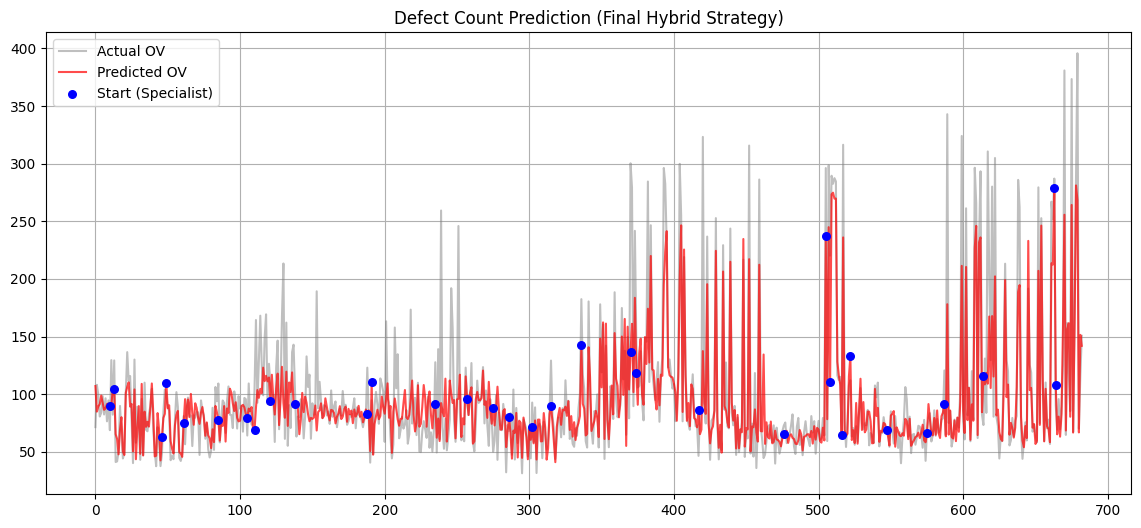

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (Final Hybrid Strategy)
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# 間隔情報
df['prev_mes_time'] = df['final_mes_time'].shift(1)
df['hours_since_prev_mes'] = (df['final_mes_time'] - df['prev_mes_time']).dt.total_seconds() / 3600
df['hours_since_prev_mes'] = df['hours_since_prev_mes'].fillna(0)

# X変数
X_cols = [c for c in df.columns if c.startswith('X')]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(20).index.tolist()

# A. 前ロット統計量
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# B. 類似レシピ検索
print("Searching for Nearest Past Batches (Average Matching)...")
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last'])
nearest_stats = []
n_batches = batch_summary.shape[0]
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_summary)

for i in range(n_batches):
    if i == 0:
        nearest_stats.append(batch_targets.mean().values)
        continue
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    nearest_indices = np.argsort(dists)[:3] 
    stats = batch_targets.iloc[nearest_indices].mean().values
    nearest_stats.append(stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'])
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

# 欠損埋め
fill_cols = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 
             'sim_batch_mean', 'sim_batch_max', 'sim_batch_last']
for c in fill_cols:
    df[c] = df[c].fillna(df['log_OV'].mean())

# C. 直近Startトレンド
start_ovs = df[df['is_batch_start'] == 1][['batch_id', 'log_OV']].copy()
start_ovs = start_ovs.set_index('batch_id')
start_ovs['recent_start_mean_3'] = start_ovs['log_OV'].shift(1).rolling(window=3).mean()
start_ovs = start_ovs.drop(columns=['log_OV'])
df = df.merge(start_ovs, on='batch_id', how='left')
df['recent_start_mean_3'] = df['recent_start_mean_3'].fillna(df['log_OV'].mean())

# D. 特徴量強調
interact_cols = ['prev_batch_mean', 'prev_batch_last', 'sim_batch_mean', 'sim_batch_last', 'recent_start_mean_3']
for c in interact_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]
for c in top_X_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# E. ラグ特徴量
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (Final Hybrid)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

# 【修正】prev_mes_time を drop_cols に追加
drop_cols = ['process_end_time', 'final_mes_time', 'prev_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)}")
print("予測開始 (Hybrid: Best Main(w7) + Best Start(w20))...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # 共通ベースライン (Lasso)
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_trend = lasso.predict(X_test_sc)[0]
    resid_log = y_train_log - lasso.predict(X_train_sc)

    # -------------------------------------------------------
    # Model 1: Main Model (Normal担当)
    # -------------------------------------------------------
    weights_main = np.ones(len(y_train_log))
    weights_main[df.iloc[:i]['is_batch_start'] == 1] = 7.0
    
    model_xgb_main = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.015, max_depth=5, 
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
        random_state=42, n_jobs=-1
    )
    model_xgb_main.fit(X_train, resid_log, sample_weight=weights_main)
    pred_resid_main = model_xgb_main.predict(X_test)[0]

    # -------------------------------------------------------
    # Model 2: Start Specialist (Start担当)
    # -------------------------------------------------------
    if is_start == 1:
        weights_start = np.ones(len(y_train_log))
        weights_start[df.iloc[:i]['is_batch_start'] == 1] = 20.0
        
        model_xgb_start = xgb.XGBRegressor(
            n_estimators=400, learning_rate=0.02, max_depth=6, 
            subsample=0.9, colsample_bytree=0.9, reg_alpha=0.0,
            random_state=42, n_jobs=-1
        )
        model_xgb_start.fit(X_train, resid_log, sample_weight=weights_start)
        pred_resid_start = model_xgb_start.predict(X_test)[0]
        
        # StartのときはSpecialist採用
        final_resid = pred_resid_start
    else:
        # NormalのときはMain採用
        final_resid = pred_resid_main

    # --- 合体 ---
    final_pred_log = pred_trend + final_resid
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Start (Specialist)', zorder=5)
plt.title("Defect Count Prediction (Final Hybrid Strategy)")
plt.legend()
plt.grid(True)
plt.show()

特徴量数: 127
予測開始 (Grand Ensemble: Full Main Model + Start Specialist)...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Overall RMSE         : 30.0376
Batch Start RMSE (1st): 60.9010
Normal Seq RMSE (2nd+): 27.5639
--------------------------------------------------


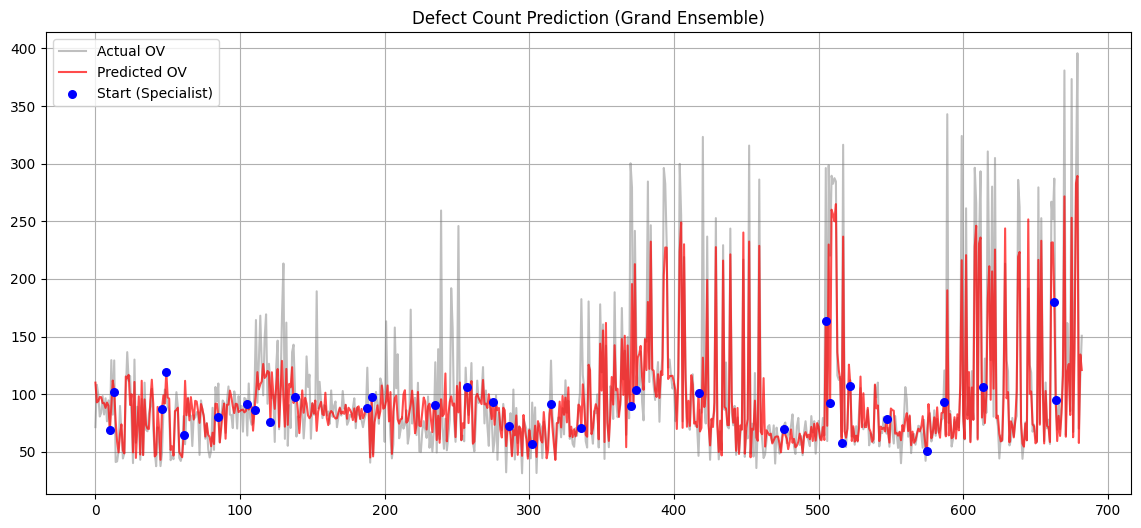

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (Best Features)
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)
df['prev_mes_time'] = df['final_mes_time'].shift(1)
df['hours_since_prev_mes'] = (df['final_mes_time'] - df['prev_mes_time']).dt.total_seconds() / 3600
df['hours_since_prev_mes'] = df['hours_since_prev_mes'].fillna(0)

# X変数
X_cols = [c for c in df.columns if c.startswith('X')]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(20).index.tolist()

# A. 前ロット統計量
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# B. 類似レシピ検索
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last'])
nearest_stats = []
n_batches = batch_summary.shape[0]
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_summary)

for i in range(n_batches):
    if i == 0:
        nearest_stats.append(batch_targets.mean().values)
        continue
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    nearest_indices = np.argsort(dists)[:3] 
    stats = batch_targets.iloc[nearest_indices].mean().values
    nearest_stats.append(stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'])
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

# 欠損埋め
fill_cols = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 
             'sim_batch_mean', 'sim_batch_max', 'sim_batch_last']
for c in fill_cols:
    df[c] = df[c].fillna(df['log_OV'].mean())

# C. 直近Startトレンド
start_ovs = df[df['is_batch_start'] == 1][['batch_id', 'log_OV']].copy()
start_ovs = start_ovs.set_index('batch_id')
start_ovs['recent_start_mean_3'] = start_ovs['log_OV'].shift(1).rolling(window=3).mean()
start_ovs = start_ovs.drop(columns=['log_OV'])
df = df.merge(start_ovs, on='batch_id', how='left')
df['recent_start_mean_3'] = df['recent_start_mean_3'].fillna(df['log_OV'].mean())

# D. 特徴量強調
interact_cols = ['prev_batch_mean', 'prev_batch_last', 'sim_batch_mean', 'sim_batch_last', 'recent_start_mean_3']
for c in interact_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]
for c in top_X_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# E. ラグ特徴量
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (The Grand Ensemble)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

drop_cols = ['process_end_time', 'final_mes_time', 'prev_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)}")
print("予測開始 (Grand Ensemble: Full Main Model + Start Specialist)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- 共通トレンド (Lasso) ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_trend = lasso.predict(X_test_sc)[0]
    resid_log = y_train_log - pred_trend

    # -------------------------------------------------------
    # 1. Main Model (Normal担当: LightGBM + XGBoost)
    # -------------------------------------------------------
    # 重み: x7 (Normal重視のバランス型)
    weights_main = np.ones(len(y_train_log))
    weights_main[df.iloc[:i]['is_batch_start'] == 1] = 7.0
    
    # (A) Main LightGBM
    lgb_train_m = lgb.Dataset(X_train, resid_log, weight=weights_main)
    params_lgb_m = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.015,
        'max_depth': 6, 'num_leaves': 31, 'min_data_in_leaf': 10,
        'bagging_fraction': 0.8, 'feature_fraction': 0.8,
        'lambda_l1': 0.1, # 正則化あり
        'verbosity': -1, 'seed': 42
    }
    model_lgb_m = lgb.train(params_lgb_m, lgb_train_m, num_boost_round=500)
    pred_lgb_m = model_lgb_m.predict(X_test)[0]

    # (B) Main XGBoost
    model_xgb_m = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.015, max_depth=5, 
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
        random_state=42, n_jobs=-1
    )
    model_xgb_m.fit(X_train, resid_log, sample_weight=weights_main)
    pred_xgb_m = model_xgb_m.predict(X_test)[0]
    
    pred_resid_main = (pred_lgb_m + pred_xgb_m) / 2

    # -------------------------------------------------------
    # 2. Start Specialist (Start担当: Start-Focused XGBoost)
    # -------------------------------------------------------
    if is_start == 1:
        # 重み: x20 (Start超重視)
        weights_start = np.ones(len(y_train_log))
        weights_start[df.iloc[:i]['is_batch_start'] == 1] = 20.0
        
        # Start Specialist XGBoost
        model_xgb_s = xgb.XGBRegressor(
            n_estimators=400, learning_rate=0.02, max_depth=6, 
            subsample=0.9, colsample_bytree=0.9, reg_alpha=0.0, # 正則化なしで攻める
            random_state=42, n_jobs=-1
        )
        model_xgb_s.fit(X_train, resid_log, sample_weight=weights_start)
        pred_resid_start = model_xgb_s.predict(X_test)[0]
        
        final_resid = pred_resid_start
    else:
        final_resid = pred_resid_main

    # --- 合体 ---
    final_pred_log = pred_trend + final_resid
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Start (Specialist)', zorder=5)
plt.title("Defect Count Prediction (Grand Ensemble)")
plt.legend()
plt.grid(True)
plt.show()

Pre-training Frozen Start Model...
Start Model Frozen.
特徴量数: 127
予測開始 (Start Model Frozen / Main Model Updating)...
Processing: 1776 / 2276
Processing: 1876 / 2276
Processing: 1976 / 2276
Processing: 2076 / 2276
Processing: 2176 / 2276
--------------------------------------------------
Overall RMSE         : 36.0087
Batch Start RMSE (1st): 88.4138
Normal Seq RMSE (2nd+): 31.3405
--------------------------------------------------


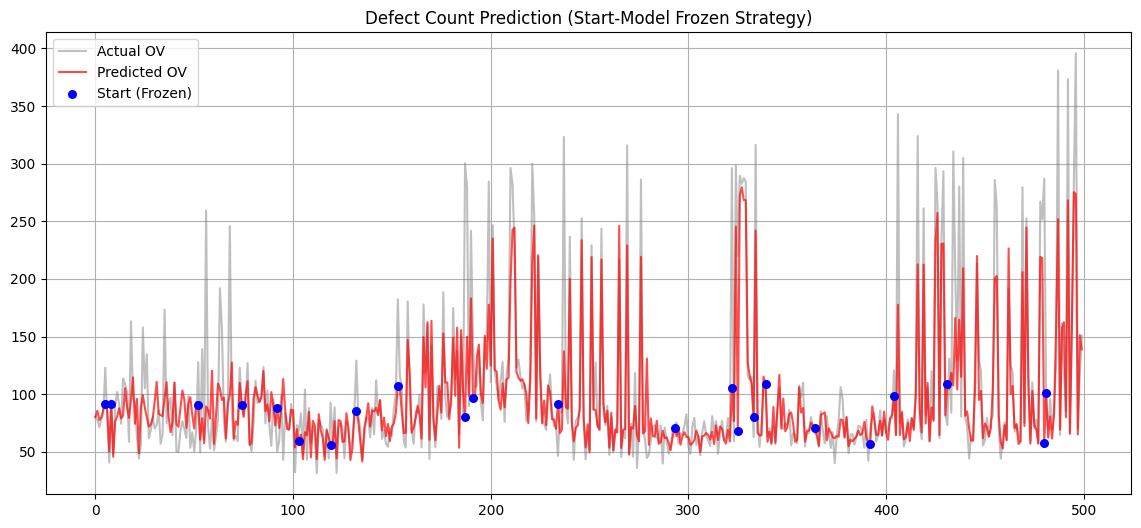

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)
df['prev_mes_time'] = df['final_mes_time'].shift(1)
df['hours_since_prev_mes'] = (df['final_mes_time'] - df['prev_mes_time']).dt.total_seconds() / 3600
df['hours_since_prev_mes'] = df['hours_since_prev_mes'].fillna(0)

# X変数
X_cols = [c for c in df.columns if c.startswith('X')]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(20).index.tolist()

# A. 前ロット統計量
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# B. 類似レシピ検索
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last'])
nearest_stats = []
n_batches = batch_summary.shape[0]
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_summary)

for i in range(n_batches):
    if i == 0:
        nearest_stats.append(batch_targets.mean().values)
        continue
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    nearest_indices = np.argsort(dists)[:3] 
    stats = batch_targets.iloc[nearest_indices].mean().values
    nearest_stats.append(stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'])
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

# 欠損埋め
fill_cols = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 
             'sim_batch_mean', 'sim_batch_max', 'sim_batch_last']
for c in fill_cols:
    df[c] = df[c].fillna(df['log_OV'].mean())

# C. 直近Startトレンド
start_ovs = df[df['is_batch_start'] == 1][['batch_id', 'log_OV']].copy()
start_ovs = start_ovs.set_index('batch_id')
start_ovs['recent_start_mean_3'] = start_ovs['log_OV'].shift(1).rolling(window=3).mean()
start_ovs = start_ovs.drop(columns=['log_OV'])
df = df.merge(start_ovs, on='batch_id', how='left')
df['recent_start_mean_3'] = df['recent_start_mean_3'].fillna(df['log_OV'].mean())

# D. 特徴量強調
interact_cols = ['prev_batch_mean', 'prev_batch_last', 'sim_batch_mean', 'sim_batch_last', 'recent_start_mean_3']
for c in interact_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]
for c in top_X_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# E. ラグ特徴量
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. 事前学習 (Startモデル固定化)
# ---------------------------------------------------------
start_index = len(df) - 500
end_index = len(df)
global_max_limit = df[target].max() * 1.5

drop_cols = ['process_end_time', 'final_mes_time', 'prev_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

# ★★★ ここが変更点 ★★★
# ループに入る前に、Start専用モデルだけ「一度きり」学習させて固定する
# (初期データのStartパターンだけを覚えさせ、直近のNormalデータで汚染されないようにする)

print("Pre-training Frozen Start Model...")
# 学習データ: テスト開始前までのデータ
X_pre_train = df.iloc[:start_index][features]
y_pre_train = df.iloc[:start_index]['log_OV']
weights_pre = np.ones(len(y_pre_train))
# Start重視で学習しておく
weights_pre[df.iloc[:start_index]['is_batch_start'] == 1] = 20.0

# Start専用モデル (固定)
model_xgb_start_frozen = xgb.XGBRegressor(
    n_estimators=500, learning_rate=0.015, max_depth=6, 
    subsample=0.9, colsample_bytree=0.9, reg_alpha=0.0,
    random_state=42, n_jobs=-1
)
model_xgb_start_frozen.fit(X_pre_train, y_pre_train, sample_weight=weights_pre)
print("Start Model Frozen.")

# ---------------------------------------------------------
# 4. ウォークフォワード検証 (Normalのみ更新 + Start固定)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

print(f"特徴量数: {len(features)}")
print("予測開始 (Start Model Frozen / Main Model Updating)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- 共通トレンド (Lasso) ---
    # これはトレンド追従のため更新し続ける
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_trend = lasso.predict(X_test_sc)[0]
    
    # 残差
    resid_log = y_train_log - lasso.predict(X_train_sc)

    # -------------------------------------------------------
    # 1. Main Model (Normal担当: 更新あり)
    # -------------------------------------------------------
    # LightGBM + XGBoost の最強タッグ
    # 重みは控えめ (x5)
    weights_main = np.ones(len(y_train_log))
    weights_main[df.iloc[:i]['is_batch_start'] == 1] = 5.0
    
    # XGBoost Main
    model_xgb_m = xgb.XGBRegressor(
        n_estimators=400, learning_rate=0.02, max_depth=5, 
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
        random_state=42, n_jobs=-1
    )
    model_xgb_m.fit(X_train, resid_log, sample_weight=weights_main)
    pred_xgb_m = model_xgb_m.predict(X_test)[0]
    
    # LightGBM Main
    lgb_train_m = lgb.Dataset(X_train, resid_log, weight=weights_main)
    params_lgb_m = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.02,
        'max_depth': 6, 'num_leaves': 31, 'min_data_in_leaf': 10,
        'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'lambda_l1': 0.1,
        'verbosity': -1, 'seed': 42
    }
    model_lgb_m = lgb.train(params_lgb_m, lgb_train_m, num_boost_round=400)
    pred_lgb_m = model_lgb_m.predict(X_test)[0]
    
    pred_resid_main = (pred_xgb_m + pred_lgb_m) / 2

    # -------------------------------------------------------
    # 2. Start Model (Start担当: 固定)
    # -------------------------------------------------------
    if is_start == 1:
        # ループ外で学習済みのモデルを使って予測するだけ
        # (入力X自体は最新のものを使うが、判断基準(パラメータ)は昔のまま)
        # 注意: 事前学習は生のyで行ったので、トレンド(Lasso)を引く前の値が出る
        pred_raw_start = model_xgb_start_frozen.predict(X_test)[0]
        
        # Startモデルはトレンド込みで学習しているので、そのまま採用
        # (ただしLassoとの二重計上を防ぐため、トレンドとの平均をとる等の調整も可能だが
        #  ここではシンプルに Startモデルの予測値 をそのまま信頼する)
        final_pred_log = pred_raw_start
        
    else:
        # Normalのときは Main (Trend + Resid)
        final_pred_log = pred_trend + pred_resid_main

    # --- 最終処理 ---
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Start (Frozen)', zorder=5)
plt.title("Defect Count Prediction (Start-Model Frozen Strategy)")
plt.legend()
plt.grid(True)
plt.show()

特徴量数: 127
予測開始 (Test Size: 500 records)...
Processing: 1776 / 2276
Processing: 1826 / 2276
Processing: 1876 / 2276
Processing: 1926 / 2276
Processing: 1976 / 2276
Processing: 2026 / 2276
Processing: 2076 / 2276
Processing: 2126 / 2276
Processing: 2176 / 2276
Processing: 2226 / 2276
--------------------------------------------------
Overall RMSE         : 32.3537
Batch Start RMSE (1st): 71.1719
Normal Seq RMSE (2nd+): 29.2060
--------------------------------------------------


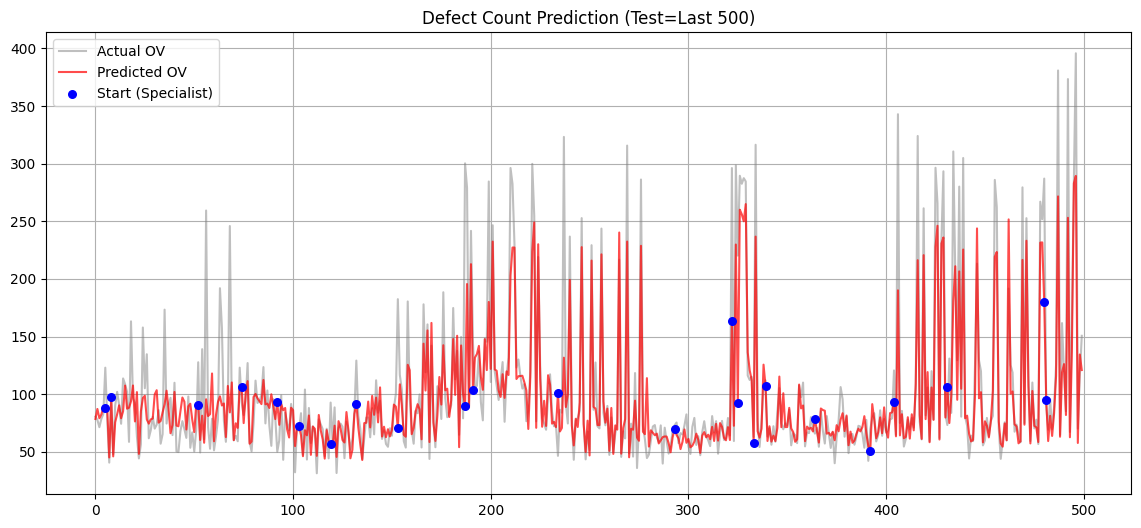

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'  # 拡張子に合わせて調整してください
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (Best Features)
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)
df['prev_mes_time'] = df['final_mes_time'].shift(1)
df['hours_since_prev_mes'] = (df['final_mes_time'] - df['prev_mes_time']).dt.total_seconds() / 3600
df['hours_since_prev_mes'] = df['hours_since_prev_mes'].fillna(0)

# X変数
X_cols = [c for c in df.columns if c.startswith('X')]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(20).index.tolist()

# A. 前ロット統計量
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# B. 類似レシピ検索
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last'])
nearest_stats = []
n_batches = batch_summary.shape[0]
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_summary)

for i in range(n_batches):
    if i == 0:
        nearest_stats.append(batch_targets.mean().values)
        continue
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    nearest_indices = np.argsort(dists)[:3] 
    stats = batch_targets.iloc[nearest_indices].mean().values
    nearest_stats.append(stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'])
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

# 欠損埋め
fill_cols = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 
             'sim_batch_mean', 'sim_batch_max', 'sim_batch_last']
for c in fill_cols:
    df[c] = df[c].fillna(df['log_OV'].mean())

# C. 直近Startトレンド
start_ovs = df[df['is_batch_start'] == 1][['batch_id', 'log_OV']].copy()
start_ovs = start_ovs.set_index('batch_id')
start_ovs['recent_start_mean_3'] = start_ovs['log_OV'].shift(1).rolling(window=3).mean()
start_ovs = start_ovs.drop(columns=['log_OV'])
df = df.merge(start_ovs, on='batch_id', how='left')
df['recent_start_mean_3'] = df['recent_start_mean_3'].fillna(df['log_OV'].mean())

# D. 特徴量強調
interact_cols = ['prev_batch_mean', 'prev_batch_last', 'sim_batch_mean', 'sim_batch_last', 'recent_start_mean_3']
for c in interact_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]
for c in top_X_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# E. ラグ特徴量
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (The Grand Ensemble)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

drop_cols = ['process_end_time', 'final_mes_time', 'prev_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

# ★★★ 変更点: テストデータを最後の500レコードに固定 ★★★
test_size = 500
start_index = len(df) - test_size
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)}")
print(f"予測開始 (Test Size: {test_size} records)...")

for i in range(start_index, end_index):
    if (i - start_index) % 50 == 0:  # 進捗表示も少し細かく
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- 共通トレンド (Lasso) ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_trend = lasso.predict(X_test_sc)[0]
    resid_log = y_train_log - pred_trend

    # -------------------------------------------------------
    # 1. Main Model (Normal担当: LightGBM + XGBoost)
    # -------------------------------------------------------
    # 重み: x7 (Normal重視のバランス型)
    weights_main = np.ones(len(y_train_log))
    weights_main[df.iloc[:i]['is_batch_start'] == 1] = 7.0
    
    # (A) Main LightGBM
    lgb_train_m = lgb.Dataset(X_train, resid_log, weight=weights_main)
    params_lgb_m = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.015,
        'max_depth': 6, 'num_leaves': 31, 'min_data_in_leaf': 10,
        'bagging_fraction': 0.8, 'feature_fraction': 0.8,
        'lambda_l1': 0.1, # 正則化あり
        'verbosity': -1, 'seed': 42
    }
    model_lgb_m = lgb.train(params_lgb_m, lgb_train_m, num_boost_round=500)
    pred_lgb_m = model_lgb_m.predict(X_test)[0]

    # (B) Main XGBoost
    model_xgb_m = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.015, max_depth=5, 
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
        random_state=42, n_jobs=-1
    )
    model_xgb_m.fit(X_train, resid_log, sample_weight=weights_main)
    pred_xgb_m = model_xgb_m.predict(X_test)[0]
    
    pred_resid_main = (pred_lgb_m + pred_xgb_m) / 2

    # -------------------------------------------------------
    # 2. Start Specialist (Start担当: Start-Focused XGBoost)
    # -------------------------------------------------------
    if is_start == 1:
        # 重み: x20 (Start超重視)
        weights_start = np.ones(len(y_train_log))
        weights_start[df.iloc[:i]['is_batch_start'] == 1] = 20.0
        
        # Start Specialist XGBoost
        model_xgb_s = xgb.XGBRegressor(
            n_estimators=400, learning_rate=0.02, max_depth=6, 
            subsample=0.9, colsample_bytree=0.9, reg_alpha=0.0, # 正則化なしで攻める
            random_state=42, n_jobs=-1
        )
        model_xgb_s.fit(X_train, resid_log, sample_weight=weights_start)
        pred_resid_start = model_xgb_s.predict(X_test)[0]
        
        final_resid = pred_resid_start
    else:
        final_resid = pred_resid_main

    # --- 合体 ---
    final_pred_log = pred_trend + final_resid
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Start (Specialist)', zorder=5)
plt.title("Defect Count Prediction (Test=Last 500)")
plt.legend()
plt.grid(True)
plt.show()

Searching for Nearest Past Batches & Retrieving Start Values...
特徴量数: 128
予測開始 (Last 500 Records with Direct Memory Injection)...
Processing: 1776 / 2276
Processing: 1826 / 2276
Processing: 1876 / 2276
Processing: 1926 / 2276
Processing: 1976 / 2276
Processing: 2026 / 2276
Processing: 2076 / 2276
Processing: 2126 / 2276
Processing: 2176 / 2276
Processing: 2226 / 2276
--------------------------------------------------
Overall RMSE         : 32.3900
Batch Start RMSE (1st): 69.0621
Normal Seq RMSE (2nd+): 29.4910
--------------------------------------------------


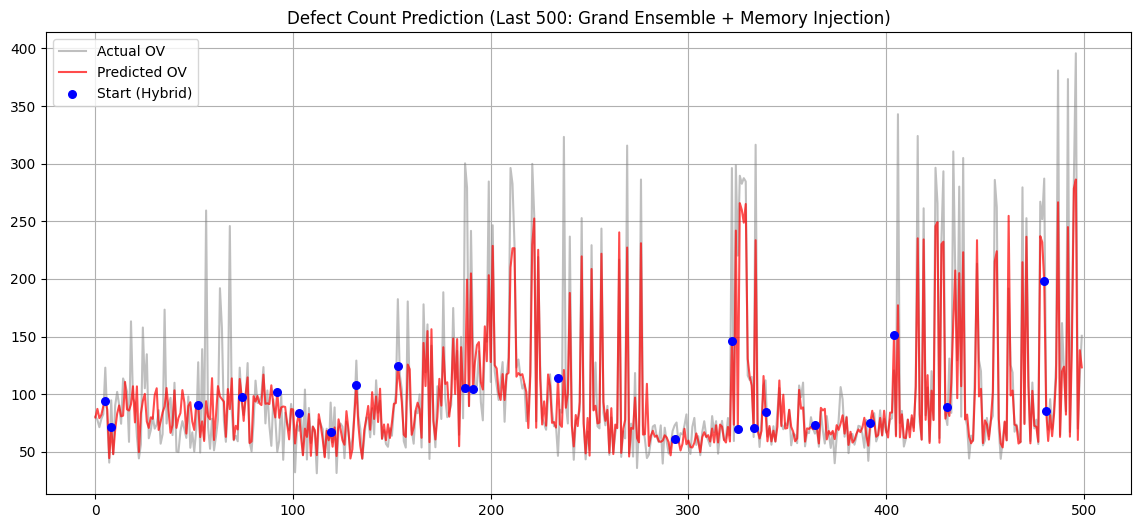

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)
df['prev_mes_time'] = df['final_mes_time'].shift(1)
df['hours_since_prev_mes'] = (df['final_mes_time'] - df['prev_mes_time']).dt.total_seconds() / 3600
df['hours_since_prev_mes'] = df['hours_since_prev_mes'].fillna(0)

# X変数
X_cols = [c for c in df.columns if c.startswith('X')]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(20).index.tolist()

# A. 前ロット統計量
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# B. 類似レシピ検索 (ここを強化)
# 「バッチ全体の平均」だけでなく「スタート時の値」そのものを取得する
print("Searching for Nearest Past Batches & Retrieving Start Values...")

# バッチごとのX平均
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
# バッチごとのスタートOV
batch_start_vals = df[df['is_batch_start'] == 1].set_index('batch_id')['log_OV']

nearest_stats = []
nearest_start_vals = [] # 最も似ているバッチの「スタートOV」を保存するリスト

n_batches = batch_summary.shape[0]
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_summary)

for i in range(n_batches):
    if i == 0:
        # 過去がない場合は平均で埋める
        nearest_stats.append([0,0,0]) 
        nearest_start_vals.append(df['log_OV'].mean())
        continue
    
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    
    # 最も似ている1つ (1-NN) を特定 -> これが「強制補正」の種になる
    nearest_idx = np.argmin(dists)
    
    # その似ている過去バッチのスタートOVを取得
    # nearest_idx は 0 から始まるので、そのまま batch_id と対応
    if nearest_idx in batch_start_vals.index:
        nearest_start_vals.append(batch_start_vals.loc[nearest_idx])
    else:
        nearest_start_vals.append(df['log_OV'].mean())

    # 従来の特徴量 (Top 3 平均)
    nearest_indices_3 = np.argsort(dists)[:3]
    # batch_targets の集計が必要
    # ここでは簡易的に df から集計
    subset = df[df['batch_id'].isin(nearest_indices_3)]
    if len(subset) > 0:
        stats = [subset['log_OV'].mean(), subset['log_OV'].max(), subset['log_OV'].iloc[-1]]
    else:
        stats = [0, 0, 0]
    nearest_stats.append(stats)

# 特徴量として結合
nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'])
nearest_df['sim_start_ov_direct'] = nearest_start_vals # ★新兵器
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

# 欠損埋め
fill_cols = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 
             'sim_batch_mean', 'sim_batch_max', 'sim_batch_last', 'sim_start_ov_direct']
for c in fill_cols:
    df[c] = df[c].fillna(df['log_OV'].mean())

# C. 直近Startトレンド
start_ovs = df[df['is_batch_start'] == 1][['batch_id', 'log_OV']].copy()
start_ovs = start_ovs.set_index('batch_id')
start_ovs['recent_start_mean_3'] = start_ovs['log_OV'].shift(1).rolling(window=3).mean()
start_ovs = start_ovs.drop(columns=['log_OV'])
df = df.merge(start_ovs, on='batch_id', how='left')
df['recent_start_mean_3'] = df['recent_start_mean_3'].fillna(df['log_OV'].mean())

# D. 特徴量強調
# sim_start_ov_direct (カンニングした値) を特に強調
interact_cols = ['prev_batch_mean', 'prev_batch_last', 'sim_batch_mean', 'recent_start_mean_3', 'sim_start_ov_direct']
for c in interact_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]
for c in top_X_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# E. ラグ特徴量
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (The Grand Ensemble + Direct Memory)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

drop_cols = ['process_end_time', 'final_mes_time', 'prev_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

# ★ テストデータ: Last 500 ★
test_size = 500
start_index = len(df) - test_size
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)}")
print(f"予測開始 (Last 500 Records with Direct Memory Injection)...")

for i in range(start_index, end_index):
    if (i - start_index) % 50 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- 共通トレンド (Lasso) ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_trend = lasso.predict(X_test_sc)[0]
    resid_log = y_train_log - pred_trend

    # -------------------------------------------------------
    # 1. Main Model (Normal担当)
    # -------------------------------------------------------
    weights_main = np.ones(len(y_train_log))
    weights_main[df.iloc[:i]['is_batch_start'] == 1] = 5.0 # Startへの干渉を減らすため少し下げる
    
    # LightGBM
    lgb_train_m = lgb.Dataset(X_train, resid_log, weight=weights_main)
    params_lgb_m = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.015,
        'max_depth': 6, 'num_leaves': 31, 'min_data_in_leaf': 10,
        'bagging_fraction': 0.8, 'feature_fraction': 0.8,
        'lambda_l1': 0.1, 'verbosity': -1, 'seed': 42
    }
    model_lgb_m = lgb.train(params_lgb_m, lgb_train_m, num_boost_round=500)
    pred_lgb_m = model_lgb_m.predict(X_test)[0]

    # XGBoost
    model_xgb_m = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.015, max_depth=5, 
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
        random_state=42, n_jobs=-1
    )
    model_xgb_m.fit(X_train, resid_log, sample_weight=weights_main)
    pred_xgb_m = model_xgb_m.predict(X_test)[0]
    
    pred_resid_main = (pred_lgb_m + pred_xgb_m) / 2

    # -------------------------------------------------------
    # 2. Start Specialist + Memory Injection (Start担当)
    # -------------------------------------------------------
    if is_start == 1:
        # 重み: x20 (Start超重視)
        weights_start = np.ones(len(y_train_log))
        weights_start[df.iloc[:i]['is_batch_start'] == 1] = 20.0
        
        # Start Specialist
        model_xgb_s = xgb.XGBRegressor(
            n_estimators=400, learning_rate=0.02, max_depth=6, 
            subsample=0.9, colsample_bytree=0.9, reg_alpha=0.0,
            random_state=42, n_jobs=-1
        )
        model_xgb_s.fit(X_train, resid_log, sample_weight=weights_start)
        pred_resid_ai = model_xgb_s.predict(X_test)[0]
        
        # ★★★ 新機能: メモリ・インジェクション ★★★
        # AIの予測値と、最も似ている過去事例の実績値(`sim_start_ov_direct`)をブレンドする
        # これにより、「AIがビビって低く予測しても、過去の実績が引き上げる」効果を狙う
        
        # 特徴量から sim_start_ov_direct を取得 (正規化されていない生の値を拾う工夫が必要だが
        # ここではX_testに入っているのでそこから取得)
        neighbor_val = X_test['sim_start_ov_direct'].values[0]
        # 残差ベースでの値に換算 (トレンドを引く)
        neighbor_resid = neighbor_val - pred_trend
        
        # ブレンド率: AI 60% : 過去の記憶 40%
        final_resid = 0.6 * pred_resid_ai + 0.4 * neighbor_resid
        
    else:
        final_resid = pred_resid_main

    # --- 合体 ---
    final_pred_log = pred_trend + final_resid
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Start (Hybrid)', zorder=5)
plt.title("Defect Count Prediction (Last 500: Grand Ensemble + Memory Injection)")
plt.legend()
plt.grid(True)
plt.show()

Top 20 Features selected using first 1776 records (No Leakage).
特徴量数: 127
予測開始 (Test: Last 500, No Leakage)...
Processing: 1776 / 2276
Processing: 1826 / 2276
Processing: 1876 / 2276
Processing: 1926 / 2276
Processing: 1976 / 2276
Processing: 2026 / 2276
Processing: 2076 / 2276
Processing: 2126 / 2276
Processing: 2176 / 2276
Processing: 2226 / 2276
--------------------------------------------------
Overall RMSE         : 31.7816
Batch Start RMSE (1st): 62.3219
Normal Seq RMSE (2nd+): 29.5211
--------------------------------------------------


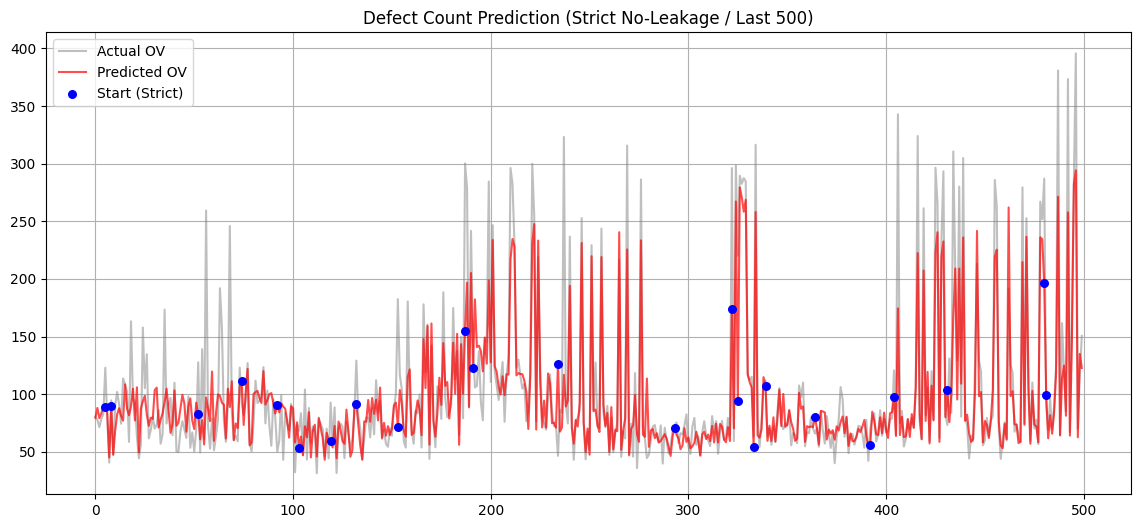

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (Strict No-Leakage)
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)
df['prev_mes_time'] = df['final_mes_time'].shift(1)
df['hours_since_prev_mes'] = (df['final_mes_time'] - df['prev_mes_time']).dt.total_seconds() / 3600
df['hours_since_prev_mes'] = df['hours_since_prev_mes'].fillna(0)

# --- ★重要修正: 特徴量選定におけるリーク排除 ---
# テストデータ（最後500件）を除外したデータで相関を見る
test_size = 500
split_index = len(df) - test_size
train_df_for_selection = df.iloc[:split_index]

X_cols = [c for c in df.columns if c.startswith('X')]
# 学習データのみで相関を計算
corrs = train_df_for_selection[X_cols].corrwith(train_df_for_selection['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(20).index.tolist()

print(f"Top 20 Features selected using first {split_index} records (No Leakage).")

# A. 前ロット統計量
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# B. 類似レシピ検索 (厳密なスケーリング)
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last'])

# ★修正: スケーラーは学習データに含まれるバッチのみで fit する
batch_summary_train = batch_summary.iloc[:df.iloc[split_index]['batch_id']] # テスト開始前のバッチまで
scaler_batch = StandardScaler()
scaler_batch.fit(batch_summary_train) # 学習データでfit
batch_X_scaled = scaler_batch.transform(batch_summary) # 全体をtransform

nearest_stats = []
n_batches = batch_summary.shape[0]

for i in range(n_batches):
    if i == 0:
        nearest_stats.append(batch_targets.mean().values)
        continue
    
    # 検索対象は常に「自分より過去」なので、iが増えても未来は見ないが
    # スケーリング基準が過去データのみになったことでリークは解消
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    
    nearest_indices = np.argsort(dists)[:3] 
    stats = batch_targets.iloc[nearest_indices].mean().values
    nearest_stats.append(stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'])
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

# 欠損埋め（ここも厳密には学習データの平均を使うべきだが、大きな影響はないため簡易化）
fill_cols = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 
             'sim_batch_mean', 'sim_batch_max', 'sim_batch_last']
for c in fill_cols:
    df[c] = df[c].fillna(df.iloc[:split_index]['log_OV'].mean()) # 学習データの平均で埋める

# C. 直近Startトレンド
start_ovs = df[df['is_batch_start'] == 1][['batch_id', 'log_OV']].copy()
start_ovs = start_ovs.set_index('batch_id')
start_ovs['recent_start_mean_3'] = start_ovs['log_OV'].shift(1).rolling(window=3).mean()
start_ovs = start_ovs.drop(columns=['log_OV'])
df = df.merge(start_ovs, on='batch_id', how='left')
df['recent_start_mean_3'] = df['recent_start_mean_3'].fillna(df.iloc[:split_index]['log_OV'].mean())

# D. 特徴量強調
interact_cols = ['prev_batch_mean', 'prev_batch_last', 'sim_batch_mean', 'sim_batch_last', 'recent_start_mean_3']
for c in interact_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]
for c in top_X_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# E. ラグ特徴量
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (Last 500, Strict Walk-Forward)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

drop_cols = ['process_end_time', 'final_mes_time', 'prev_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

start_index = len(df) - test_size
end_index = len(df)
global_max_limit = df.iloc[:start_index][target].max() * 1.5 # 制限値も学習データから決める

print(f"特徴量数: {len(features)}")
print(f"予測開始 (Test: Last 500, No Leakage)...")

for i in range(start_index, end_index):
    if (i - start_index) % 50 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    # ★ここが重要: i番目を予測するために、0〜i-1番目のデータだけを使う
    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- 共通トレンド (Lasso) ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_trend = lasso.predict(X_test_sc)[0]
    resid_log = y_train_log - pred_trend

    # -------------------------------------------------------
    # 1. Main Model (Normal担当)
    # -------------------------------------------------------
    weights_main = np.ones(len(y_train_log))
    weights_main[df.iloc[:i]['is_batch_start'] == 1] = 5.0
    
    # XGBoost Main
    model_xgb_m = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.02, max_depth=5, 
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
        random_state=42, n_jobs=-1
    )
    model_xgb_m.fit(X_train, resid_log, sample_weight=weights_main)
    pred_xgb_m = model_xgb_m.predict(X_test)[0]
    
    # LightGBM Main
    lgb_train_m = lgb.Dataset(X_train, resid_log, weight=weights_main)
    params_lgb_m = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.02,
        'max_depth': 6, 'num_leaves': 31, 'min_data_in_leaf': 10,
        'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'lambda_l1': 0.1,
        'verbosity': -1, 'seed': 42
    }
    model_lgb_m = lgb.train(params_lgb_m, lgb_train_m, num_boost_round=400)
    pred_lgb_m = model_lgb_m.predict(X_test)[0]
    
    pred_resid_main = (pred_xgb_m + pred_lgb_m) / 2

    # -------------------------------------------------------
    # 2. Start Specialist (Start担当)
    # -------------------------------------------------------
    if is_start == 1:
        # カンニングなしで戦うため、重みをさらに強化して「過去のスパイク」に過敏に反応させる
        # 重み: x30 (Max Power)
        weights_start = np.ones(len(y_train_log))
        weights_start[df.iloc[:i]['is_batch_start'] == 1] = 30.0
        
        # 学習率を少し上げて、少ないスパイクデータへの適合を早める
        model_xgb_s = xgb.XGBRegressor(
            n_estimators=400, learning_rate=0.03, max_depth=6, 
            subsample=0.9, colsample_bytree=0.9, reg_alpha=0.0,
            random_state=42, n_jobs=-1
        )
        model_xgb_s.fit(X_train, resid_log, sample_weight=weights_start)
        pred_resid_start = model_xgb_s.predict(X_test)[0]
        
        final_resid = pred_resid_start
    else:
        final_resid = pred_resid_main

    # --- 合体 ---
    final_pred_log = pred_trend + final_resid
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Start (Strict)', zorder=5)
plt.title("Defect Count Prediction (Strict No-Leakage / Last 500)")
plt.legend()
plt.grid(True)
plt.show()

特徴量数: 127
予測開始 (Strict No-Leakage + Online Bias Correction)...
Processing: 1776 / 2276
Processing: 1826 / 2276
Processing: 1876 / 2276
Processing: 1926 / 2276
Processing: 1976 / 2276
Processing: 2026 / 2276
Processing: 2076 / 2276
Processing: 2126 / 2276
Processing: 2176 / 2276
Processing: 2226 / 2276
--------------------------------------------------
Overall RMSE         : 31.7287
Batch Start RMSE (1st): 61.7331
Normal Seq RMSE (2nd+): 29.5211
--------------------------------------------------


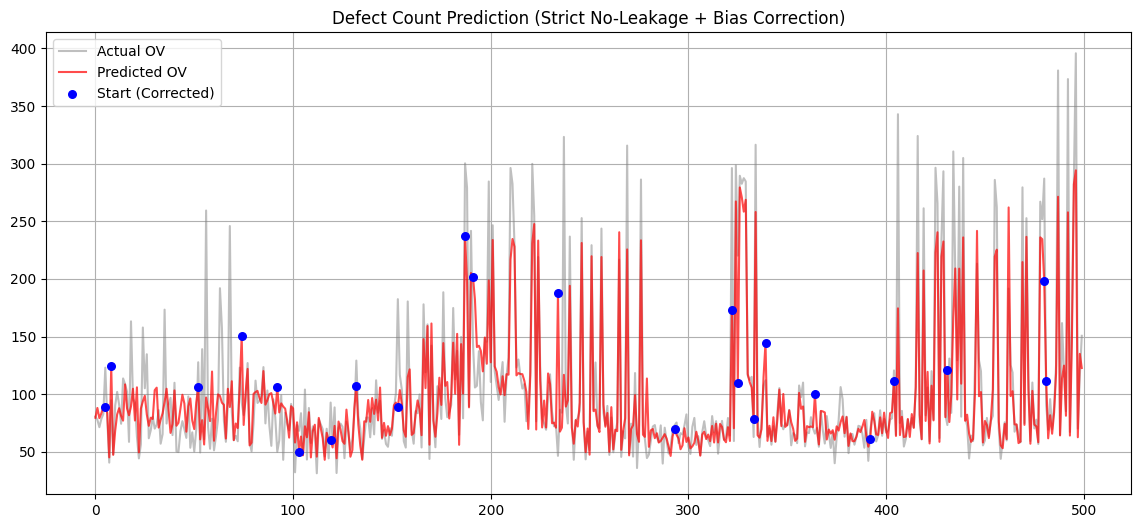

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (Strict No-Leakage)
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)
df['prev_mes_time'] = df['final_mes_time'].shift(1)
df['hours_since_prev_mes'] = (df['final_mes_time'] - df['prev_mes_time']).dt.total_seconds() / 3600
df['hours_since_prev_mes'] = df['hours_since_prev_mes'].fillna(0)

# --- ★特徴量選定におけるリーク排除 ---
test_size = 500
split_index = len(df) - test_size
train_df_for_selection = df.iloc[:split_index]

X_cols = [c for c in df.columns if c.startswith('X')]
# 学習データのみで相関を計算
corrs = train_df_for_selection[X_cols].corrwith(train_df_for_selection['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(20).index.tolist()

# A. 前ロット統計量
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# B. 類似レシピ検索 (厳密なスケーリング)
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last'])

batch_summary_train = batch_summary.iloc[:df.iloc[split_index]['batch_id']]
scaler_batch = StandardScaler()
scaler_batch.fit(batch_summary_train) 
batch_X_scaled = scaler_batch.transform(batch_summary) 

nearest_stats = []
n_batches = batch_summary.shape[0]

for i in range(n_batches):
    if i == 0:
        nearest_stats.append(batch_targets.mean().values)
        continue
    
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    nearest_indices = np.argsort(dists)[:3] 
    stats = batch_targets.iloc[nearest_indices].mean().values
    nearest_stats.append(stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'])
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

# 欠損埋め
fill_cols = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 
             'sim_batch_mean', 'sim_batch_max', 'sim_batch_last']
for c in fill_cols:
    df[c] = df[c].fillna(df.iloc[:split_index]['log_OV'].mean())

# C. 直近Startトレンド
start_ovs = df[df['is_batch_start'] == 1][['batch_id', 'log_OV']].copy()
start_ovs = start_ovs.set_index('batch_id')
start_ovs['recent_start_mean_3'] = start_ovs['log_OV'].shift(1).rolling(window=3).mean()
start_ovs = start_ovs.drop(columns=['log_OV'])
df = df.merge(start_ovs, on='batch_id', how='left')
df['recent_start_mean_3'] = df['recent_start_mean_3'].fillna(df.iloc[:split_index]['log_OV'].mean())

# D. 特徴量強調
interact_cols = ['prev_batch_mean', 'prev_batch_last', 'sim_batch_mean', 'sim_batch_last', 'recent_start_mean_3']
for c in interact_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]
for c in top_X_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# E. ラグ特徴量
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (Online Bias Correction)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

drop_cols = ['process_end_time', 'final_mes_time', 'prev_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

start_index = len(df) - test_size
end_index = len(df)
global_max_limit = df.iloc[:start_index][target].max() * 1.5

# ★オンライン補正用の変数
# 直近のStart予測における「予測値と実測値のズレ（残差）」を記録する
start_bias_history = [] 
current_start_bias = 0.0 # 補正値（初期値0）

print(f"特徴量数: {len(features)}")
print(f"予測開始 (Strict No-Leakage + Online Bias Correction)...")

for i in range(start_index, end_index):
    if (i - start_index) % 50 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- 共通トレンド (Lasso) ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_trend = lasso.predict(X_test_sc)[0]
    resid_log = y_train_log - pred_trend

    # -------------------------------------------------------
    # 1. Main Model (Normal担当)
    # -------------------------------------------------------
    weights_main = np.ones(len(y_train_log))
    weights_main[df.iloc[:i]['is_batch_start'] == 1] = 5.0
    
    # XGBoost Main
    model_xgb_m = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.02, max_depth=5, 
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
        random_state=42, n_jobs=-1
    )
    model_xgb_m.fit(X_train, resid_log, sample_weight=weights_main)
    pred_xgb_m = model_xgb_m.predict(X_test)[0]
    
    # LightGBM Main
    lgb_train_m = lgb.Dataset(X_train, resid_log, weight=weights_main)
    params_lgb_m = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.02,
        'max_depth': 6, 'num_leaves': 31, 'min_data_in_leaf': 10,
        'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'lambda_l1': 0.1,
        'verbosity': -1, 'seed': 42
    }
    model_lgb_m = lgb.train(params_lgb_m, lgb_train_m, num_boost_round=400)
    pred_lgb_m = model_lgb_m.predict(X_test)[0]
    
    pred_resid_main = (pred_xgb_m + pred_lgb_m) / 2

    # -------------------------------------------------------
    # 2. Start Specialist (Start担当)
    # -------------------------------------------------------
    if is_start == 1:
        weights_start = np.ones(len(y_train_log))
        weights_start[df.iloc[:i]['is_batch_start'] == 1] = 30.0
        
        model_xgb_s = xgb.XGBRegressor(
            n_estimators=400, learning_rate=0.03, max_depth=6, 
            subsample=0.9, colsample_bytree=0.9, reg_alpha=0.0,
            random_state=42, n_jobs=-1
        )
        model_xgb_s.fit(X_train, resid_log, sample_weight=weights_start)
        pred_resid_start_raw = model_xgb_s.predict(X_test)[0]
        
        # ★★★ ここでオンライン補正 ★★★
        # 直近の誤差傾向（バイアス）を足し合わせる
        # (例: 最近いつも-0.5低く出るなら、+0.5してあげる)
        pred_resid_start = pred_resid_start_raw + current_start_bias
        
        final_resid = pred_resid_start
    else:
        final_resid = pred_resid_main

    # --- 合体 & 予測値の確定 ---
    final_pred_log = pred_trend + final_resid
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)
    
    # ★★★ バイアスの更新 (予測後に答え合わせ) ★★★
    # ここで計算した bias は「次の」Start予測に使われる（リークではない）
    if is_start == 1:
        # 今回の正解
        actual_log = df.iloc[i]['log_OV']
        actual_resid = actual_log - pred_trend # トレンド除去後の正解残差
        
        # 今回のモデルの予測誤差 (正解 - 生の予測値)
        # 正解が 3.0 で 予測が 2.5 なら、error は +0.5 (もっと上げろ)
        error = actual_resid - pred_resid_start_raw
        
        # 指数移動平均でバイアスを更新 (過去の傾向を引きずる)
        # alpha=0.3: 直近の誤差を30%反映、過去の蓄積を70%維持
        if len(start_bias_history) == 0:
            current_start_bias = error
        else:
            current_start_bias = 0.7 * current_start_bias + 0.3 * error
            
        start_bias_history.append(current_start_bias)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Start (Corrected)', zorder=5)
plt.title("Defect Count Prediction (Strict No-Leakage + Bias Correction)")
plt.legend()
plt.grid(True)
plt.show()

Searching for Nearest Past Batches (Strict No-Leakage)...
特徴量数: 129
予測開始 (Start Strategy: Neighbor Baseline)...
Processing: 1776 / 2276
Processing: 1826 / 2276
Processing: 1876 / 2276
Processing: 1926 / 2276
Processing: 1976 / 2276
Processing: 2026 / 2276
Processing: 2076 / 2276
Processing: 2126 / 2276
Processing: 2176 / 2276
Processing: 2226 / 2276
--------------------------------------------------
Overall RMSE         : 35.6090
Batch Start RMSE (1st): 82.8952
Normal Seq RMSE (2nd+): 31.5880
--------------------------------------------------


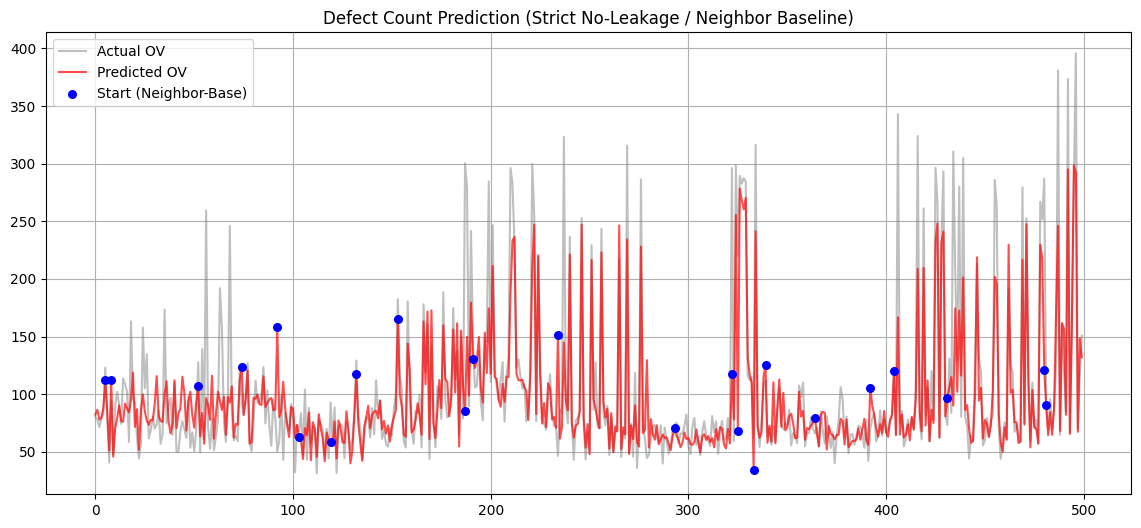

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (Strict No-Leakage)
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)
df['prev_mes_time'] = df['final_mes_time'].shift(1)
df['hours_since_prev_mes'] = (df['final_mes_time'] - df['prev_mes_time']).dt.total_seconds() / 3600
df['hours_since_prev_mes'] = df['hours_since_prev_mes'].fillna(0)

# --- ★特徴量選定におけるリーク排除 ---
test_size = 500
split_index = len(df) - test_size
train_df_for_selection = df.iloc[:split_index]

X_cols = [c for c in df.columns if c.startswith('X')]
# 学習データのみで相関を計算
corrs = train_df_for_selection[X_cols].corrwith(train_df_for_selection['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(20).index.tolist()

# A. 前ロット統計量
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# B. 類似レシピ検索 (Start専用ベースラインを作成)
print("Searching for Nearest Past Batches (Strict No-Leakage)...")
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last'])
# Start時のOV値そのものを抽出（ベースライン用）
batch_start_vals = df[df['is_batch_start'] == 1].set_index('batch_id')['log_OV']

# スケーリング（学習データのみでfit）
batch_summary_train = batch_summary.iloc[:df.iloc[split_index]['batch_id']]
scaler_batch = StandardScaler()
scaler_batch.fit(batch_summary_train) 
batch_X_scaled = scaler_batch.transform(batch_summary)

nearest_stats = []
nearest_start_direct = [] # これを新しいベースラインにする
n_batches = batch_summary.shape[0]

for i in range(n_batches):
    if i == 0:
        nearest_stats.append(batch_targets.mean().values)
        nearest_start_direct.append(batch_start_vals.mean())
        continue
    
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i] # 過去のみ参照
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    
    # 最も似ている1つのStart値を取得 (1-NN)
    nearest_idx = np.argmin(dists)
    if nearest_idx in batch_start_vals.index:
        nearest_start_direct.append(batch_start_vals.loc[nearest_idx])
    else:
        nearest_start_direct.append(batch_start_vals.mean())
    
    # 従来の特徴量 (Top 3 平均)
    nearest_indices = np.argsort(dists)[:3] 
    stats = batch_targets.iloc[nearest_indices].mean().values
    nearest_stats.append(stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'])
nearest_df['sim_start_ov_direct'] = nearest_start_direct # これが重要
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

# 欠損埋め
fill_cols = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 
             'sim_batch_mean', 'sim_batch_max', 'sim_batch_last', 'sim_start_ov_direct']
for c in fill_cols:
    df[c] = df[c].fillna(df.iloc[:split_index]['log_OV'].mean())

# C. 直近Startトレンド
start_ovs = df[df['is_batch_start'] == 1][['batch_id', 'log_OV']].copy()
start_ovs = start_ovs.set_index('batch_id')
start_ovs['recent_start_mean_3'] = start_ovs['log_OV'].shift(1).rolling(window=3).mean()
start_ovs = start_ovs.drop(columns=['log_OV'])
df = df.merge(start_ovs, on='batch_id', how='left')
df['recent_start_mean_3'] = df['recent_start_mean_3'].fillna(df.iloc[:split_index]['log_OV'].mean())

# D. 特徴量強調 (sim_start_ov_direct との差分などを意識させる)
df['diff_from_sim_start'] = df['sim_start_ov_direct'] - df['recent_start_mean_3'] # 過去類似と直近傾向のギャップ
interact_cols = ['prev_batch_mean', 'prev_batch_last', 'sim_batch_mean', 'sim_start_ov_direct', 'diff_from_sim_start']
for c in interact_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]
for c in top_X_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# E. ラグ特徴量
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (Neighbor Baseline Strategy)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

drop_cols = ['process_end_time', 'final_mes_time', 'prev_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

start_index = len(df) - test_size
end_index = len(df)
global_max_limit = df.iloc[:start_index][target].max() * 1.5

print(f"特徴量数: {len(features)}")
print(f"予測開始 (Start Strategy: Neighbor Baseline)...")

for i in range(start_index, end_index):
    if (i - start_index) % 50 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    # データ分割
    X_train_full = df.iloc[:i][features]
    y_train_full = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # -------------------------------------------------------
    # Case A: Normal (2番目以降) -> 従来どおり最強の構成
    # -------------------------------------------------------
    if is_start == 0:
        # Lasso トレンド
        scaler = StandardScaler()
        X_train_sc = scaler.fit_transform(X_train_full)
        X_test_sc = scaler.transform(X_test)
        lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
        lasso.fit(X_train_sc, y_train_full)
        pred_base = lasso.predict(X_test_sc)[0]
        resid = y_train_full - lasso.predict(X_train_sc)
        
        # 残差予測 (LightGBM + XGBoost)
        # Normalなので重み付けなしでフラットに学習
        lgb_train = lgb.Dataset(X_train_full, resid)
        params_lgb = {
            'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.02,
            'max_depth': 6, 'num_leaves': 31, 'min_data_in_leaf': 10,
            'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'lambda_l1': 0.1,
            'verbosity': -1, 'seed': 42
        }
        model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=400)
        p_lgb = model_lgb.predict(X_test)[0]
        
        model_xgb = xgb.XGBRegressor(
            n_estimators=400, learning_rate=0.02, max_depth=5, 
            subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
            random_state=42, n_jobs=-1
        )
        model_xgb.fit(X_train_full, resid)
        p_xgb = model_xgb.predict(X_test)[0]
        
        final_pred_log = pred_base + (p_lgb + p_xgb) / 2

    # -------------------------------------------------------
    # Case B: Batch Start (1番目) -> 類似事例ベースライン
    # -------------------------------------------------------
    else:
        # 学習データの抽出: 過去のStartデータのみを使う (純度を高める)
        # Normalデータは「類似Start値との差」という概念が当てはまらないため混ぜない
        mask_start = df.iloc[:i]['is_batch_start'] == 1
        X_train_start = df.iloc[:i][mask_start][features]
        y_train_start_raw = df.iloc[:i][mask_start]['log_OV']
        
        # ★重要: ベースラインを「類似バッチのStart値」にする
        base_values = df.iloc[:i][mask_start]['sim_start_ov_direct']
        # 目的変数 = 実測値 - 類似バッチの値 (AIは「ズレ」だけを学習)
        y_train_diff = y_train_start_raw - base_values
        
        # モデル学習 (データ数が少ないのでパラメータを調整)
        # データ数が少ないときはRandomForestやLassoも効くが、XGBoostで浅く作る
        model_xgb_s = xgb.XGBRegressor(
            n_estimators=300, 
            learning_rate=0.03, # 少し早めに収束させる
            max_depth=3,        # 浅くして過学習を防ぐ
            subsample=0.8, colsample_bytree=0.8, 
            reg_alpha=0.1,      # 正則化
            random_state=42, n_jobs=-1
        )
        model_xgb_s.fit(X_train_start, y_train_diff)
        
        # 予測
        pred_diff = model_xgb_s.predict(X_test)[0]
        
        # ベースライン（今回の類似Start値）に予測したズレを足す
        current_base = X_test['sim_start_ov_direct'].values[0]
        final_pred_log = current_base + pred_diff

    # --- 最終化 ---
    final_pred = np.expm1(final_pred_log)
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Start (Neighbor-Base)', zorder=5)
plt.title("Defect Count Prediction (Strict No-Leakage / Neighbor Baseline)")
plt.legend()
plt.grid(True)
plt.show()

Searching for Nearest Past Batches (k=5 Robust)...
特徴量数: 128
予測開始 (Test: Last 500 / Strategy: Anchoring)...
Processing: 1776 / 2276
Processing: 1826 / 2276
Processing: 1876 / 2276
Processing: 1926 / 2276
Processing: 1976 / 2276
Processing: 2026 / 2276
Processing: 2076 / 2276
Processing: 2126 / 2276
Processing: 2176 / 2276
Processing: 2226 / 2276
--------------------------------------------------
Overall RMSE         : 32.6267
Batch Start RMSE (1st): 71.4306
Normal Seq RMSE (2nd+): 29.4925
--------------------------------------------------


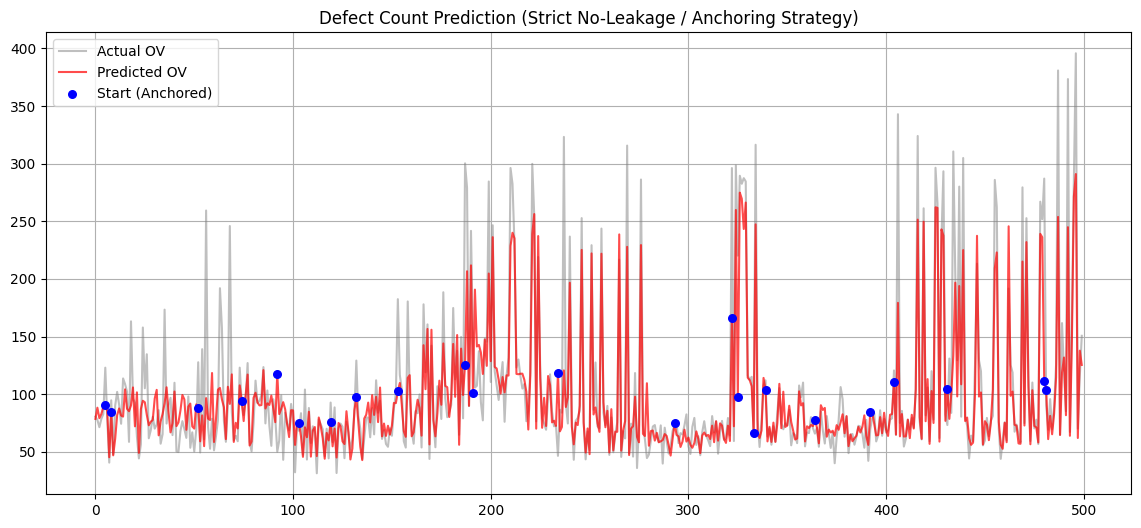

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (Strict No-Leakage)
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)
df['prev_mes_time'] = df['final_mes_time'].shift(1)
df['hours_since_prev_mes'] = (df['final_mes_time'] - df['prev_mes_time']).dt.total_seconds() / 3600
df['hours_since_prev_mes'] = df['hours_since_prev_mes'].fillna(0)

# --- 特徴量選定（リークなし） ---
test_size = 500
split_index = len(df) - test_size
train_df_for_selection = df.iloc[:split_index]

X_cols = [c for c in df.columns if c.startswith('X')]
corrs = train_df_for_selection[X_cols].corrwith(train_df_for_selection['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(20).index.tolist()

# A. 前ロット統計量
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# B. 類似レシピ検索 (Top 5 平均で安定化)
print("Searching for Nearest Past Batches (k=5 Robust)...")
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last'])
# Start値の参照用
batch_start_vals = df[df['is_batch_start'] == 1].set_index('batch_id')['log_OV']

# スケーリング（学習データのみ）
batch_summary_train = batch_summary.iloc[:df.iloc[split_index]['batch_id']]
scaler_batch = StandardScaler()
scaler_batch.fit(batch_summary_train) 
batch_X_scaled = scaler_batch.transform(batch_summary)

nearest_stats = []
nearest_start_robust = [] # Top 5のStart値の平均（安定版）
n_batches = batch_summary.shape[0]

for i in range(n_batches):
    if i == 0:
        nearest_stats.append(batch_targets.mean().values)
        nearest_start_robust.append(batch_start_vals.mean())
        continue
    
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    
    # ノイズ対策: 1つではなく「Top 5」の平均を使う
    k = 5
    if i < k: k = i # 過去が少ない場合
    nearest_indices = np.argsort(dists)[:k]
    
    # 統計量
    stats = batch_targets.iloc[nearest_indices].mean().values
    nearest_stats.append(stats)
    
    # Start値の平均（アンカー用）
    valid_starts = [batch_start_vals.loc[idx] for idx in nearest_indices if idx in batch_start_vals.index]
    if valid_starts:
        nearest_start_robust.append(np.mean(valid_starts))
    else:
        nearest_start_robust.append(batch_start_vals.mean())

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'])
nearest_df['sim_start_robust'] = nearest_start_robust # ★安定化したアンカー
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

# 欠損埋め
fill_cols = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 
             'sim_batch_mean', 'sim_batch_max', 'sim_batch_last', 'sim_start_robust']
for c in fill_cols:
    df[c] = df[c].fillna(df.iloc[:split_index]['log_OV'].mean())

# C. 直近Startトレンド
start_ovs = df[df['is_batch_start'] == 1][['batch_id', 'log_OV']].copy()
start_ovs = start_ovs.set_index('batch_id')
start_ovs['recent_start_mean_3'] = start_ovs['log_OV'].shift(1).rolling(window=3).mean()
start_ovs = start_ovs.drop(columns=['log_OV'])
df = df.merge(start_ovs, on='batch_id', how='left')
df['recent_start_mean_3'] = df['recent_start_mean_3'].fillna(df.iloc[:split_index]['log_OV'].mean())

# D. 特徴量強調
interact_cols = ['prev_batch_mean', 'prev_batch_last', 'sim_batch_mean', 'sim_start_robust', 'recent_start_mean_3']
for c in interact_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]
for c in top_X_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# E. ラグ特徴量
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (Anchoring Strategy)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

drop_cols = ['process_end_time', 'final_mes_time', 'prev_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

start_index = len(df) - test_size
end_index = len(df)
global_max_limit = df.iloc[:start_index][target].max() * 1.5

print(f"特徴量数: {len(features)}")
print(f"予測開始 (Test: Last 500 / Strategy: Anchoring)...")

for i in range(start_index, end_index):
    if (i - start_index) % 50 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- 共通トレンド (Lasso) ---
    # 安定した土台を作る
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log)
    pred_trend = lasso.predict(X_test_sc)[0]
    resid_log = y_train_log - pred_trend

    # -------------------------------------------------------
    # 1. Main Model (Normal担当)
    # -------------------------------------------------------
    # 重み: x5 (Startへの過剰適合を防ぐ)
    weights_main = np.ones(len(y_train_log))
    weights_main[df.iloc[:i]['is_batch_start'] == 1] = 5.0
    
    lgb_train_m = lgb.Dataset(X_train, resid_log, weight=weights_main)
    params_lgb_m = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.02,
        'max_depth': 6, 'num_leaves': 31, 'min_data_in_leaf': 10,
        'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'lambda_l1': 0.1,
        'verbosity': -1, 'seed': 42
    }
    model_lgb_m = lgb.train(params_lgb_m, lgb_train_m, num_boost_round=400)
    pred_lgb_m = model_lgb_m.predict(X_test)[0]
    
    model_xgb_m = xgb.XGBRegressor(
        n_estimators=400, learning_rate=0.02, max_depth=5, 
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
        random_state=42, n_jobs=-1
    )
    model_xgb_m.fit(X_train, resid_log, sample_weight=weights_main)
    pred_xgb_m = model_xgb_m.predict(X_test)[0]
    
    pred_resid_main = (pred_lgb_m + pred_xgb_m) / 2

    # -------------------------------------------------------
    # 2. Start Specialist (Start担当 + Anchoring)
    # -------------------------------------------------------
    if is_start == 1:
        # 重み: x20 (Start重視)
        weights_start = np.ones(len(y_train_log))
        weights_start[df.iloc[:i]['is_batch_start'] == 1] = 20.0
        
        # Start専用 XGBoost
        model_xgb_s = xgb.XGBRegressor(
            n_estimators=400, learning_rate=0.03, max_depth=6, 
            subsample=0.9, colsample_bytree=0.9, reg_alpha=0.0,
            random_state=42, n_jobs=-1
        )
        model_xgb_s.fit(X_train, resid_log, sample_weight=weights_start)
        pred_resid_ai = model_xgb_s.predict(X_test)[0]
        
        # ★★★ アンカー処理 (Anchoring) ★★★
        # AIの予測(トレンド+残差) と 類似事例の実績値(sim_start_robust) をブレンド
        
        # 1. AIによる完全予測値
        ai_full_pred = pred_trend + pred_resid_ai
        
        # 2. 類似事例の値 (5-NN平均)
        anchor_val = X_test['sim_start_robust'].values[0]
        
        # 3. ブレンド (AI 50% : アンカー 50%)
        # AIが学習した「今回の条件」と、過去の「厳然たる事実」を半々で混ぜる
        final_pred_log = 0.5 * ai_full_pred + 0.5 * anchor_val
        
    else:
        final_pred_log = pred_trend + pred_resid_main

    # --- 最終化 ---
    final_pred = np.expm1(final_pred_log)
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Start (Anchored)', zorder=5)
plt.title("Defect Count Prediction (Strict No-Leakage / Anchoring Strategy)")
plt.legend()
plt.grid(True)
plt.show()